In [1]:
"""
WORKING File
"""

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# function to perform stepwsise selection
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [4]:
"""
Function to plot y vs. a chosen set of x variables: includes regression line
"""

def plot_relationship(data, y_vars, x_vars, height=4.5):
    grid = sns.PairGrid(data=data, y_vars=y_vars, x_vars=x_vars, height=height)
    grid.map(sns.regplot)

In [5]:
"""
Function to identify multi-collinearity
"""
def multi_collinearity(data_pred, percent_correlated=0.75):
    df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    
    # zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))
    
    # set index to pairs
    df.set_index(['pairs'], inplace=True)
    
    # drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace=True)
    
    # rename correlation column as cc rather than 0
    df.columns = ['cc']
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df[(df.cc > percent_correlated) & (df.cc < 1)]
    

In [6]:
"""
Function to find outliers based on quartiles
"""
def find_outliers(variable, data):
    q3 = data[variable].quantile(0.75)
    q1 = data[variable].quantile(0.25)
    iqr = q3 - q1
    low = q1 - (1.5*iqr)
    high = q3 + (1.5*iqr)
    return low, high

In [7]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [8]:
# import raw dataset
raw_data = pd.read_csv('kc_house_data.csv')

# examine the raw dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [9]:
# drop the id column as that won't be relevant
clean_data = raw_data.drop('id', axis=1)

In [10]:
# handle missing values
# waterfront
# yr_renovated
# view

# waterfront
clean_data['waterfront'].unique()

array([nan,  0.,  1.])

In [11]:
# set all nans to 0 as houses missing waterfront info likely are not waterfront
clean_data['waterfront'] = clean_data['waterfront'].fillna(value=0.)

In [12]:
# yr_renovated missing values
clean_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [13]:
# similar to waterfront, assume missing data are 0s - non-renos
clean_data['yr_renovated'] = clean_data['yr_renovated'].fillna(value=0.)

In [14]:
# view missing values
clean_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [15]:
# set missing values to 0 with the assumption that missing values have no views
clean_data['view'] = clean_data['view'].fillna(value=0.)

In [16]:
clean_data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [17]:
# no more missing values, check for duplicates
clean_data.duplicated().sum()

0

In [18]:
# there are no duplicates - - handles strings and convert all colulmns 
# to appropriate type
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [19]:
# only string columns are the date and sqft_basement
# evaluate sqft_basement
clean_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [20]:
# replace '?' with zero with assumption that these do not have basements
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace(to_replace='?',
                                                                  value='0.0')

# convert to a number format
clean_data['sqft_basement'] = clean_data['sqft_basement'].astype('float64')

In [21]:
# handle date column - convert to datetime and then split into year, month, day
clean_data['date'] = pd.to_datetime(clean_data['date'], 
                                    infer_datetime_format=True)

In [22]:
# create indidivual columns for year, month, day
clean_data['year_sold'] = clean_data['date'].map(lambda x: x.year)
clean_data['month_sold'] = clean_data['date'].map(lambda x: x.month)
clean_data['day_sold'] = clean_data['date'].map(lambda x: x.day)

# drop date column
clean_data = clean_data.drop('date', axis=1)

In [23]:
# start checking distributions / histograms
# clean_data.hist(figsize=(20, 15), bins='auto');

In [24]:
# price, sqft_above, sqft_living, sqft_living15 all appear continuous and log normally distributed
# the majority of houses seem to have less than 4 bathrooms
# most houses have a condition of 3 or higher
# the majority of houses have 2 floors or less
# there are a large number of houses with 0 sqft_basement, likely a result of not having a basement

In [25]:
# evaluate relationships with price
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['floors', 'waterfront', 'view', 'condition'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['grade', 'sqft_above', 'sqft_basement', 'yr_built'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_renovated', 'zipcode', 'lat', 'long'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living15', 'sqft_lot15'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['year_sold', 'month_sold', 'day_sold'])

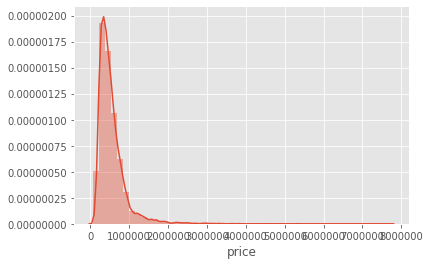

In [26]:
# there are a number of significant outliers impacting 
# look at just the distribution of price
sns.distplot(clean_data['price']);

In [27]:
# looks log normally distributed - - log transform after baseline model
# replot only continuous columns vs. price
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [28]:
# drop non-linear
preprocessed = clean_data.drop(['sqft_lot', 'yr_built', 'yr_renovated',
                                'zipcode', 'lat', 'long', 'sqft_lot15'], axis=1)

In [29]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   waterfront     21597 non-null  float64
 6   view           21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  float64
 11  sqft_living15  21597 non-null  int64  
 12  year_sold      21597 non-null  int64  
 13  month_sold     21597 non-null  int64  
 14  day_sold       21597 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 2.5 MB


In [30]:
# we've now dropped non-linear
# identify and remove any multi-collinearity
data_pred = preprocessed.drop(['price'], axis=1)
correlated_predictors = multi_collinearity(data_pred, 0.75)
correlated_predictors

cc
pairs                                 
(sqft_above, sqft_living)     0.876448
(month_sold, year_sold)       0.782325
(sqft_living, grade)          0.762779
(sqft_living, sqft_living15)  0.756402
(sqft_above, grade)           0.756073
(sqft_living, bathrooms)      0.755758

In [31]:
# We see the following relationships:
# sqft_above: sqft_living, grade
# sqft_living: sqft_above, grade, sqft_living15, bathrooms
# month_sold: year_sold
# drop sqft_above, grade, sqft_living15, bathrooms as correlated with sqft_living
# drop month_sold as correlated with year_sold
preprocessed.drop(['sqft_above', 'grade', 'sqft_living15', 'bathrooms', 'month_sold'],
                  axis=1, 
                  inplace=True)

In [32]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   sqft_living    21597 non-null  int64  
 3   floors         21597 non-null  float64
 4   waterfront     21597 non-null  float64
 5   view           21597 non-null  float64
 6   condition      21597 non-null  int64  
 7   sqft_basement  21597 non-null  float64
 8   year_sold      21597 non-null  int64  
 9   day_sold       21597 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 1.6 MB


In [33]:
# evaluate and handle categorical columns
# check for ordinal relationships and identify OHE where necessary

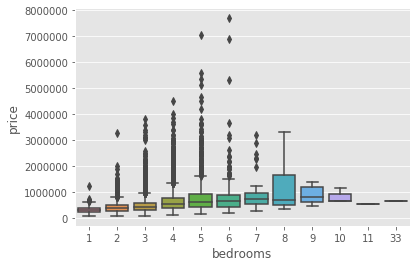

In [34]:
# bedrooms
sns.boxplot(x='bedrooms', y='price', data=preprocessed);

In [35]:
# pretty clear that there are a number of outliers, will leave in for baseline
# ordinal relationship, leave as a single column

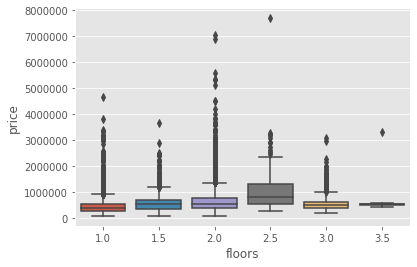

In [36]:
# floors
sns.boxplot(x='floors', y='price', data=preprocessed);

In [37]:
# no real ordinal relationship, will OHE
# scale by 10 to prevent issues with sms.ols later
preprocessed['floors_10'] = preprocessed['floors'] * 10

# convert to int
preprocessed['floors_10'] = preprocessed['floors_10'].astype('int64')

In [38]:
# add to ohe list
ohe_list = []
ohe_list.append('floors_10')

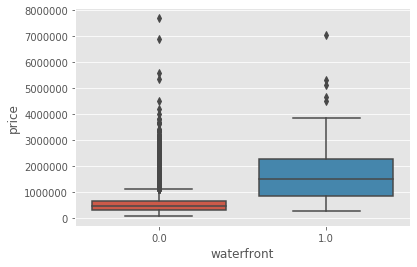

In [39]:
# waterfront
sns.boxplot(x='waterfront', y='price', data=preprocessed);

In [40]:
# looks like having a waterfront is positive relationship with price
# convert to int to avoid syntax issues
preprocessed['waterfront_clean'] = preprocessed['waterfront'].astype('int64')
ohe_list.append('waterfront_clean')

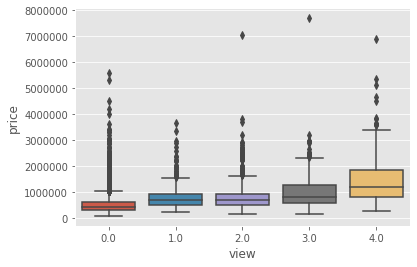

In [41]:
# view
sns.boxplot(x='view', y='price', data=preprocessed);

In [42]:
# slight ordinal relationship, leave as a single column

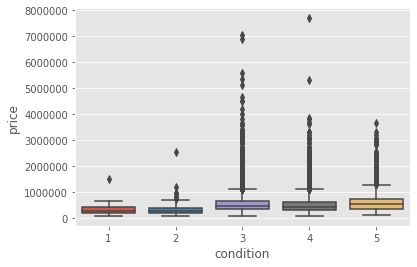

In [43]:
# condition
sns.boxplot(x='condition', y='price', data=preprocessed);

In [44]:
# no clear ordinal relationship here - - OHE for now
ohe_list.append('condition')

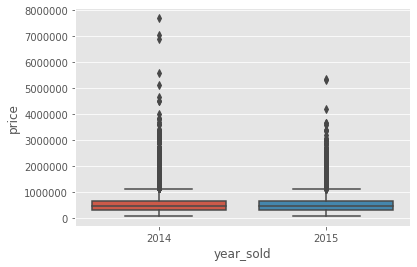

In [45]:
# year_sold
sns.boxplot(x='year_sold', y='price', data=preprocessed);

In [46]:
# ohe
ohe_list.append('year_sold')

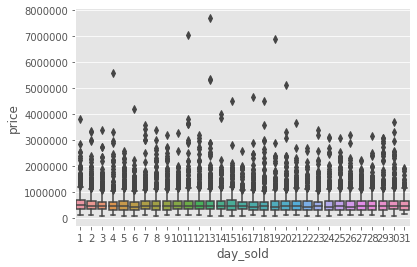

In [47]:
# days_sold
sns.boxplot(x='day_sold', y='price', data=preprocessed);

In [48]:
# create dummy variables
ohe_list.append('day_sold')
ohe_list

['floors_10', 'waterfront_clean', 'condition', 'year_sold', 'day_sold']

In [49]:
# create dummy variables
floors_dummies = pd.get_dummies(preprocessed['floors_10'], 
                                prefix='floors', 
                                drop_first=True)

waterfront_dummies = pd.get_dummies(preprocessed['waterfront_clean'], 
                                    prefix='waterfront', 
                                    drop_first=True)

condition_dummies = pd.get_dummies(preprocessed['condition'],
                                   prefix='condition',
                                   drop_first=True)

year_sold_dummies = pd.get_dummies(preprocessed['year_sold'],
                                   prefix='year_sold',
                                   drop_first=True)

day_sold_dummies = pd.get_dummies(preprocessed['day_sold'],
                                  prefix='day_sold',
                                  drop_first=True)

In [50]:
# drop columns
data_fin = preprocessed.drop(['floors', 'floors_10'], axis=1)
data_fin = data_fin.drop(['waterfront', 'waterfront_clean'], axis=1)
data_fin = data_fin.drop(['condition', 'year_sold', 'day_sold'], axis=1)

In [51]:
# concat with dummies
data_fin = pd.concat([data_fin, floors_dummies, 
                      waterfront_dummies, condition_dummies,
                      year_sold_dummies, day_sold_dummies], axis=1)

In [52]:
# run stepwise selection to select features
y = data_fin['price']
X = data_fin.drop('price', axis=1)
result = stepwise_selection(X, y, verbose=True)

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  waterfront_1                   with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  view                           with p-value 3.82179e-211
Add  bedrooms                       with p-value 4.06788e-91
Drop sqft_basement                  with p-value 0.628439
Add  condition_5                    with p-value 1.09556e-49
Add  floors_15                      with p-value 5.48961e-34
Add  floors_30                      with p-value 1.48558e-32
Add  floors_25                      with p-value 2.5305e-33
Add  condition_4                    with p-value 4.80982e-17
Add  year_sold_2015                 with p-value 1.16024e-10
Add  floors_35                      with p-value 0.0019816
Add  day_sold_13                    with p-value 0.00555331


In [53]:
result

['waterfront_1',
 'sqft_living',
 'view',
 'bedrooms',
 'condition_5',
 'floors_15',
 'floors_30',
 'floors_25',
 'condition_4',
 'year_sold_2015',
 'floors_35',
 'day_sold_13']

In [54]:
# run regression with these features
X = data_fin[result]
y = data_fin['price']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     2427.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:38:56   Log-Likelihood:            -2.9817e+05
No. Observations:               21597   AIC:                         5.964e+05
Df Residuals:                   21584   BIC:                         5.965e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.629e+04   6479.628      7.144      0.000    3.36e+04     5.9e+04
waterfront_1     5.89e+05   2.15e+04     27.334      0.000    5.47e+05    6.31e+05
sqft_living      290.7063      2.316    125.495      0.000     286.166     295.247
view            6.848e+04   2408.071     28.439      0.000    6.38e+04    7.32e+04
bedrooms       -4.949e+04   2191.245    -22.584      0.000   -5.38e+04   -4.52e+04
condition_5     9.737e+04   6235.425     15.615      0.000    8.51e+04     1.1e+05
floors_15       7.317e+04   5840.619     12.527      0.000    6.17e+04    8.46e+04
floors_30       1.292e+05   9947.638     12.988      0.000     1.1e+05    1.49e+05
floors_25         2.3e+05   1.91e+04     12.063      0.000    1.93e+05    2.67e+05
condition_4     3.277e+04   3825.378      8.566      0.000    2.53e+04    4.03e+04
year_sold_2015  2.216e+04   3497.586      6.336      0.000    1.53e+04     2.9e+04
floors_35       2.813e+05   9.06e+04      3.104      0.002    1.04e+05    4.59e+05
day_sold_13     2.489e+04   8974.583      2.773      0.006    7298.653    4.25e+04
==============================================================================
Omnibus:                    13246.755   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           459840.242
Skew:                           2.400   Prob(JB):                         0.00
Kurtosis:                      25.090   Cond. No.                     1.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~price
-------------------------------------------------------------------------------------


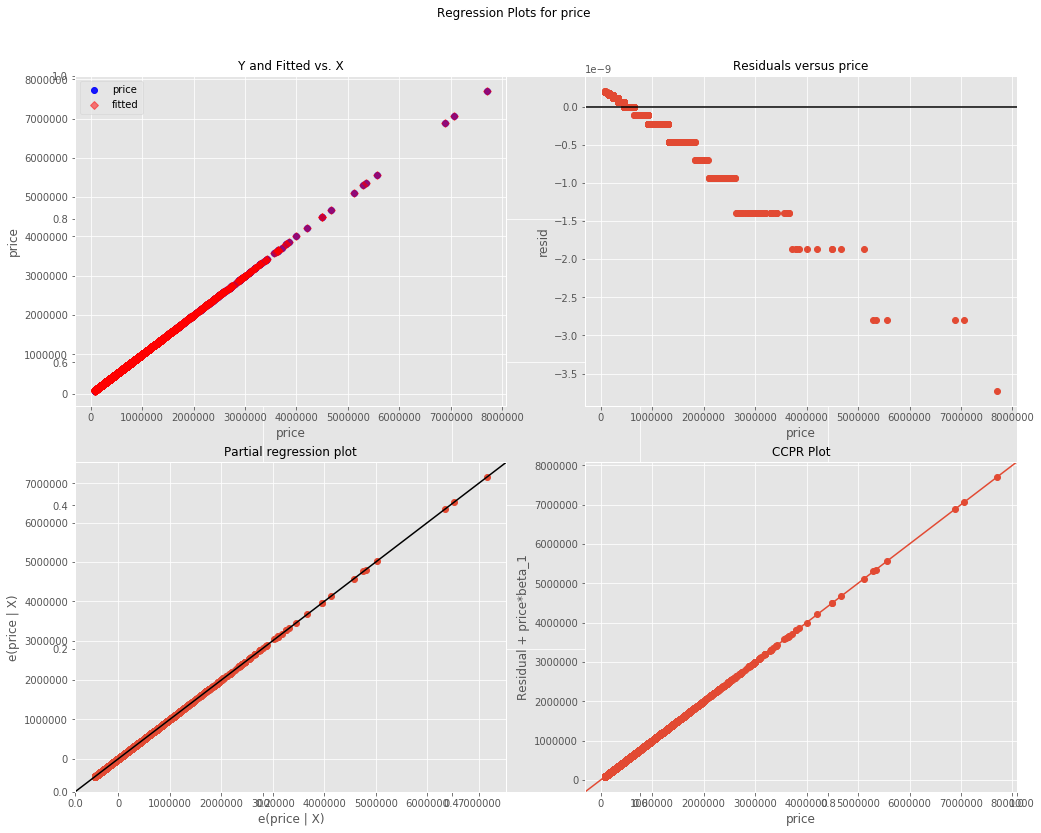

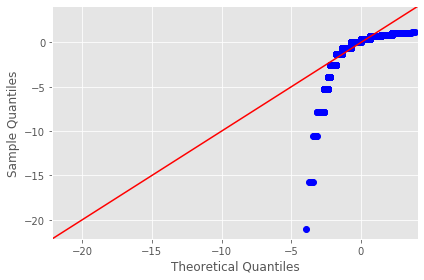

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~waterfront_1
-------------------------------------------------------------------------------------


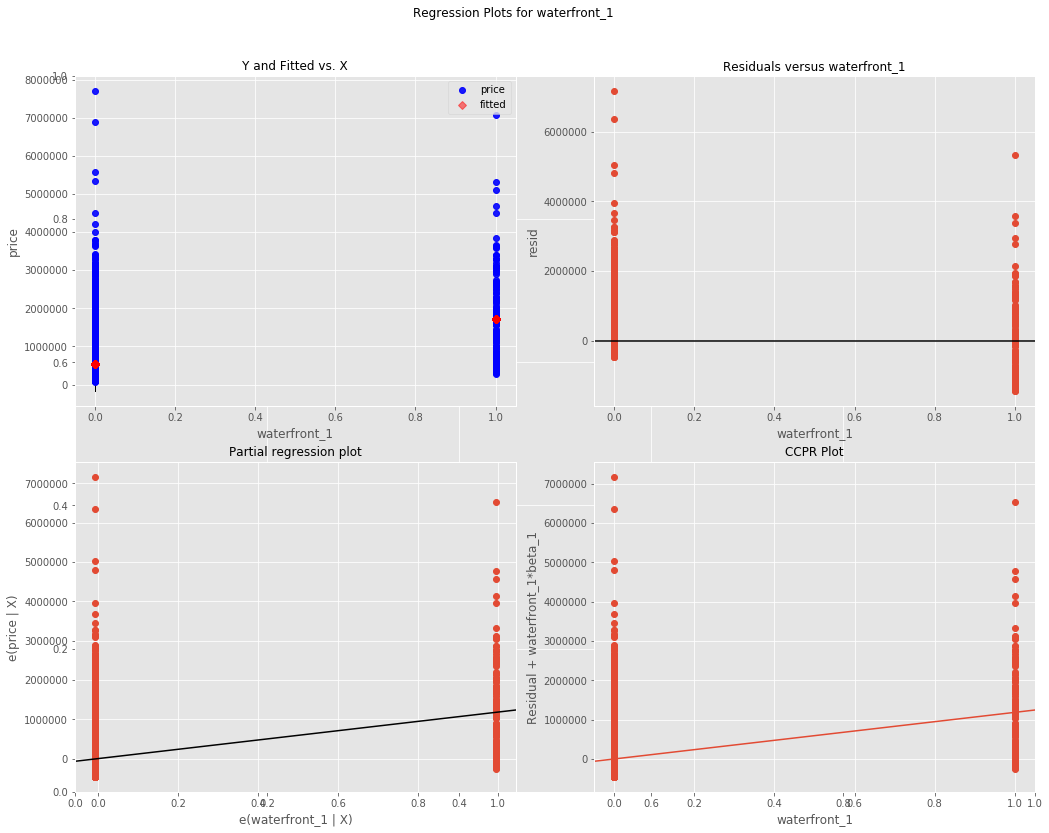

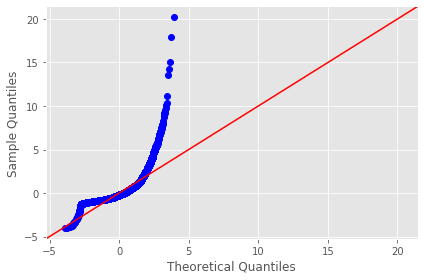

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~sqft_living
-------------------------------------------------------------------------------------


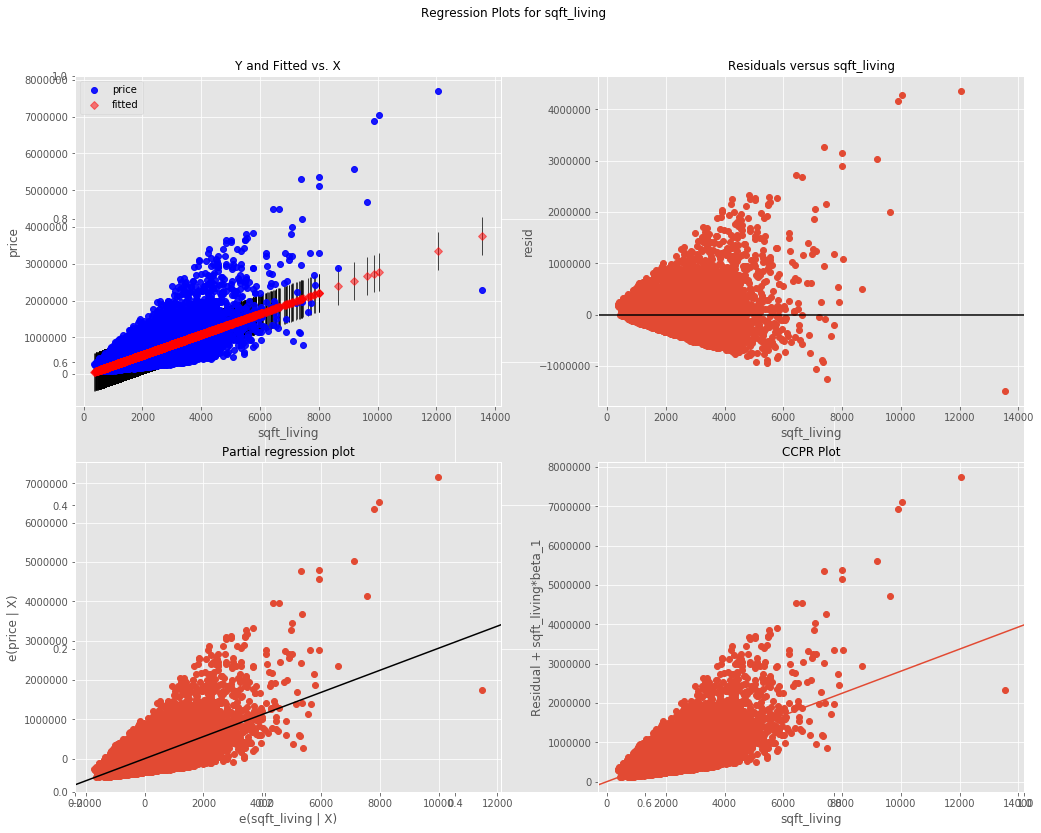

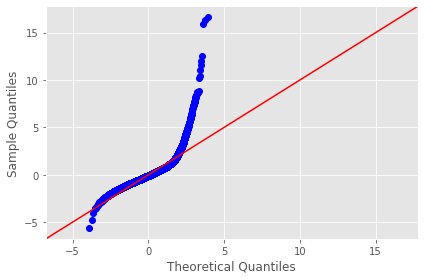

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view
-------------------------------------------------------------------------------------


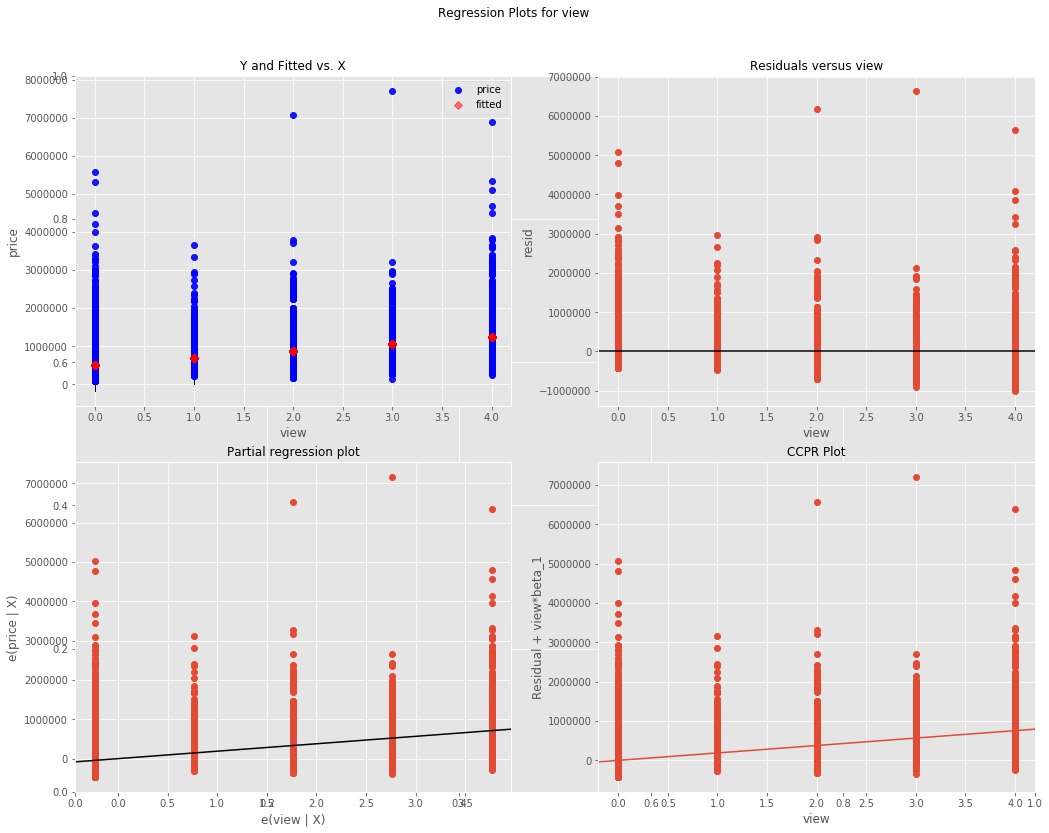

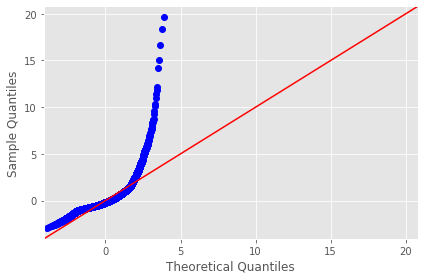

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~bedrooms
-------------------------------------------------------------------------------------


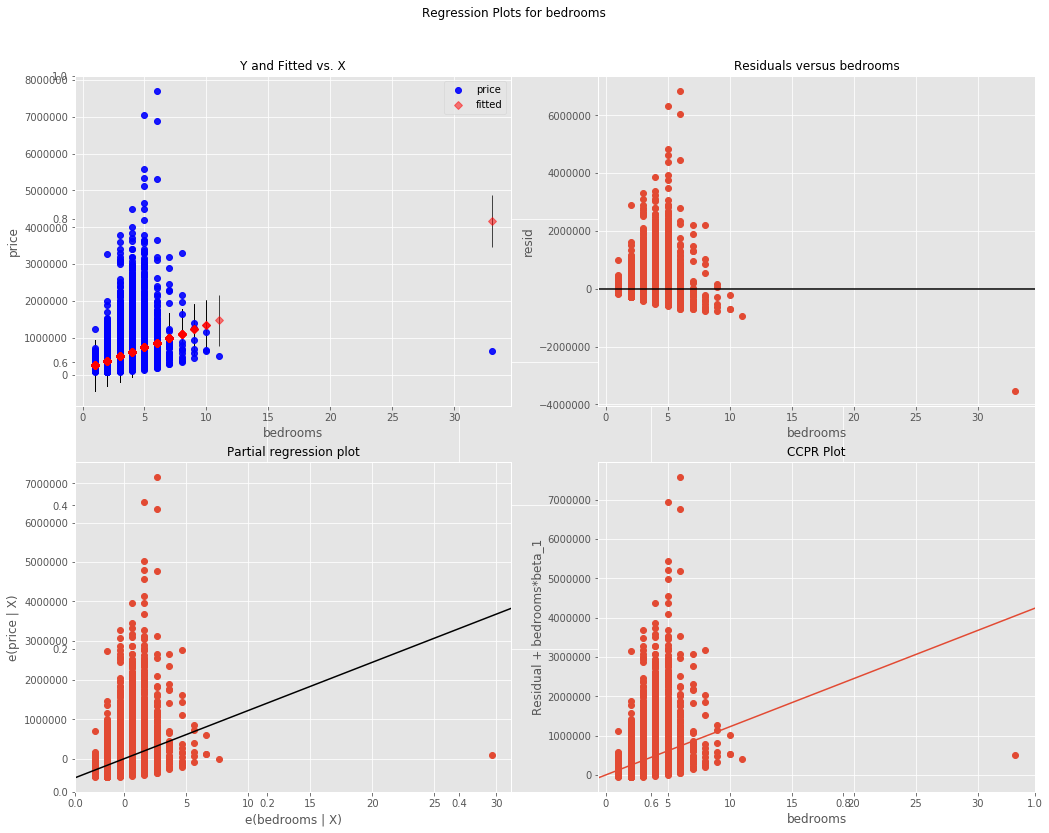

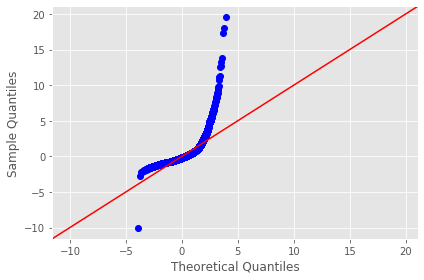

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_5
-------------------------------------------------------------------------------------


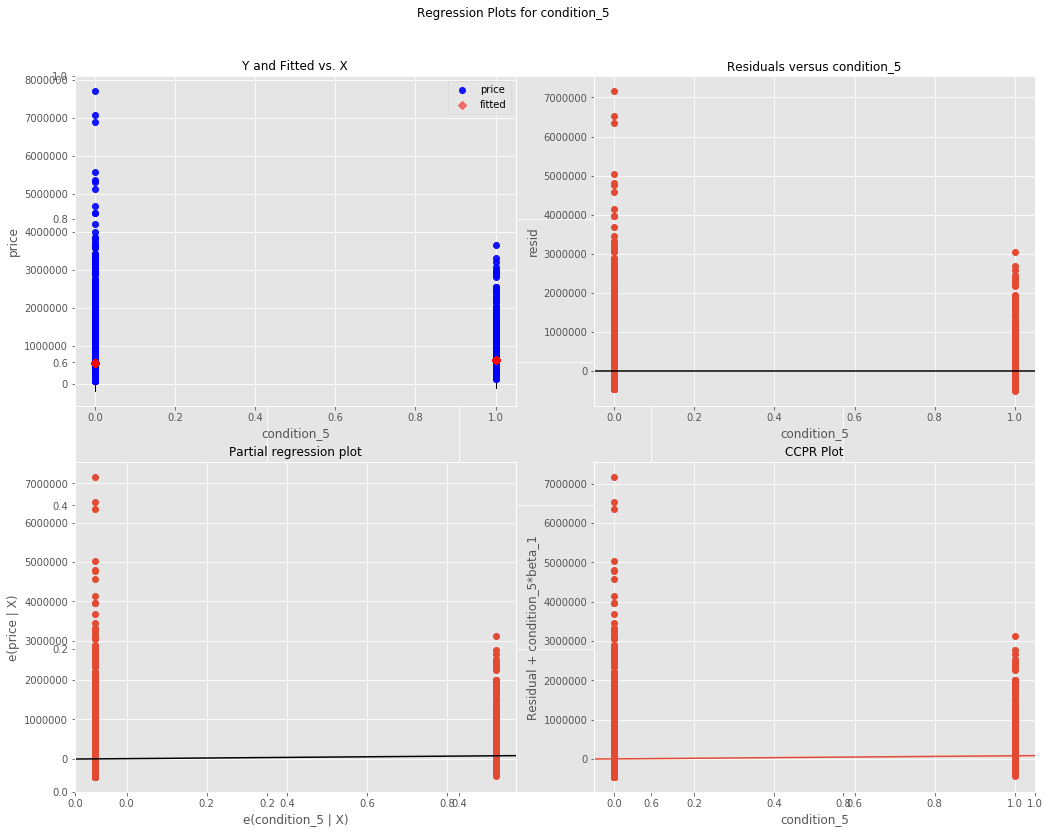

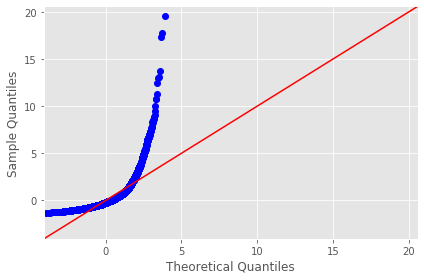

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_15
-------------------------------------------------------------------------------------


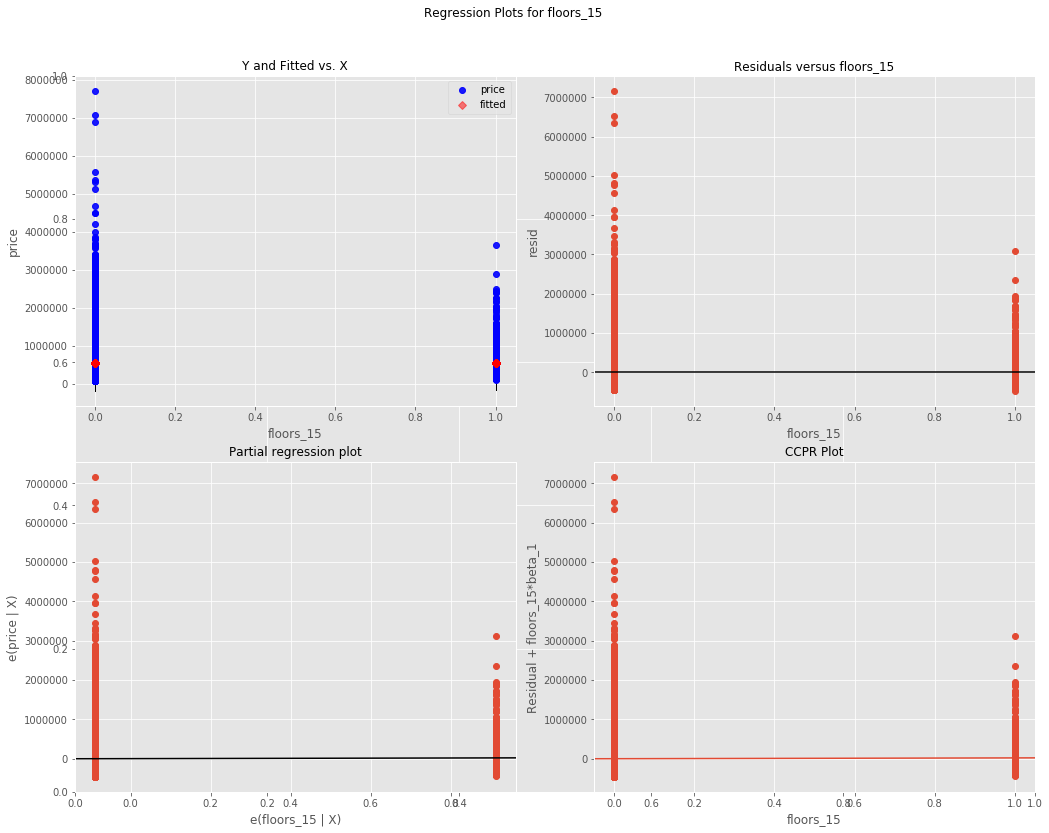

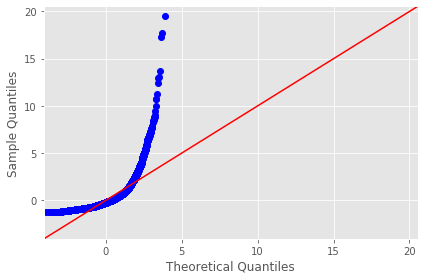

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_30
-------------------------------------------------------------------------------------


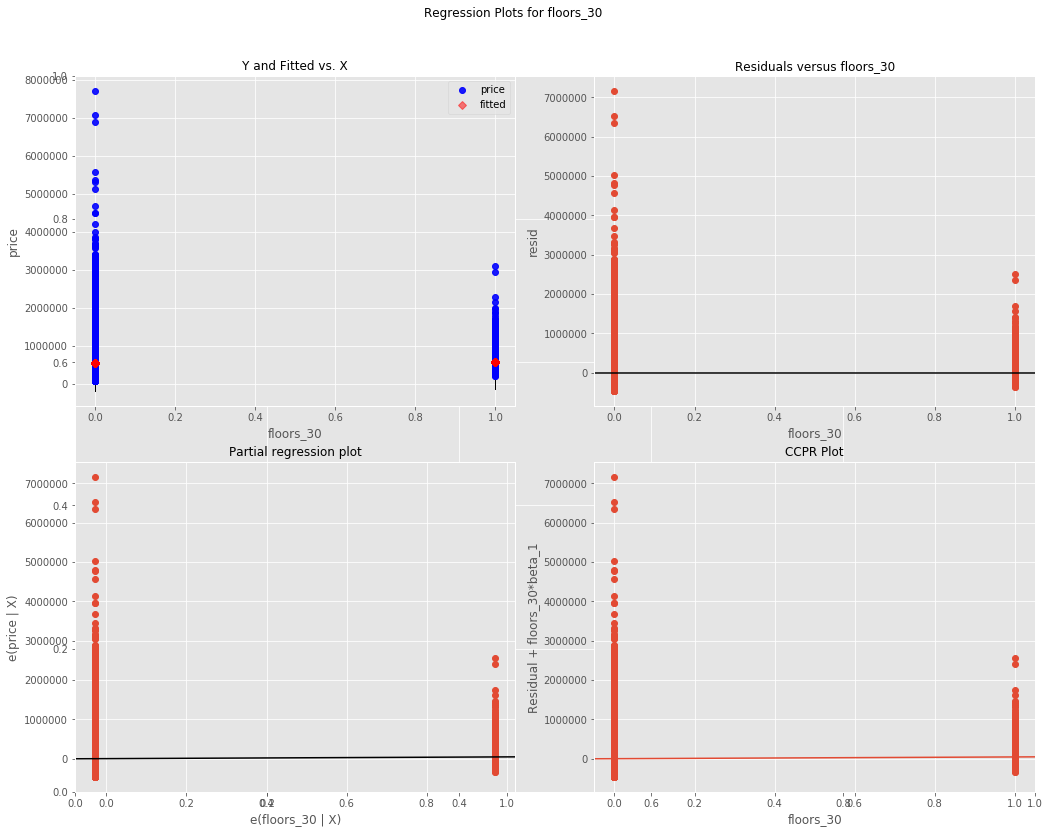

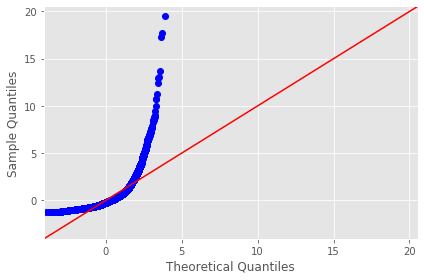

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_25
-------------------------------------------------------------------------------------


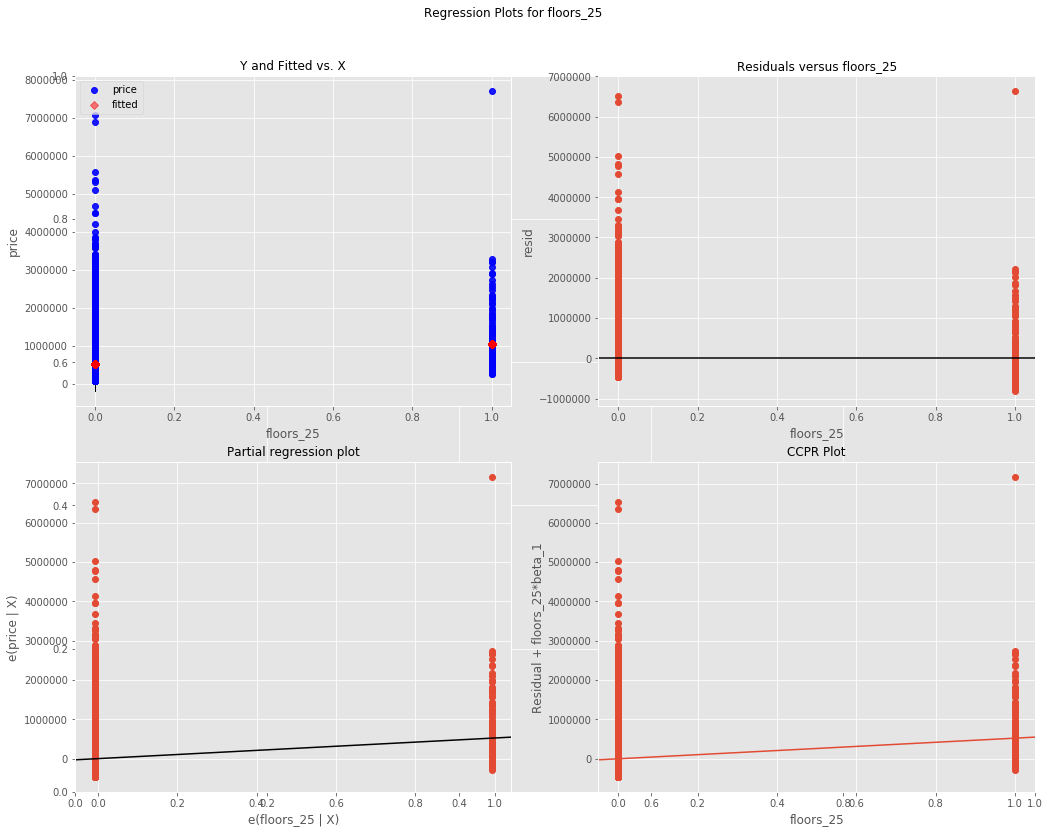

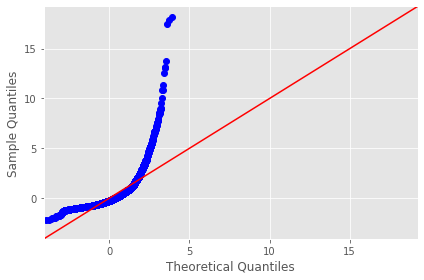

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_4
-------------------------------------------------------------------------------------


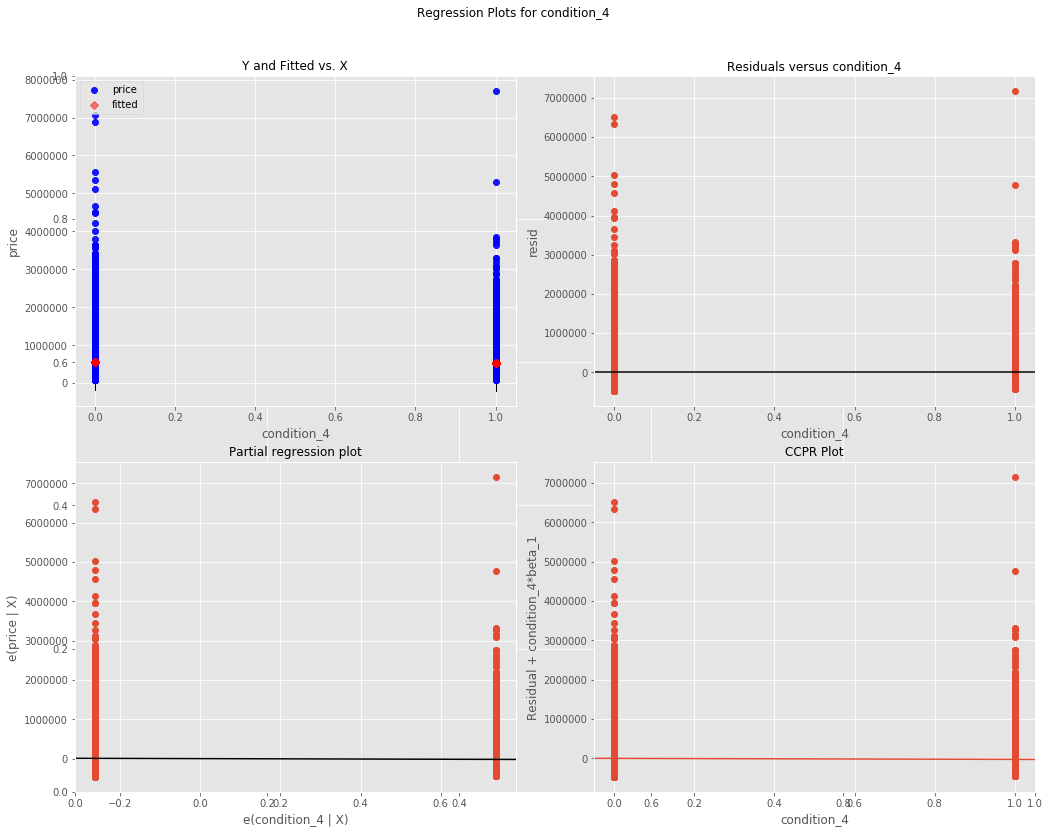

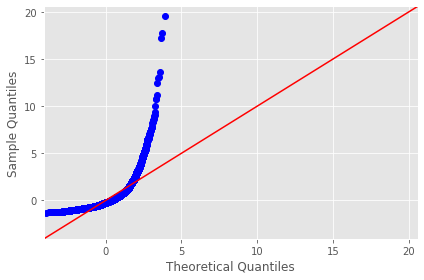

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~year_sold_2015
-------------------------------------------------------------------------------------


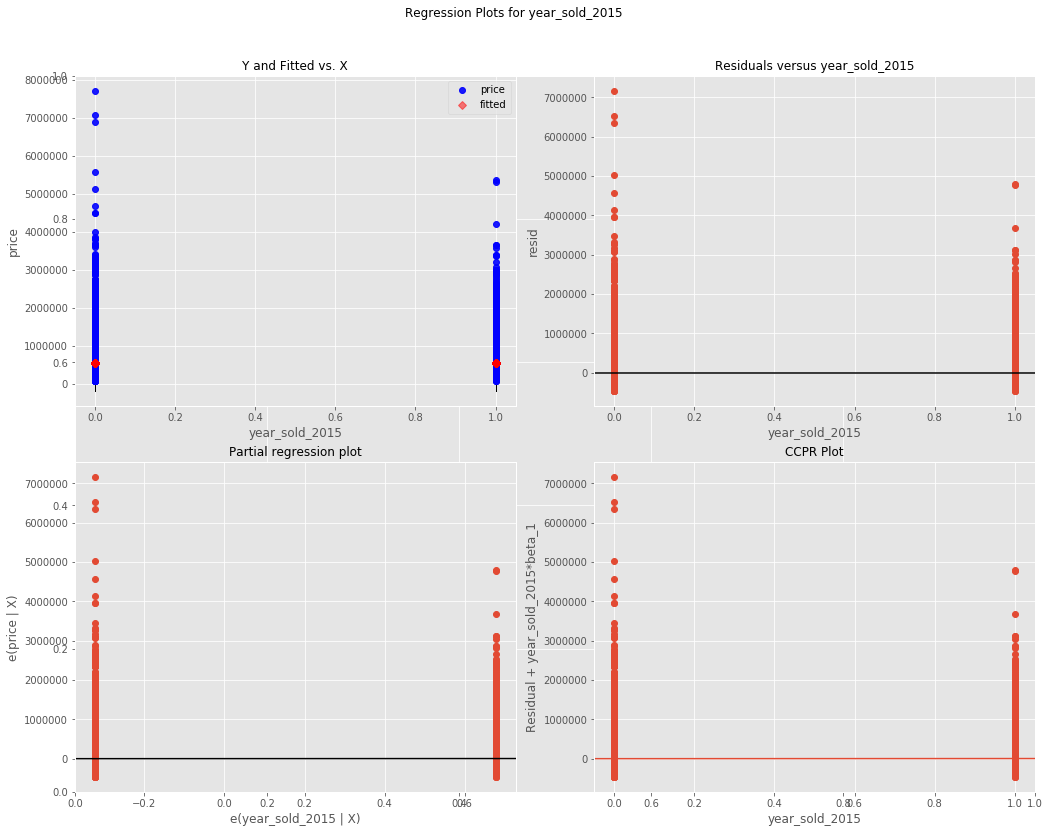

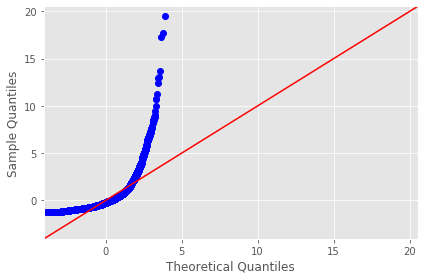

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_35
-------------------------------------------------------------------------------------


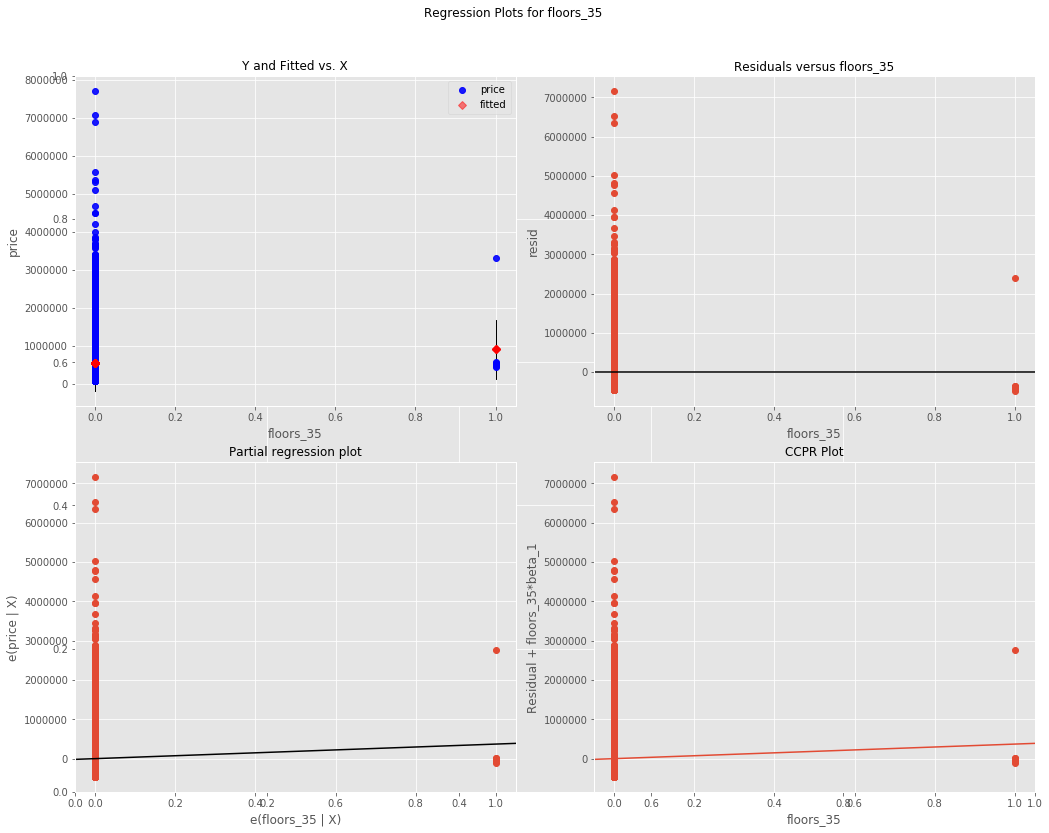

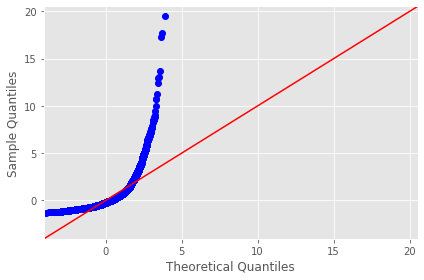

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_13
-------------------------------------------------------------------------------------


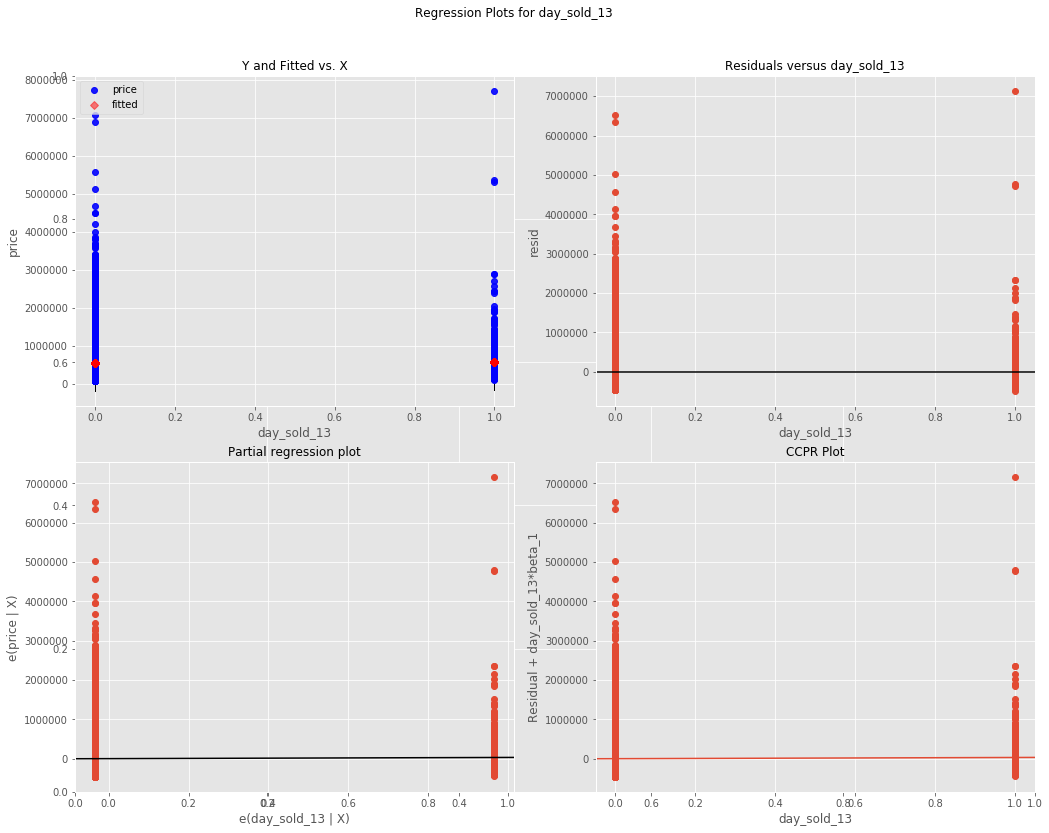

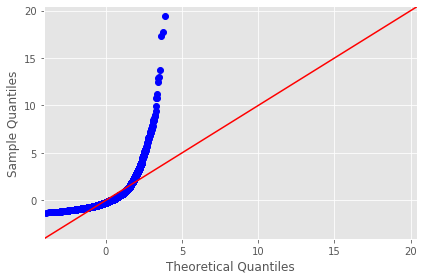

In [56]:
# evaluate residuals to check assumptions
dataset = pd.concat([y, X], axis=1)
results = []
y = 'price'
for idx, column in enumerate(dataset.columns):
    print (f"KC Housing DataSet - Regression Analysis and Diagnostics for log_price~{column}")
    print ("-------------------------------------------------------------------------------------")

    f = f'{y}~{column}'
    model = smf.ols(formula=f, data=dataset).fit()
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [57]:
# store results in dataframe to make future comparison easy
baseline_results = pd.DataFrame(results, columns=['ind_var', 
                                                  'r_squared', 
                                                  'intercept', 
                                                  'slope', 
                                                  'p-value', 
                                                  'normality (JB)'])

In [58]:
baseline_results

ind_var  r_squared     intercept         slope       p-value  \
0            price   1.000000 -2.310117e-10  1.000000e+00  0.000000e+00   
1     waterfront_1   0.069858  5.322862e+05  1.184929e+06  0.000000e+00   
2      sqft_living   0.492688 -4.398889e+04  2.808630e+02  0.000000e+00   
3             view   0.154840  4.962148e+05  1.890458e+05  0.000000e+00   
4         bedrooms   0.095350  1.271995e+05  1.224644e+05  0.000000e+00   
5      condition_5   0.003310  5.341169e+05  7.846082e+04  2.645305e-17   
6        floors_15   0.000253  5.384776e+05  2.056729e+04  1.948427e-02   
7        floors_30   0.000401  5.390406e+05  4.439325e+04  3.233270e-03   
8        floors_25   0.015091  5.363856e+05  5.246353e+05  2.182999e-73   
9      condition_4   0.000946  5.470441e+05 -2.566967e+04  6.152950e-06   
10  year_sold_2015   0.000014  5.393509e+05  2.928094e+03  5.838927e-01   
11       floors_35   0.000329  5.401766e+05  3.700376e+05  7.706358e-03   
12     day_sold_13   0.000228  5.392511e+05  3.051099e+04  2.639912e-02   

    normality (JB)  
0     1.801424e+06  
1     9.097165e+05  
2     5.426626e+05  
3     1.077904e+06  
4     1.195105e+06  
5     1.147485e+06  
6     1.135909e+06  
7     1.134694e+06  
8     1.056600e+06  
9     1.136385e+06  
10    1.131923e+06  
11    1.129138e+06  
12    1.122112e+06

In [59]:
# q-q plots of baseline are looking terrible - - assumptions not close 
# to being met on normality of residuals - - further preprocess to try and improve results
# start with log-transforming price

In [60]:
# Model 2 #

In [61]:
# revert back to clean data and try to improve results
# will start with adjusting price distribution
# two different transformations i want to try - - (log and box cox)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

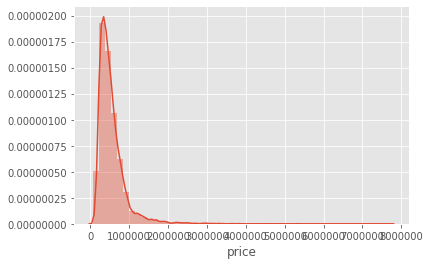

In [62]:
# re-evaluate price
sns.distplot(clean_data['price'])

In [63]:
# there are a significant number of outliers - - right skew
# would benefit from a log transformation as it looks 
# log normally distributed
clean_data['log_price'] = np.log(clean_data['price'])

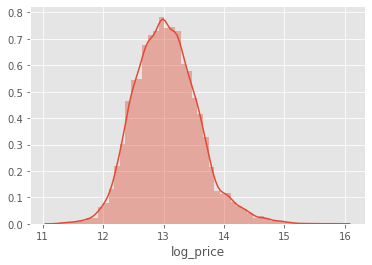

In [64]:
# replot to see if any improvement
sns.distplot(clean_data['log_price'])

In [65]:
# looking significantly more normally distributed

In [66]:
clean_data['price_boxcox'], fitted_lamba = stats.boxcox(x=clean_data['price'])

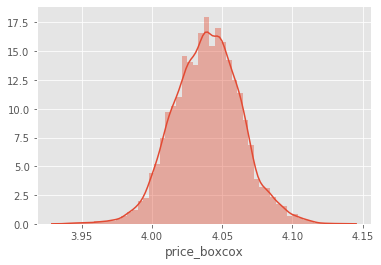

In [67]:
# plot boxcox transformation
sns.distplot(clean_data['price_boxcox'])

In [68]:
lambda_string = f'Lambda value used for transformation: {round(fitted_lamba,2)}'
print(lambda_string)

Lambda value used for transformation: -0.24


In [69]:
# will compare box cox power transformation vs. log transformation
# lambda value of -0.24 implies that optimally selected
# is slightly different from log as log would be a lambda of 0

In [70]:
# relook at histograms of all variables
# drop price
preprocessed = clean_data.drop('price', axis=1)

In [71]:
# plot cont predictors against log_price
# plot_relationship(data=preprocessed, 
#                   y_vars=['log_price'], 
#                   x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['log_price'], 
#                   x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['log_price'], 
#                   x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [72]:
# plot cont predictors against price_boxcox
# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [73]:
# variables are looking more linear than when plotted against non
# transformed price - - continue with other steps, run regression
# and see if assumptions are looking better on residual normality
# drop clear non-linear columns
preprocessed = preprocessed.drop(['sqft_lot', 'yr_built', 
                                  'yr_renovated','zipcode', 
                                  'lat', 'long', 'sqft_lot15'], axis=1)

In [74]:
# we've now dropped non-linear
# identify and remove any multi-collinearity
data_pred = preprocessed.drop(['log_price', 'price_boxcox'], axis=1)
correlated_predictors = multi_collinearity(data_pred, 0.75)
correlated_predictors

cc
pairs                                 
(sqft_above, sqft_living)     0.876448
(month_sold, year_sold)       0.782325
(sqft_living, grade)          0.762779
(sqft_living, sqft_living15)  0.756402
(sqft_above, grade)           0.756073
(sqft_living, bathrooms)      0.755758

In [75]:
# similar to before we will drop sqft_above, grade, sqft_living15, bathrooms
# as all correlated with sqft_living - - also going to drop year_sold
# this time around as knowing which month, if any, is correlated with 
# higher sales price - - only two years of data so 2014 vs. 2015
# isn't super helpful, especially going forward
preprocessed = preprocessed.drop(['sqft_above', 'grade',
                                  'sqft_living15', 'bathrooms',
                                  'year_sold'], axis=1)

In [76]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   sqft_living    21597 non-null  int64  
 2   floors         21597 non-null  float64
 3   waterfront     21597 non-null  float64
 4   view           21597 non-null  float64
 5   condition      21597 non-null  int64  
 6   sqft_basement  21597 non-null  float64
 7   month_sold     21597 non-null  int64  
 8   day_sold       21597 non-null  int64  
 9   log_price      21597 non-null  float64
 10  price_boxcox   21597 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 1.8 MB


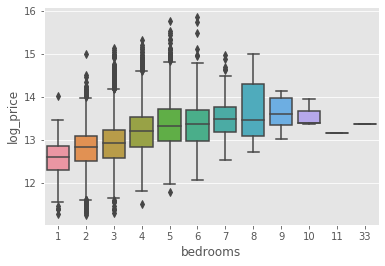

In [77]:
# evaluate and handle categorical columns
# check for ordinal relationships and identify OHE where necessary
# first compare to log_price

# bedrooms
sns.boxplot(x='bedrooms', y='log_price', data=preprocessed);

In [78]:
# log transforming price has improved this relationship
# ordinal - - leave as a single column

In [79]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   sqft_living    21597 non-null  int64  
 2   floors         21597 non-null  float64
 3   waterfront     21597 non-null  float64
 4   view           21597 non-null  float64
 5   condition      21597 non-null  int64  
 6   sqft_basement  21597 non-null  float64
 7   month_sold     21597 non-null  int64  
 8   day_sold       21597 non-null  int64  
 9   log_price      21597 non-null  float64
 10  price_boxcox   21597 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 1.8 MB


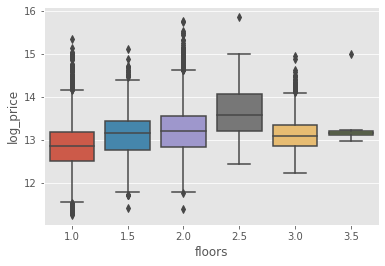

In [80]:
# floors
sns.boxplot(x='floors', y='log_price', data=preprocessed);

In [81]:
# no real ordinal relationship - - scale by 10 and convert to int
preprocessed['floors10'] = preprocessed['floors'] * 10
preprocessed['floors10'] = preprocessed['floors10'].astype('int64')

# add to list to be one hot encoded
ohe_list = []
ohe_list.append('floors_10')

In [82]:
# drop floors
preprocessed.drop('floors', axis=1, inplace=True)

In [83]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   sqft_living    21597 non-null  int64  
 2   waterfront     21597 non-null  float64
 3   view           21597 non-null  float64
 4   condition      21597 non-null  int64  
 5   sqft_basement  21597 non-null  float64
 6   month_sold     21597 non-null  int64  
 7   day_sold       21597 non-null  int64  
 8   log_price      21597 non-null  float64
 9   price_boxcox   21597 non-null  float64
 10  floors10       21597 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 1.8 MB


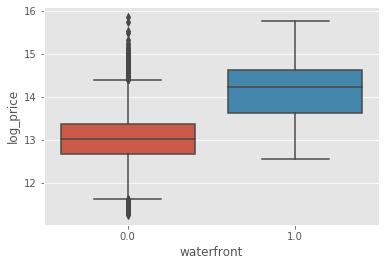

In [84]:
# waterfront
sns.boxplot(x='waterfront', y='log_price', data=preprocessed);

In [85]:
# convert to int and add to ohe_list
preprocessed['waterfront_clean'] = preprocessed['waterfront'].astype('int64')
ohe_list.append('waterfront_clean')

# drop waterfront
preprocessed.drop(['waterfront'], axis=1, inplace=True)

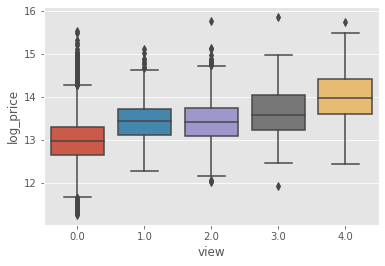

In [86]:
# view
sns.boxplot(x='view', y='log_price', data=preprocessed);

In [87]:
# ordinal relationship, leave as single column

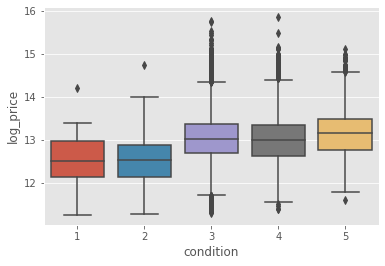

In [88]:
# condition
sns.boxplot(x='condition', y='log_price', data=preprocessed);

In [89]:
# not a super clear ordinal relationship, add to ohe_list
ohe_list.append('condition')

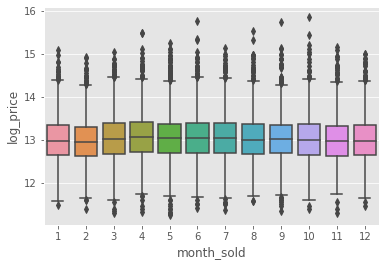

In [90]:
# month_sold
sns.boxplot(x='month_sold', y='log_price', data=preprocessed);

In [91]:
# doesn't appear to be much of a relationship
# potentially higher prices in month 3 - 5
# add to ohe_list
ohe_list.append('month_sold')

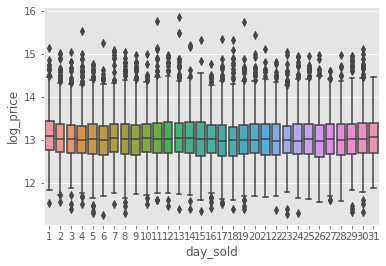

In [92]:
# day_sold
sns.boxplot(x='day_sold', y='log_price', data=preprocessed);

In [93]:
# ohe encode
ohe_list.append('day_sold')

In [94]:
# create dummy variables
ohe_list

['floors_10', 'waterfront_clean', 'condition', 'month_sold', 'day_sold']

In [95]:
floors_dummies = pd.get_dummies(preprocessed['floors10'],
                                prefix='floors',
                                drop_first=True)

waterfront_dummies = pd.get_dummies(preprocessed['waterfront_clean'],
                                    prefix='waterfront',
                                    drop_first=True)

condition_dummies = pd.get_dummies(preprocessed['condition'],
                                   prefix='condition',
                                   drop_first=True)

month_sold_dummies = pd.get_dummies(preprocessed['month_sold'],
                                    prefix='month_sold',
                                    drop_first=True)

day_sold_dummies = pd.get_dummies(preprocessed['day_sold'],
                                  prefix='day_sold',
                                  drop_first=True)

In [96]:
# drop columns
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          21597 non-null  int64  
 1   sqft_living       21597 non-null  int64  
 2   view              21597 non-null  float64
 3   condition         21597 non-null  int64  
 4   sqft_basement     21597 non-null  float64
 5   month_sold        21597 non-null  int64  
 6   day_sold          21597 non-null  int64  
 7   log_price         21597 non-null  float64
 8   price_boxcox      21597 non-null  float64
 9   floors10          21597 non-null  int64  
 10  waterfront_clean  21597 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 1.8 MB


In [97]:
# drop columns
data_fin = preprocessed.drop(['day_sold', 
                              'month_sold',
                              'condition', 
                              'waterfront_clean',
                              'floors10',
                              'price_boxcox'], axis=1)

In [98]:
data_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   sqft_living    21597 non-null  int64  
 2   view           21597 non-null  float64
 3   sqft_basement  21597 non-null  float64
 4   log_price      21597 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 843.8 KB


In [99]:
# concat with dummies
data_fin = pd.concat([data_fin,
                      day_sold_dummies,
                      month_sold_dummies,
                      condition_dummies,
                      waterfront_dummies,
                      floors_dummies], axis=1)

In [100]:
# run stepwise selection to select features
y = data_fin['log_price']
X = data_fin.drop(['log_price'], axis=1)
result = stepwise_selection(X, y, verbose=True)

Add  sqft_basement                  with p-value 0.0


/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  bedrooms                       with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  view                           with p-value 4.64662e-204
Drop sqft_basement                  with p-value 0.25639
Add  floors_15                      with p-value 1.75167e-64
Add  floors_30                      with p-value 1.76482e-55
Add  condition_5                    with p-value 3.32601e-44
Add  waterfront_1                   with p-value 6.02535e-19
Add  floors_20                      with p-value 2.18952e-18
Add  condition_4                    with p-value 1.43025e-18
Add  floors_25                      with p-value 3.931e-18
Add  month_sold_4                   with p-value 1.04434e-16
Add  condition_3                    with p-value 5.4092e-16
Add  month_sold_3                   with p-value 2.42202e-07
Add  sqft_basement                  with p-value 0.000245709
Add  month_sold_5                   with p-value 0.00105937
Add  month_sold_6                   with p-valu

In [101]:
result

['bedrooms',
 'sqft_living',
 'view',
 'floors_15',
 'floors_30',
 'condition_5',
 'waterfront_1',
 'floors_20',
 'condition_4',
 'floors_25',
 'month_sold_4',
 'condition_3',
 'month_sold_3',
 'sqft_basement',
 'month_sold_5',
 'month_sold_6',
 'day_sold_26',
 'day_sold_31']

In [102]:
# run regression with these features
X = data_fin[result]
y = data_fin['log_price']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

In [103]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     1395.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:39:19   Log-Likelihood:                -8455.7
No. Observations:               21597   AIC:                         1.695e+04
Df Residuals:                   21578   BIC:                         1.710e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0661      0.027    452.900      0.000      12.014      12.118
bedrooms         -0.0452      0.003    -13.763      0.000      -0.052      -0.039
sqft_living       0.0004    4.2e-06     91.105      0.000       0.000       0.000
view              0.0906      0.004     24.839      0.000       0.083       0.098
floors_15         0.1717      0.009     18.878      0.000       0.154       0.190
floors_30         0.2923      0.015     19.109      0.000       0.262       0.322
condition_5       0.3655      0.027     13.562      0.000       0.313       0.418
waterfront_1      0.2876      0.032      8.932      0.000       0.224       0.351
floors_20         0.0822      0.007     11.816      0.000       0.069       0.096
condition_4       0.2601      0.026     10.048      0.000       0.209       0.311
floors_25         0.2623      0.029      9.057      0.000       0.206       0.319
month_sold_4      0.0773      0.008      9.388      0.000       0.061       0.093
condition_3       0.2099      0.026      8.165      0.000       0.160       0.260
month_sold_3      0.0515      0.009      5.792      0.000       0.034       0.069
sqft_basement  2.598e-05   7.28e-06      3.567      0.000    1.17e-05    4.03e-05
month_sold_5      0.0287      0.008      3.612      0.000       0.013       0.044
month_sold_6      0.0263      0.008      3.168      0.002       0.010       0.043
day_sold_26      -0.0420      0.014     -2.969      0.003      -0.070      -0.014
day_sold_31       0.0665      0.023      2.910      0.004       0.022       0.111
==============================================================================
Omnibus:                       59.182   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.707
Skew:                          -0.049   Prob(JB):                     1.63e-16
Kurtosis:                       3.267   Cond. No.                     4.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~log_price
-------------------------------------------------------------------------------------


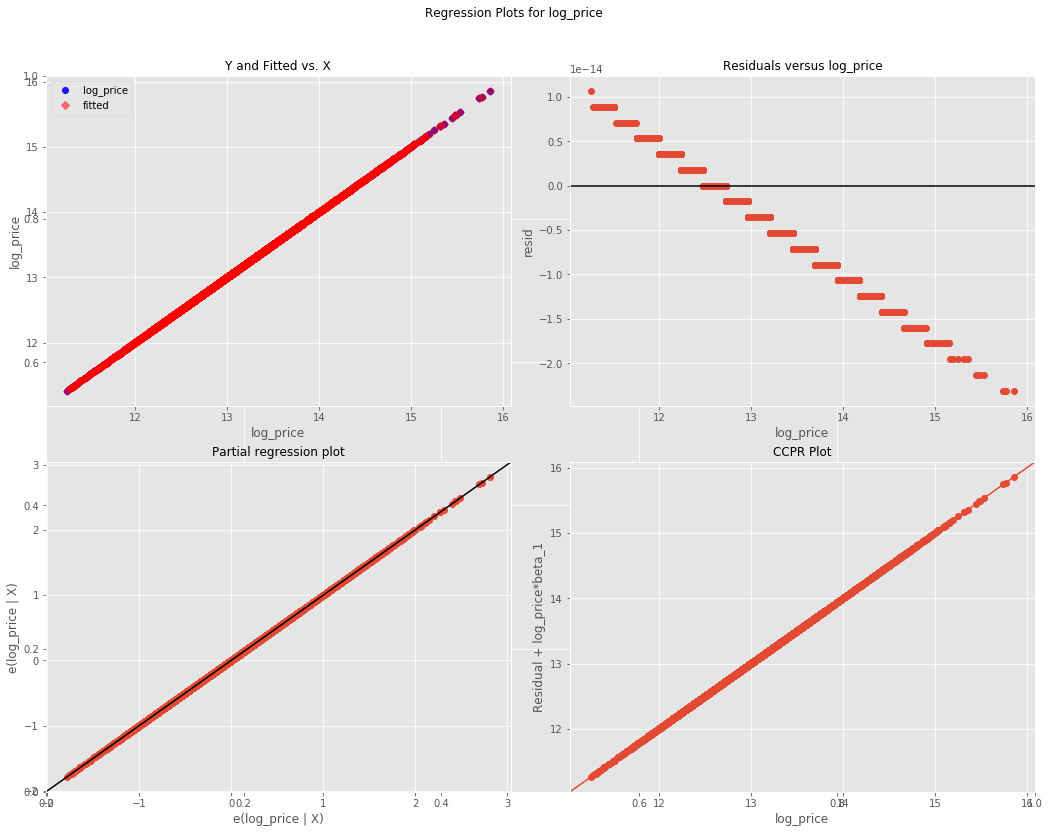

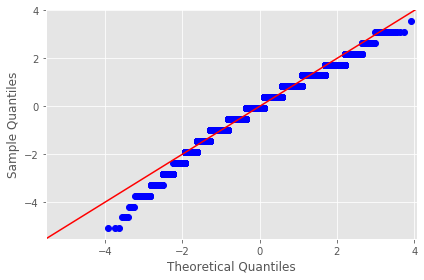

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~bedrooms
-------------------------------------------------------------------------------------


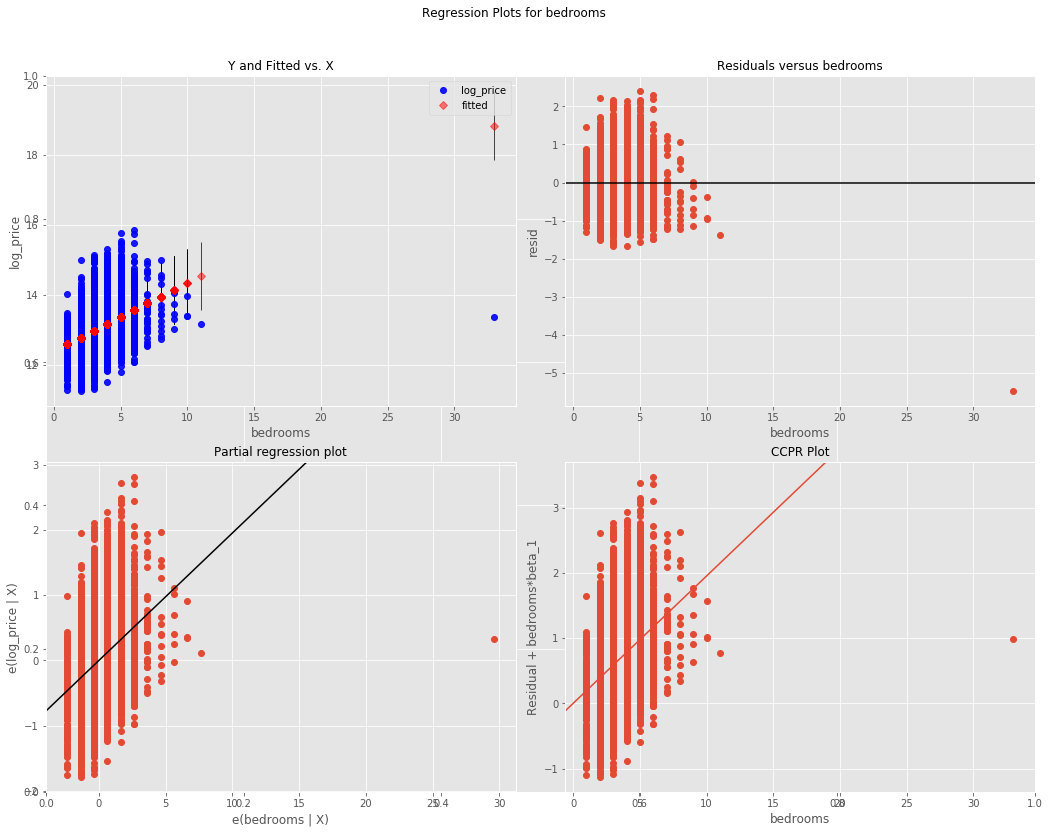

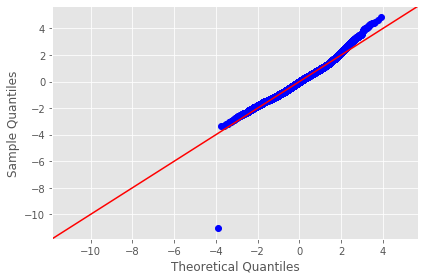

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~sqft_living
-------------------------------------------------------------------------------------


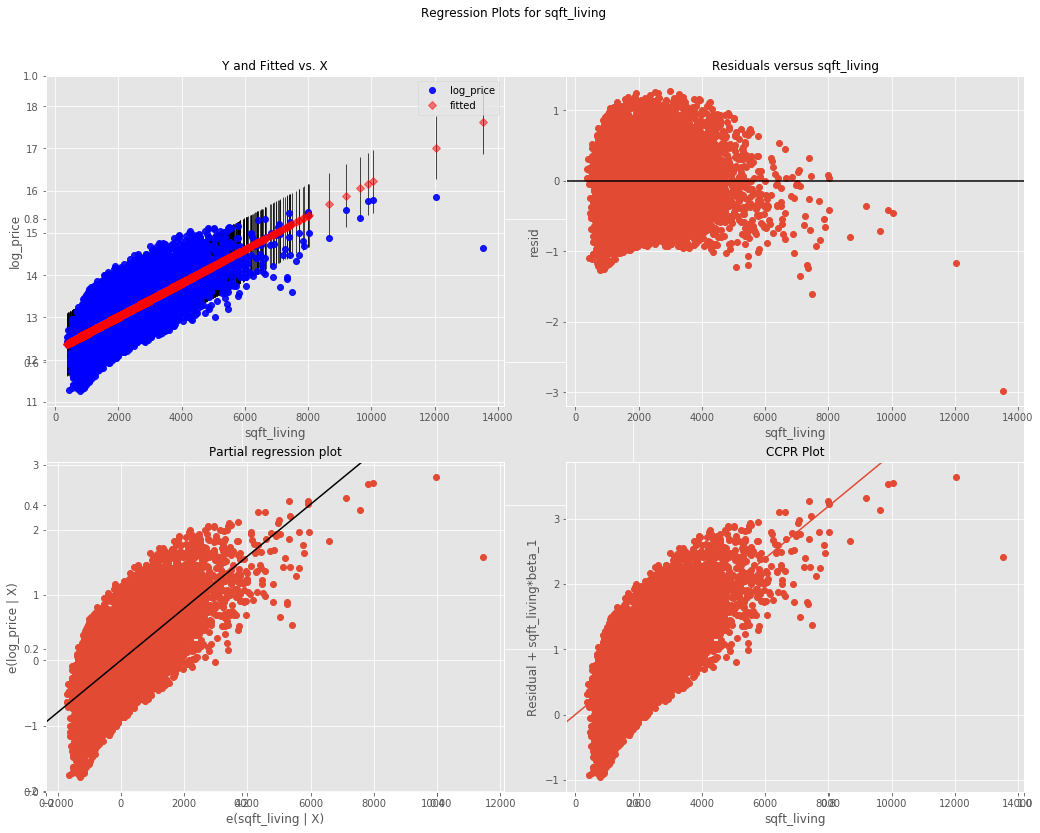

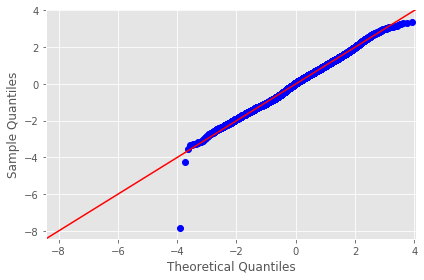

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view
-------------------------------------------------------------------------------------


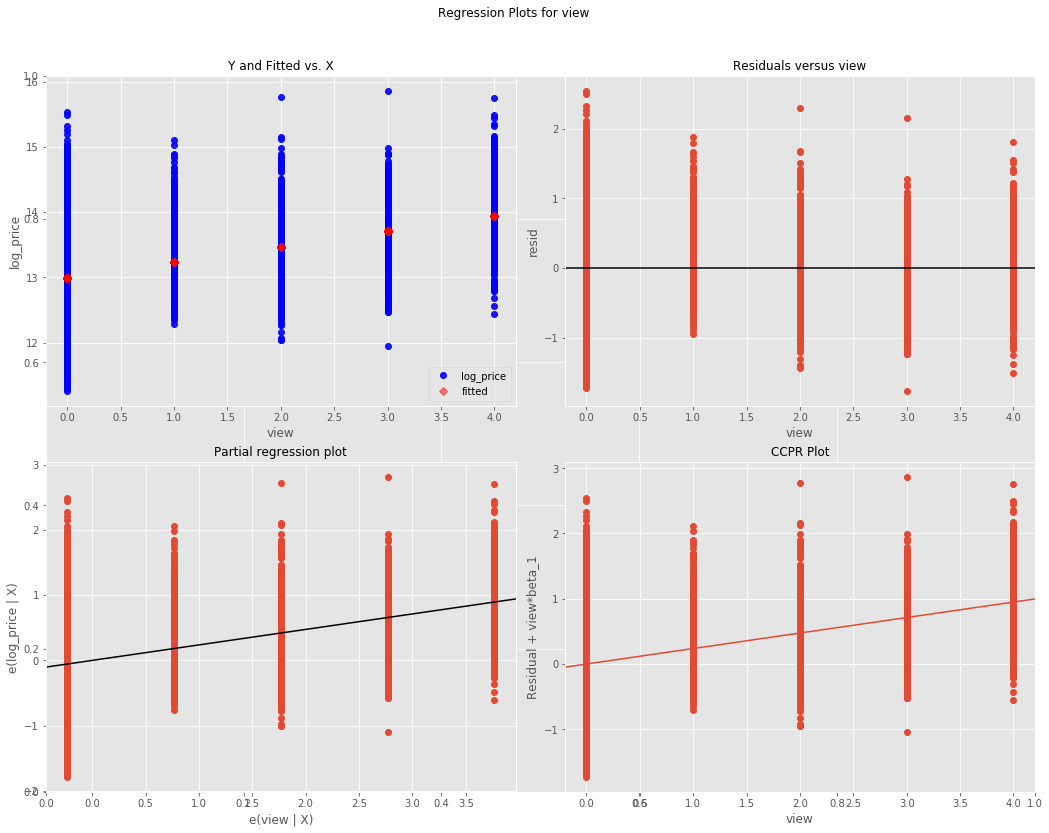

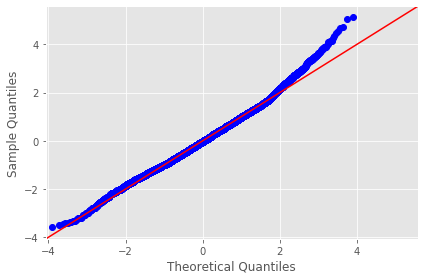

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_15
-------------------------------------------------------------------------------------


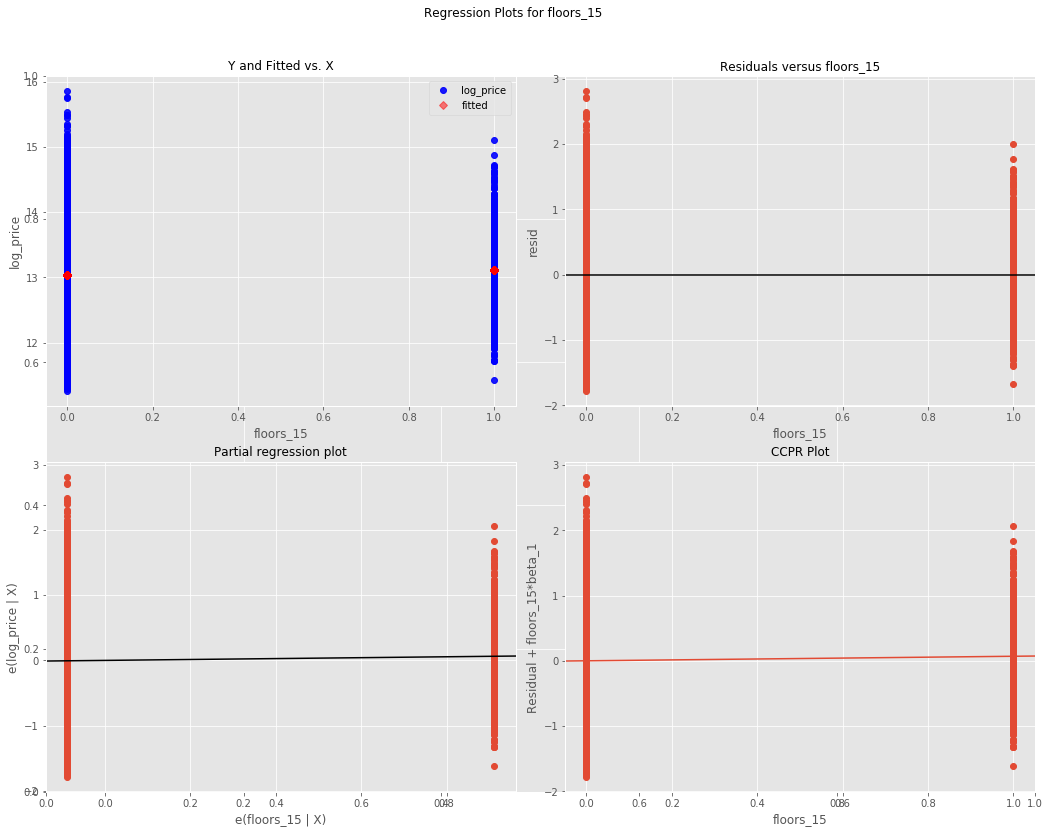

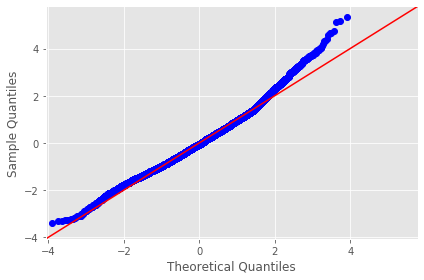

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_30
-------------------------------------------------------------------------------------


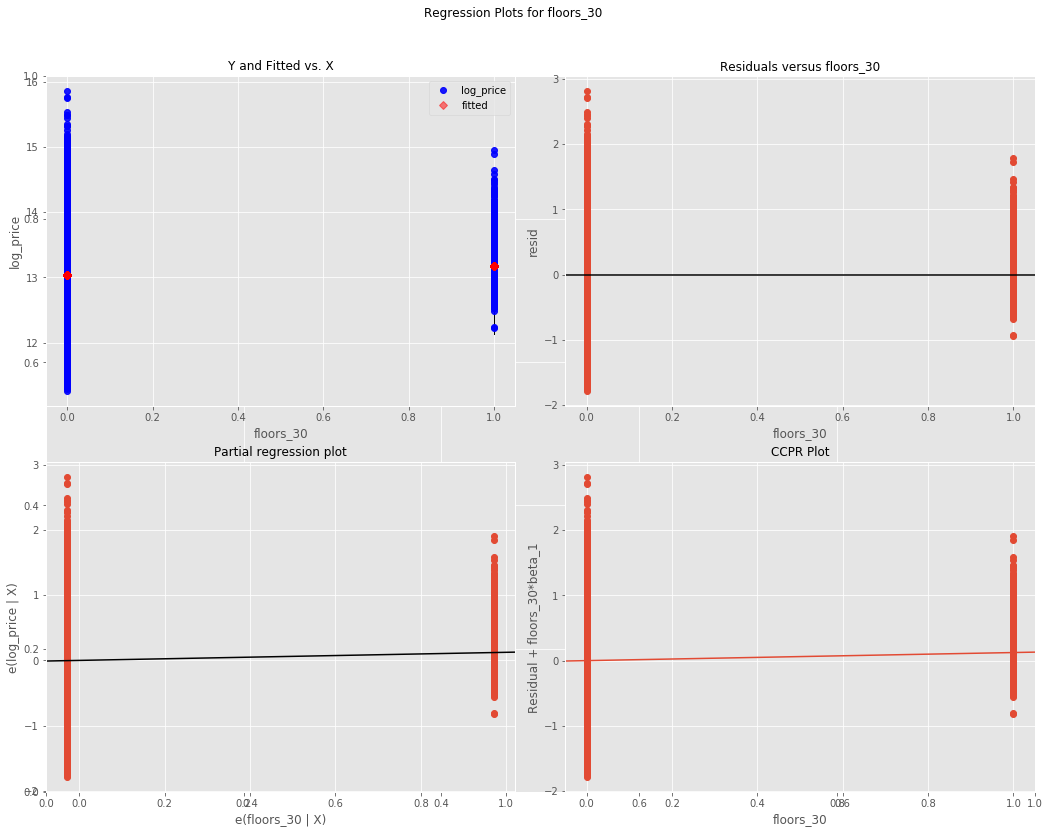

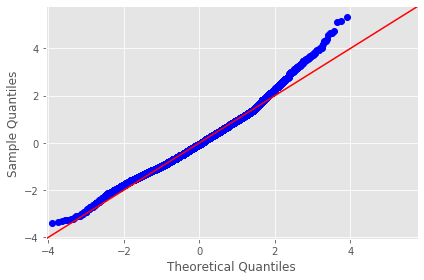

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_5
-------------------------------------------------------------------------------------


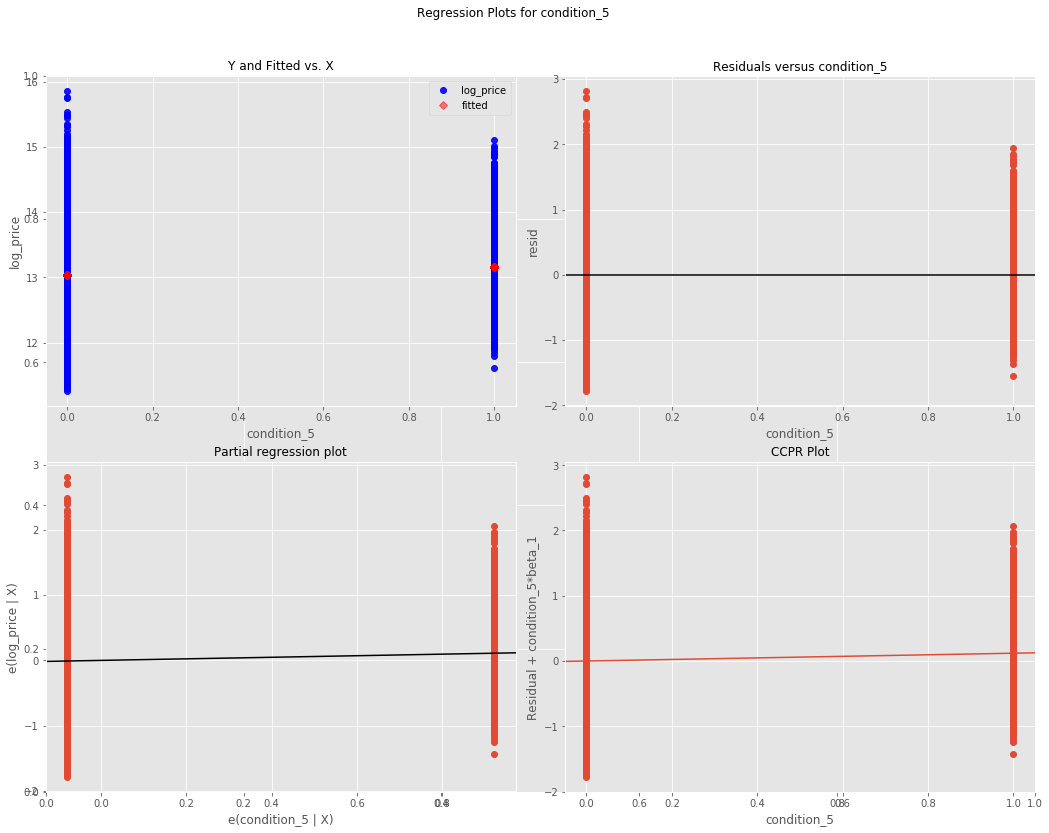

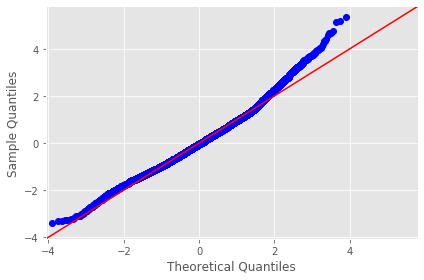

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~waterfront_1
-------------------------------------------------------------------------------------


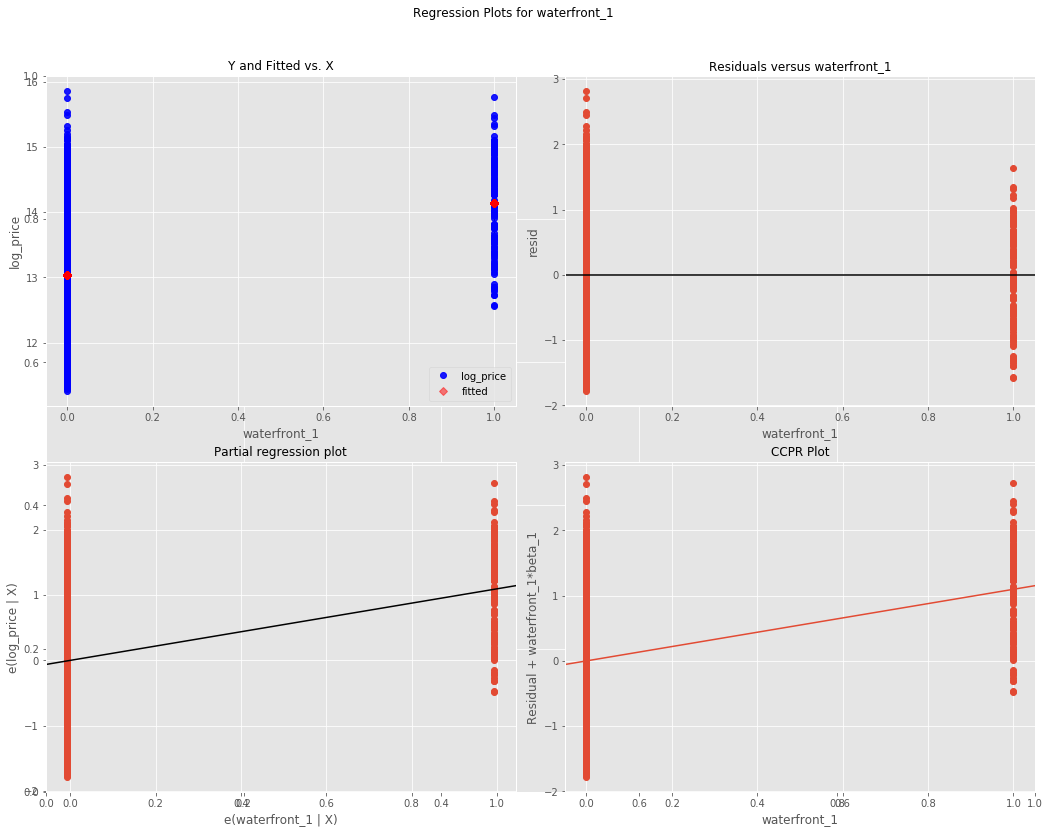

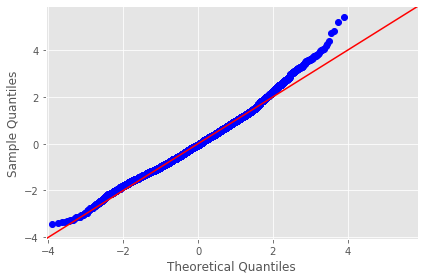

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_20
-------------------------------------------------------------------------------------


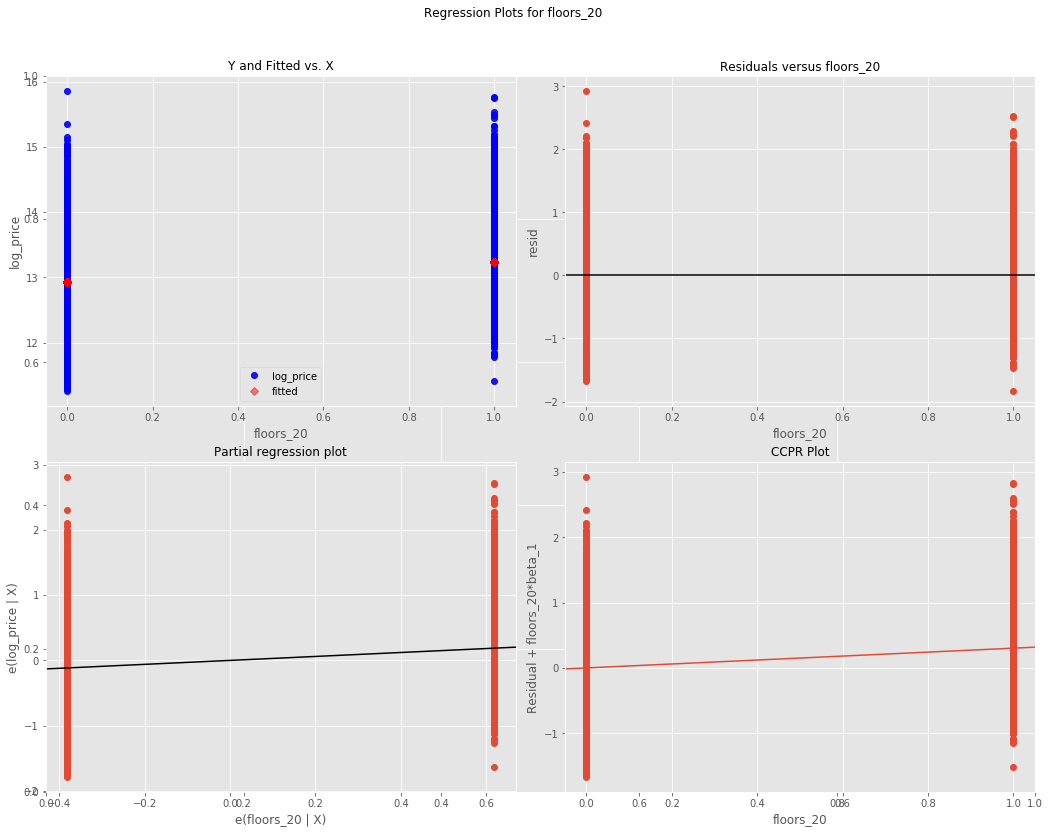

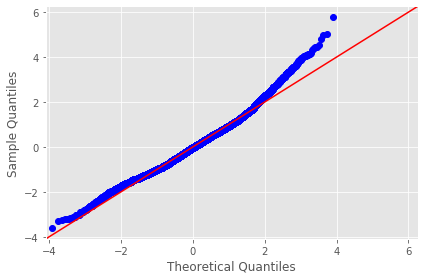

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_4
-------------------------------------------------------------------------------------


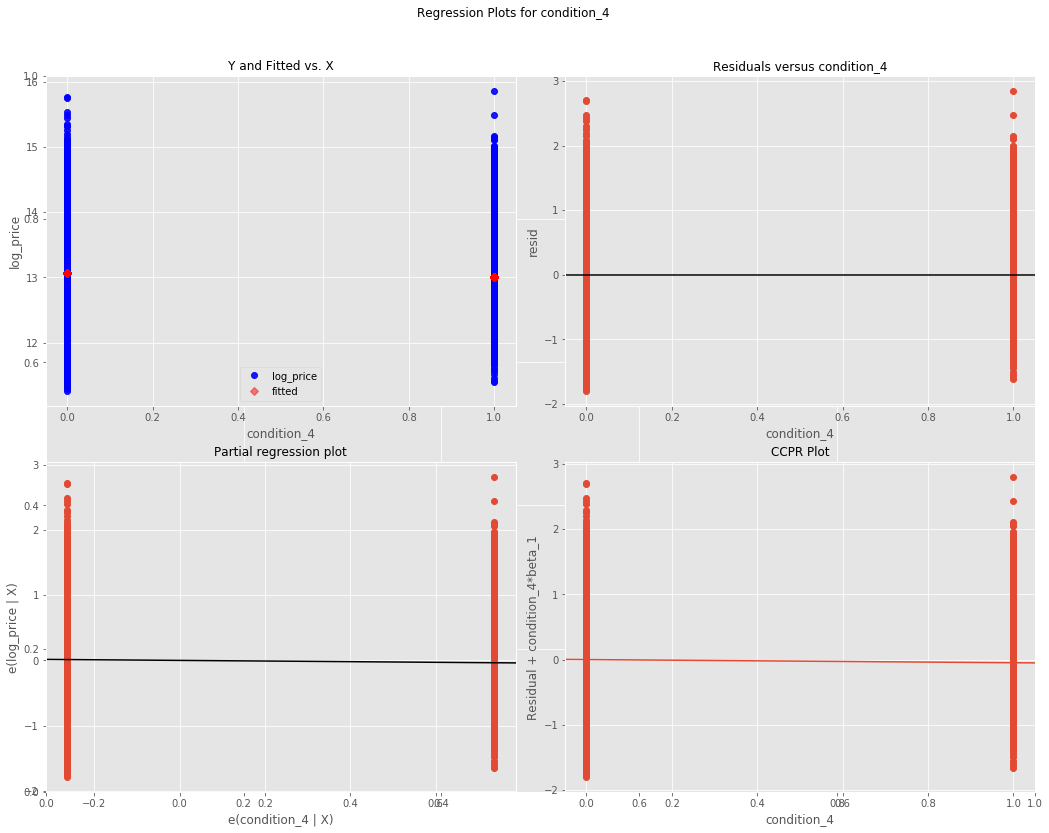

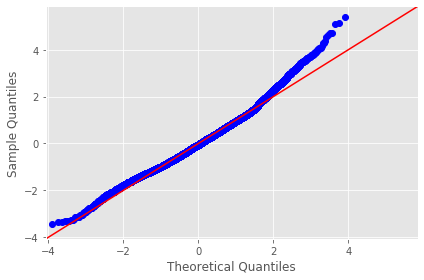

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_25
-------------------------------------------------------------------------------------


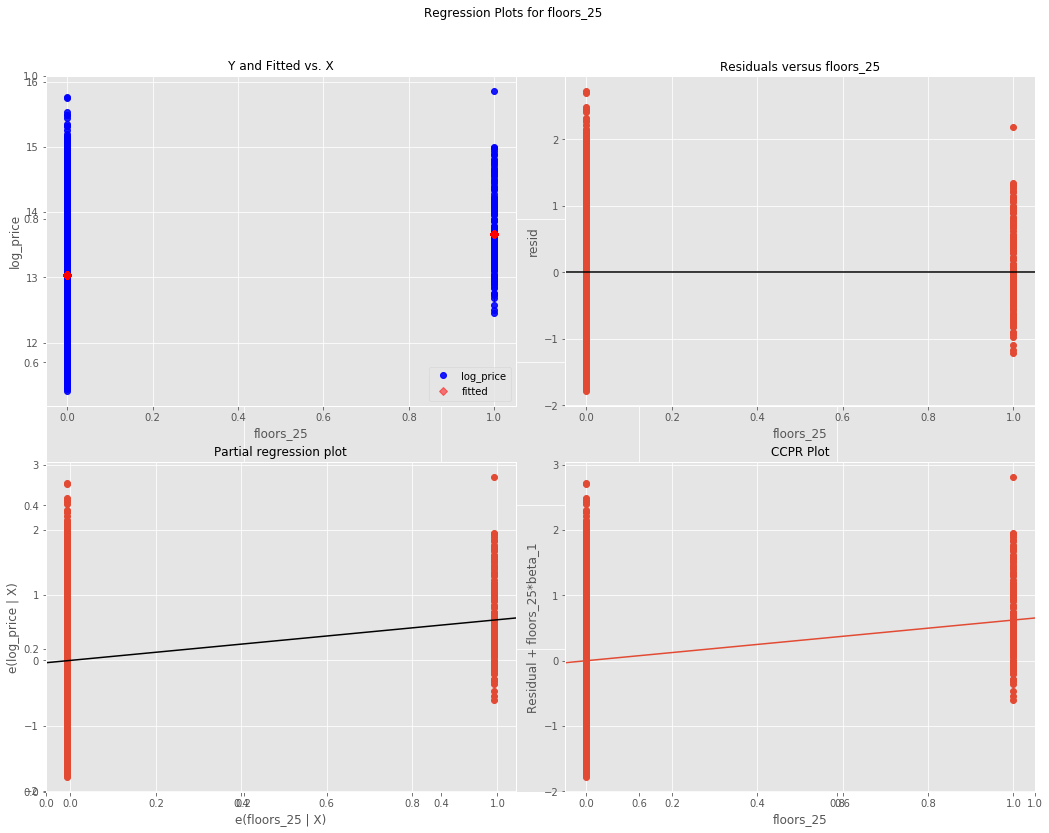

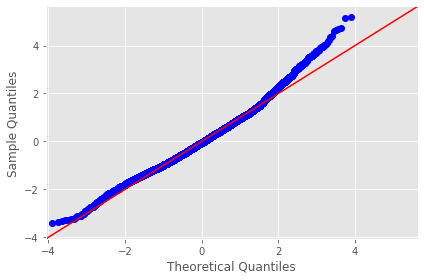

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_4
-------------------------------------------------------------------------------------


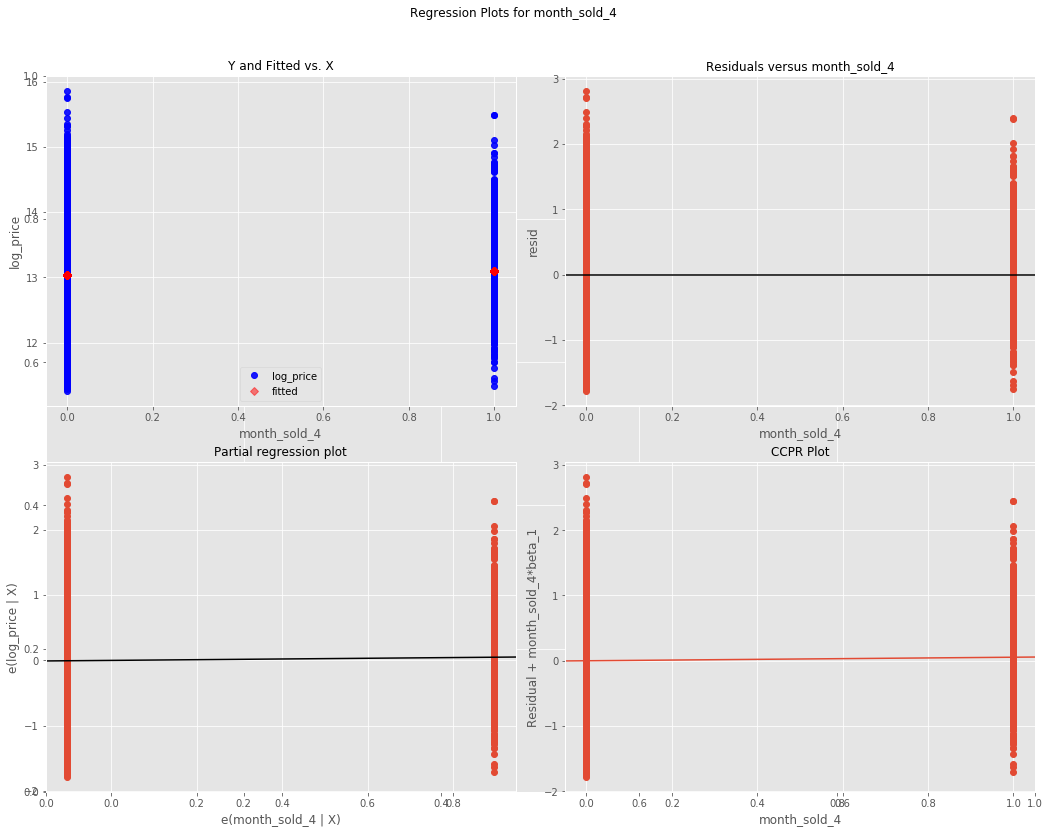

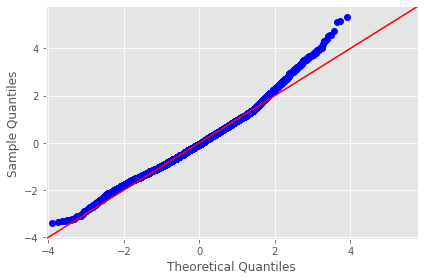

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_3
-------------------------------------------------------------------------------------


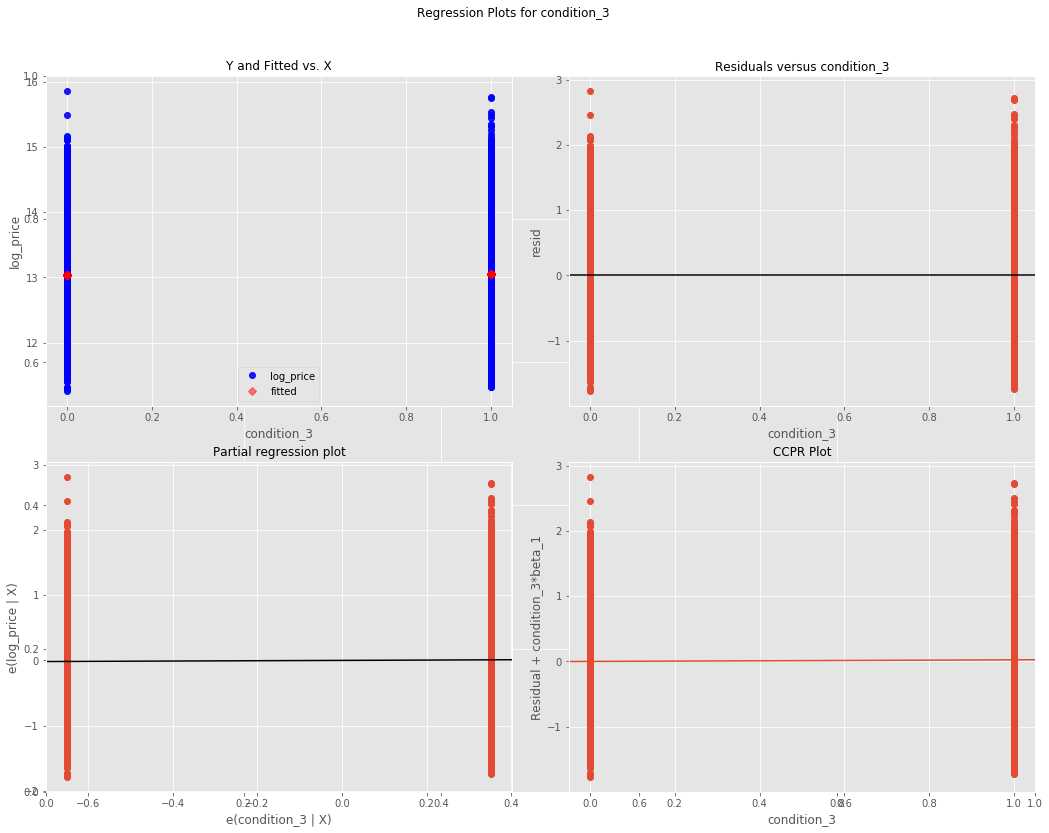

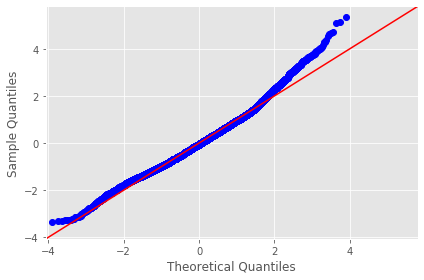

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_3
-------------------------------------------------------------------------------------


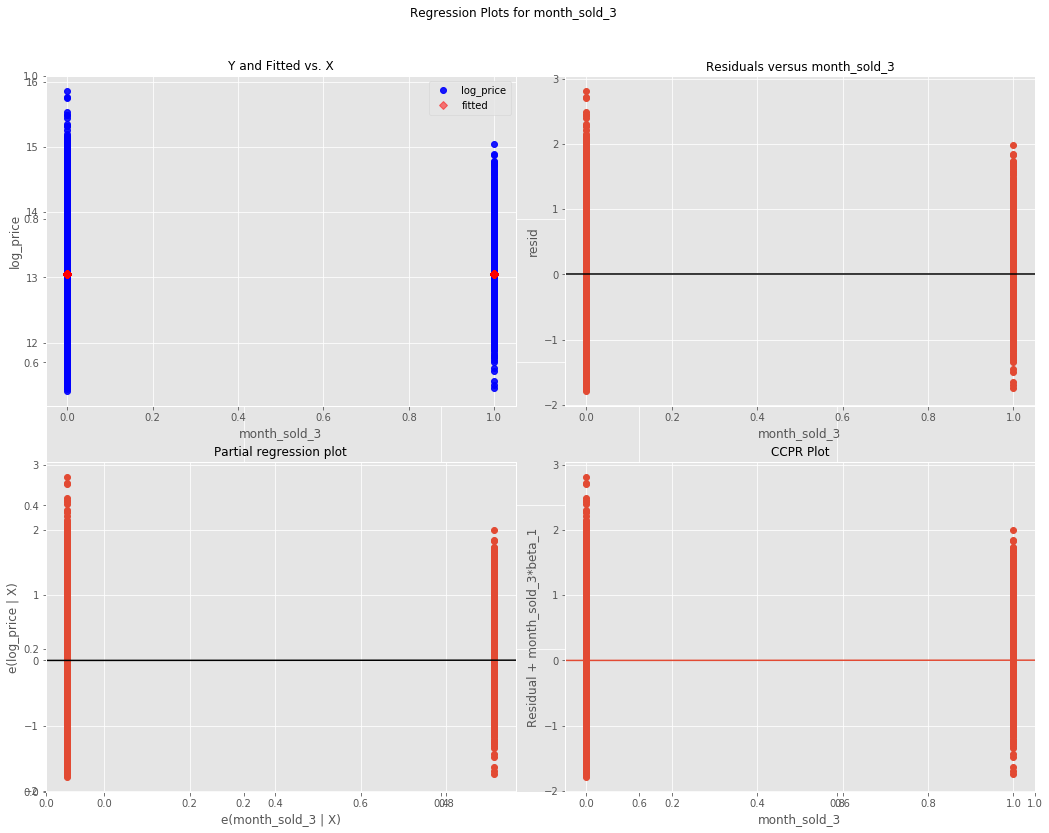

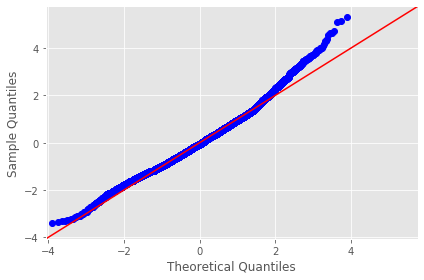

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~sqft_basement
-------------------------------------------------------------------------------------


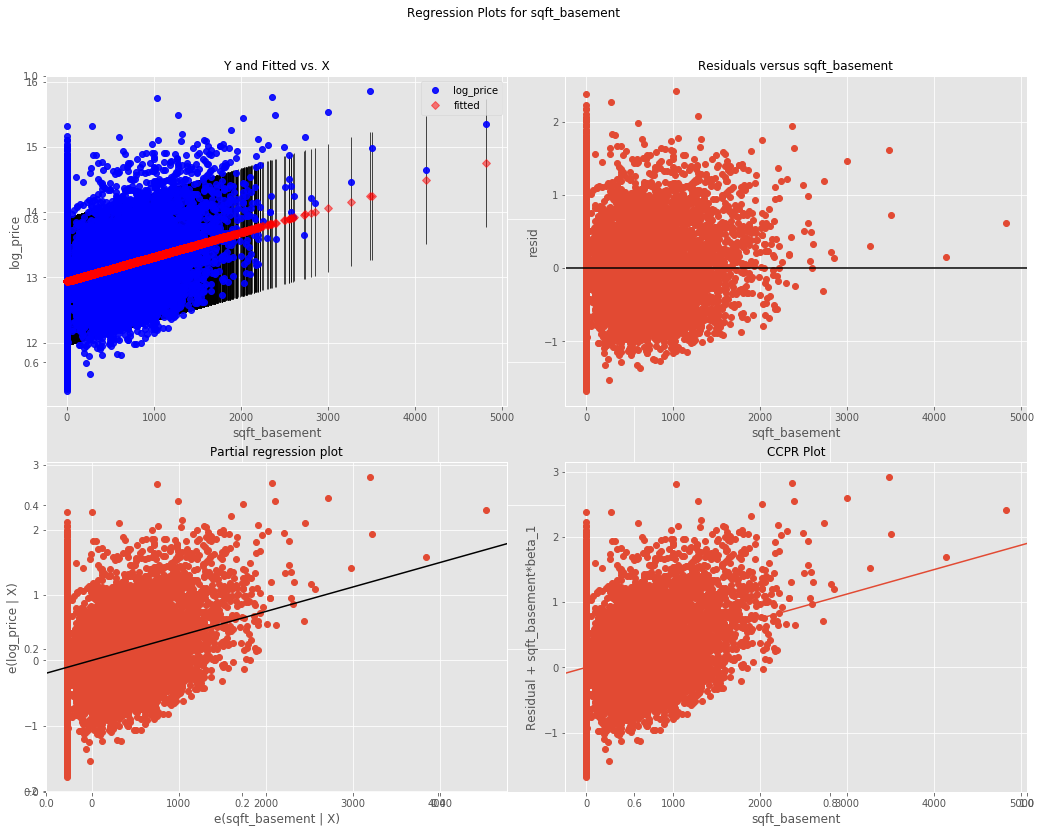

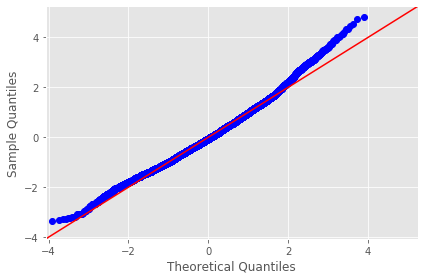

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_5
-------------------------------------------------------------------------------------


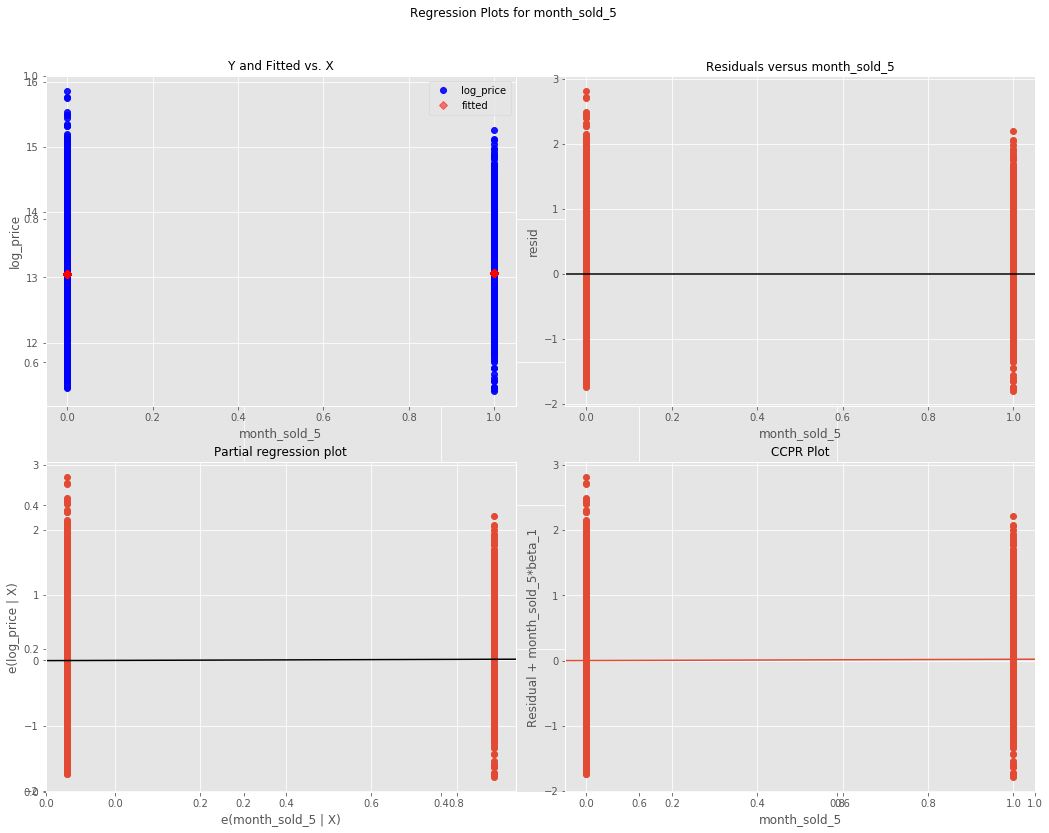

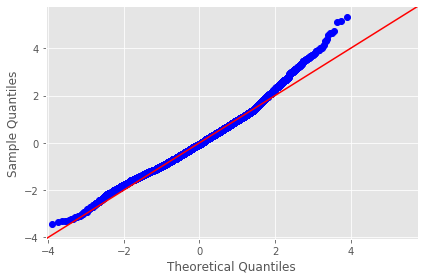

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_6
-------------------------------------------------------------------------------------


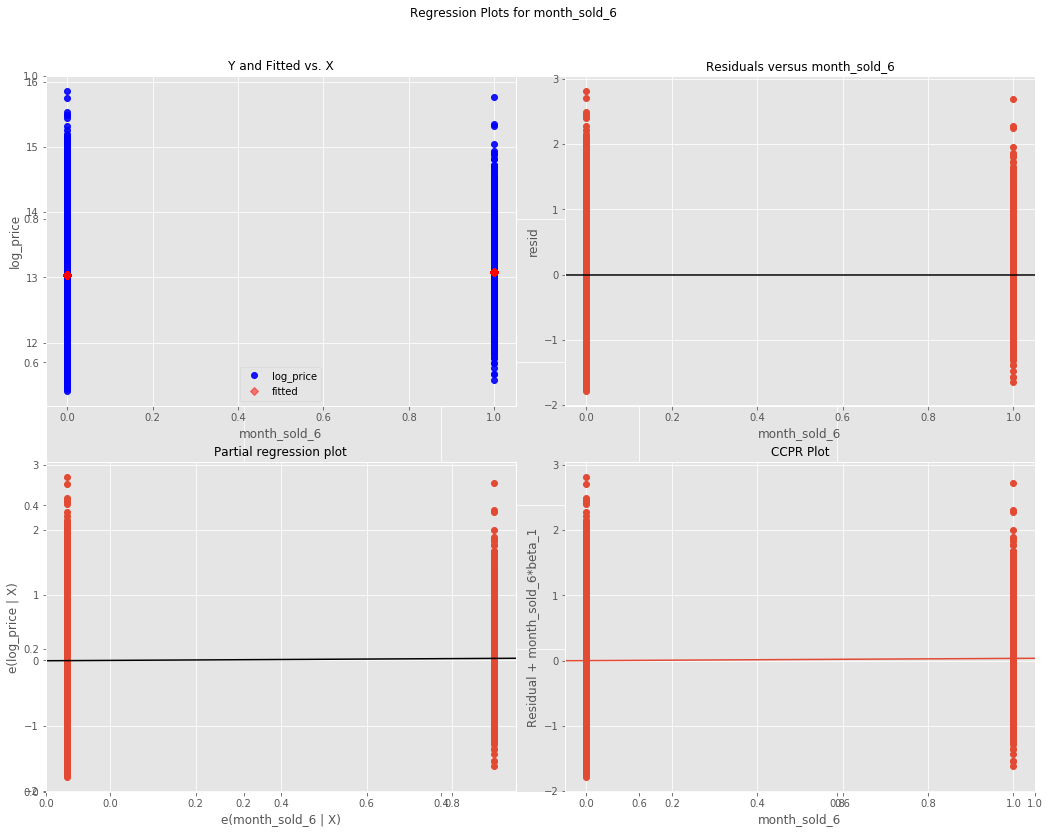

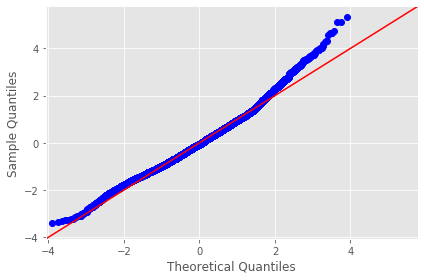

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_26
-------------------------------------------------------------------------------------


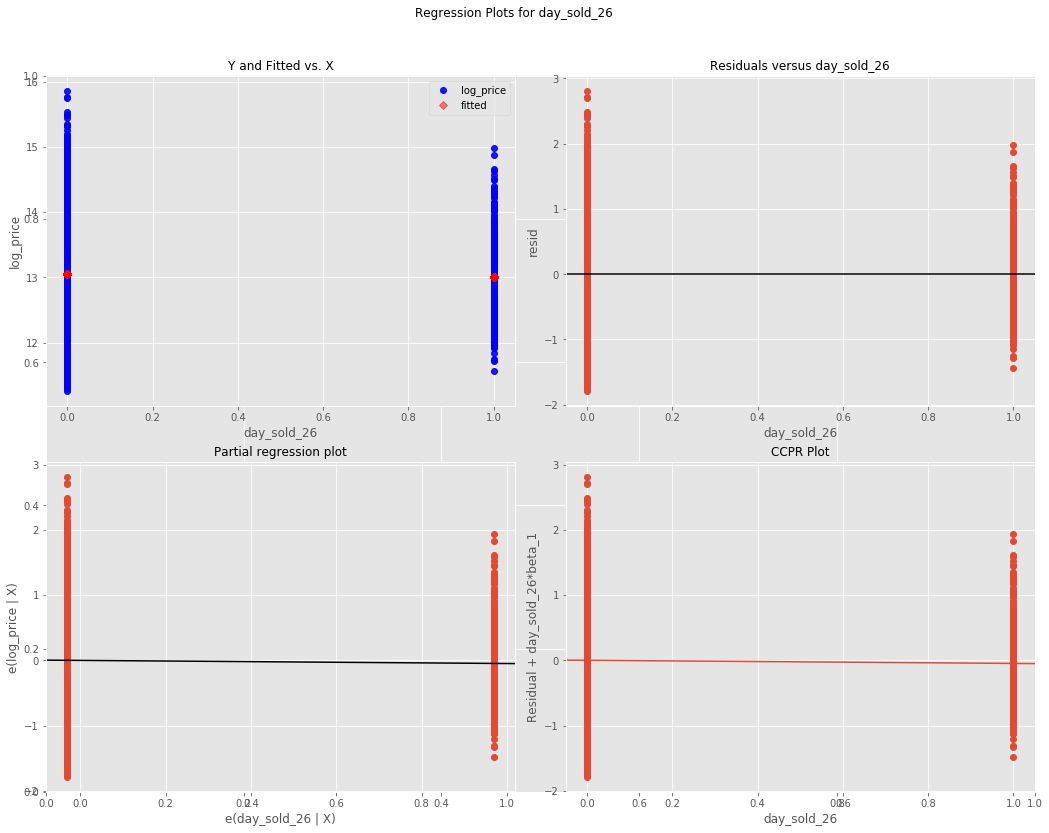

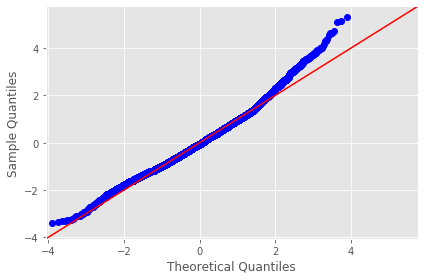

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_31
-------------------------------------------------------------------------------------


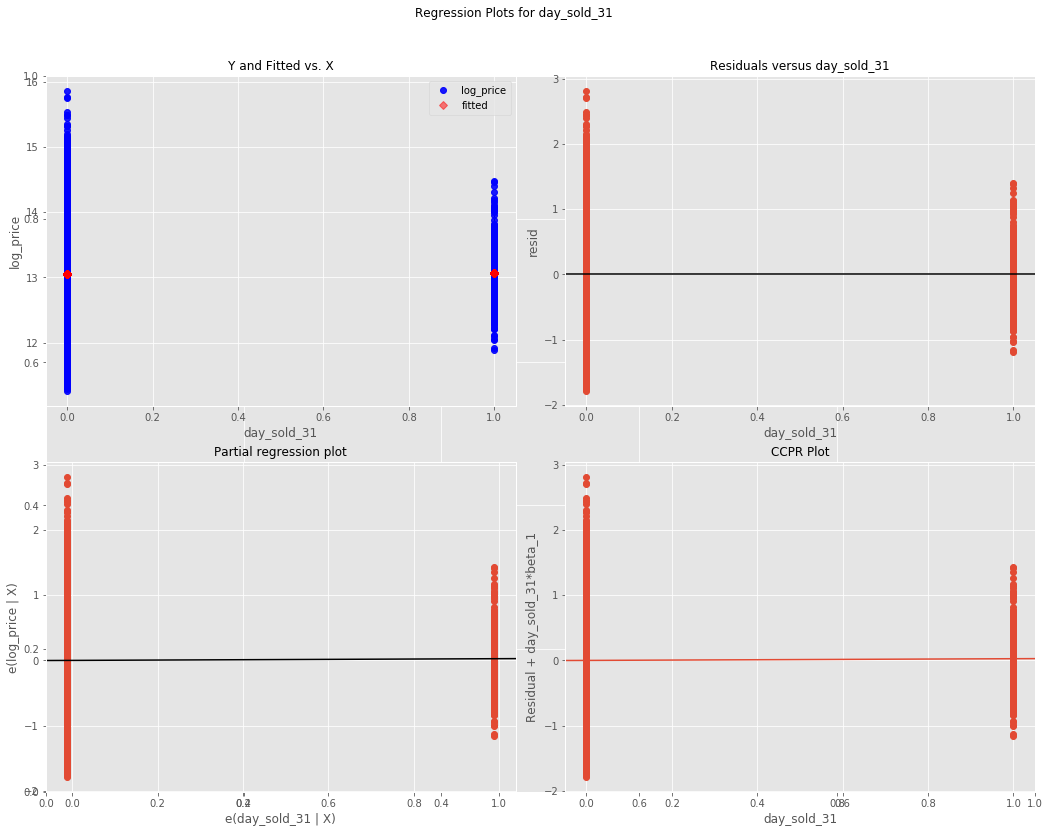

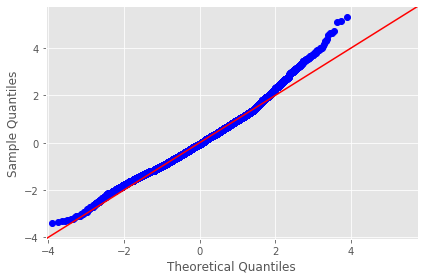

In [104]:
# evaluate residuals to check assumptions
dataset = pd.concat([y, X], axis=1)
results = []
y = 'log_price'
for idx, column in enumerate(dataset.columns):
    print (f"KC Housing DataSet - Regression Analysis and Diagnostics for log_price~{column}")
    print ("-------------------------------------------------------------------------------------")

    f = f'{y}~{column}'
    model = smf.ols(formula=f, data=dataset).fit()
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [105]:
# store results in dataframe to make future comparison easy
model_2_results = pd.DataFrame(results, columns=['ind_var', 
                                                 'r_squared', 
                                                 'intercept', 
                                                 'slope', 
                                                 'p-value', 
                                                 'normality (JB)'])

In [106]:
model_2_results

ind_var  r_squared     intercept     slope        p-value  \
0       log_price   1.000000 -9.192647e-14  1.000000   0.000000e+00   
1        bedrooms   0.117896  1.238982e+01  0.195183   0.000000e+00   
2     sqft_living   0.483282  1.221878e+01  0.000399   0.000000e+00   
3            view   0.118786  1.299287e+01  0.237328   0.000000e+00   
4       floors_15   0.001405  1.304206e+01  0.069506   3.594981e-08   
5       floors_30   0.001523  1.304471e+01  0.123917   9.681246e-09   
6     condition_5   0.003739  1.303880e+01  0.119530   2.379531e-19   
7    waterfront_1   0.029145  1.304079e+01  1.097012  6.303414e-141   
8       floors_20   0.078047  1.293273e+01  0.302858   0.000000e+00   
9     condition_4   0.001665  1.306104e+01 -0.048816   1.978624e-09   
10      floors_25   0.010356  1.304357e+01  0.622938   8.095220e-51   
11   month_sold_4   0.000985  1.304261e+01  0.054306   3.985925e-06   
12    condition_3   0.000481  1.303250e+01  0.024198   1.267351e-03   
13   month_sold_3   0.000004  1.304790e+01  0.003552   7.801307e-01   
14  sqft_basement   0.098044  1.294110e+01  0.000375   0.000000e+00   
15   month_sold_5   0.000134  1.304605e+01  0.019358   8.868599e-02   
16   month_sold_6   0.000383  1.304476e+01  0.034203   4.043666e-03   
17    day_sold_26   0.000248  1.304969e+01 -0.047876   2.060791e-02   
18    day_sold_31   0.000028  1.304791e+01  0.026216   4.329462e-01   

    normality (JB)  
0       988.302416  
1      1471.526272  
2         3.561514  
3       436.570188  
4      1143.754527  
5      1121.942633  
6      1085.610395  
7       701.596141  
8      1131.225833  
9      1107.786771  
10     1004.285098  
11     1109.271954  
12     1110.299379  
13     1097.666745  
14      691.265153  
15     1098.064846  
16     1099.323755  
17     1100.418032  
18     1098.656370

In [107]:
baseline_results

ind_var  r_squared     intercept         slope       p-value  \
0            price   1.000000 -2.310117e-10  1.000000e+00  0.000000e+00   
1     waterfront_1   0.069858  5.322862e+05  1.184929e+06  0.000000e+00   
2      sqft_living   0.492688 -4.398889e+04  2.808630e+02  0.000000e+00   
3             view   0.154840  4.962148e+05  1.890458e+05  0.000000e+00   
4         bedrooms   0.095350  1.271995e+05  1.224644e+05  0.000000e+00   
5      condition_5   0.003310  5.341169e+05  7.846082e+04  2.645305e-17   
6        floors_15   0.000253  5.384776e+05  2.056729e+04  1.948427e-02   
7        floors_30   0.000401  5.390406e+05  4.439325e+04  3.233270e-03   
8        floors_25   0.015091  5.363856e+05  5.246353e+05  2.182999e-73   
9      condition_4   0.000946  5.470441e+05 -2.566967e+04  6.152950e-06   
10  year_sold_2015   0.000014  5.393509e+05  2.928094e+03  5.838927e-01   
11       floors_35   0.000329  5.401766e+05  3.700376e+05  7.706358e-03   
12     day_sold_13   0.000228  5.392511e+05  3.051099e+04  2.639912e-02   

    normality (JB)  
0     1.801424e+06  
1     9.097165e+05  
2     5.426626e+05  
3     1.077904e+06  
4     1.195105e+06  
5     1.147485e+06  
6     1.135909e+06  
7     1.134694e+06  
8     1.056600e+06  
9     1.136385e+06  
10    1.131923e+06  
11    1.129138e+06  
12    1.122112e+06

In [108]:
# looking at q-q plots and normality scores from JB tests, we can
# see that our residuals are more normal, but still elevated and not
# looking great
# sqft_living residuals based on JB test are looking solid

In [109]:
# rerun with price_boxcox
# drop columns
data_fin = preprocessed.drop(['day_sold', 
                              'month_sold',
                              'condition', 
                              'waterfront_clean',
                              'floors10',
                              'log_price'], axis=1)

In [110]:
# concat with dummies
data_fin = pd.concat([data_fin,
                      day_sold_dummies,
                      month_sold_dummies,
                      condition_dummies,
                      waterfront_dummies,
                      floors_dummies], axis=1)

In [111]:
# run stepwise selection to select features
y = data_fin['price_boxcox']
X = data_fin.drop(['price_boxcox'], axis=1)
result = stepwise_selection(X, y, verbose=True)

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  sqft_basement                  with p-value 0.0
Add  bedrooms                       with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  view                           with p-value 5.78509e-156
Drop sqft_basement                  with p-value 0.475714
Add  floors_15                      with p-value 2.32555e-61
Add  floors_30                      with p-value 2.81752e-57
Add  condition_5                    with p-value 7.44546e-39
Add  floors_20                      with p-value 2.85982e-27
Add  condition_2                    with p-value 8.42973e-22
Add  month_sold_4                   with p-value 2.42417e-16
Add  condition_4                    with p-value 6.7763e-16
Add  floors_25                      with p-value 2.41443e-14
Add  waterfront_1                   with p-value 5.2225e-09
Add  sqft_basement                  with p-value 1.23606e-07
Add  month_sold_3                   with p-value 1.75106e-06
Add  condition_3                    with p-value 3.6

In [112]:
# run regression with these features
X = data_fin[result]
y = data_fin['price_boxcox']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

In [113]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_boxcox   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     1227.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:39:49   Log-Likelihood:                 57640.
No. Observations:               21597   AIC:                        -1.152e+05
Df Residuals:                   21578   BIC:                        -1.151e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9929      0.001   3197.689      0.000       3.990       3.995
bedrooms         -0.0018      0.000    -11.376      0.000      -0.002      -0.001
sqft_living    1.644e-05   1.97e-07     83.504      0.000    1.61e-05    1.68e-05
view              0.0038      0.000     22.177      0.000       0.003       0.004
floors_15         0.0082      0.000     19.264      0.000       0.007       0.009
floors_30         0.0141      0.001     19.727      0.000       0.013       0.016
condition_5       0.0188      0.001     14.870      0.000       0.016       0.021
floors_20         0.0046      0.000     14.020      0.000       0.004       0.005
month_sold_4      0.0036      0.000      9.352      0.000       0.003       0.004
condition_4       0.0141      0.001     11.653      0.000       0.012       0.017
floors_25         0.0113      0.001      8.313      0.000       0.009       0.014
waterfront_1      0.0091      0.002      6.004      0.000       0.006       0.012
sqft_basement  1.764e-06   3.41e-07      5.166      0.000    1.09e-06    2.43e-06
month_sold_3      0.0023      0.000      5.408      0.000       0.001       0.003
condition_3       0.0119      0.001      9.883      0.000       0.010       0.014
day_sold_26      -0.0021      0.001     -3.096      0.002      -0.003      -0.001
month_sold_5      0.0013      0.000      3.495      0.000       0.001       0.002
month_sold_6      0.0012      0.000      3.170      0.002       0.000       0.002
day_sold_31       0.0030      0.001      2.825      0.005       0.001       0.005
==============================================================================
Omnibus:                      456.473   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.462
Skew:                          -0.317   Prob(JB):                    3.54e-114
Kurtosis:                       3.423   Cond. No.                     4.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~price_boxcox
-------------------------------------------------------------------------------------


/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/graphics/gofplots.py:235: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale


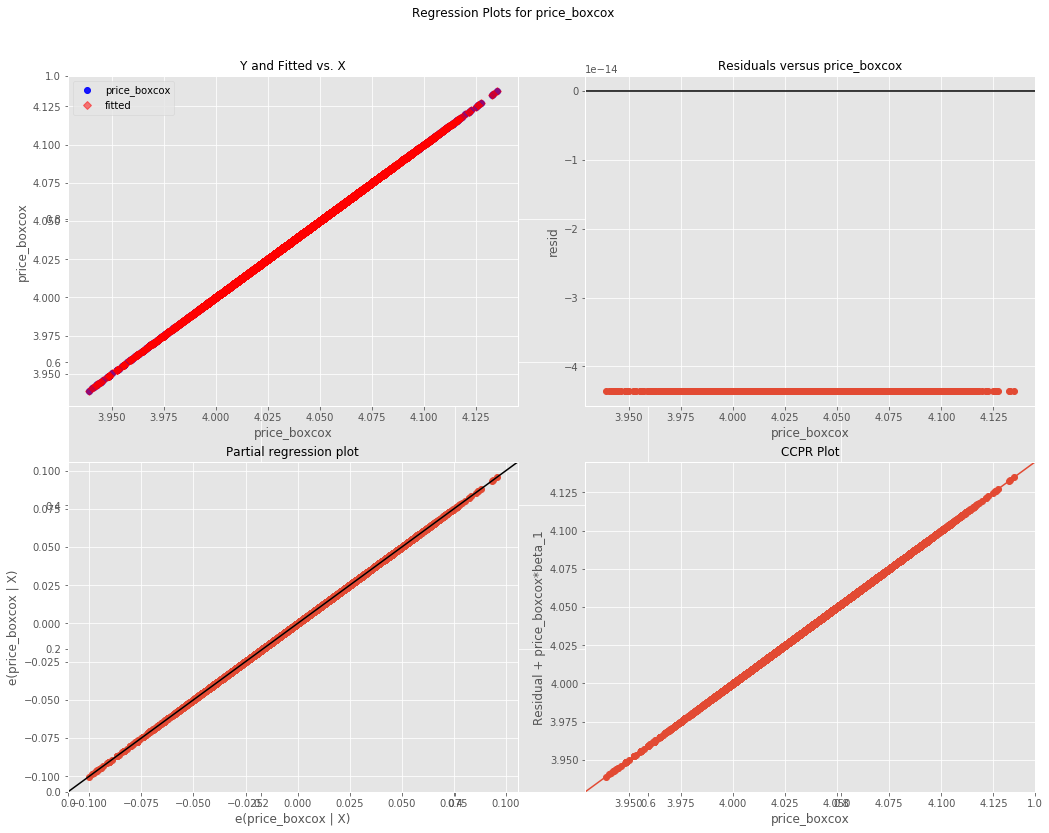

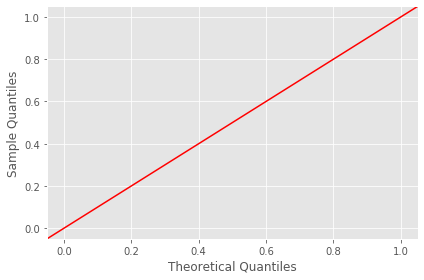

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~bedrooms
-------------------------------------------------------------------------------------


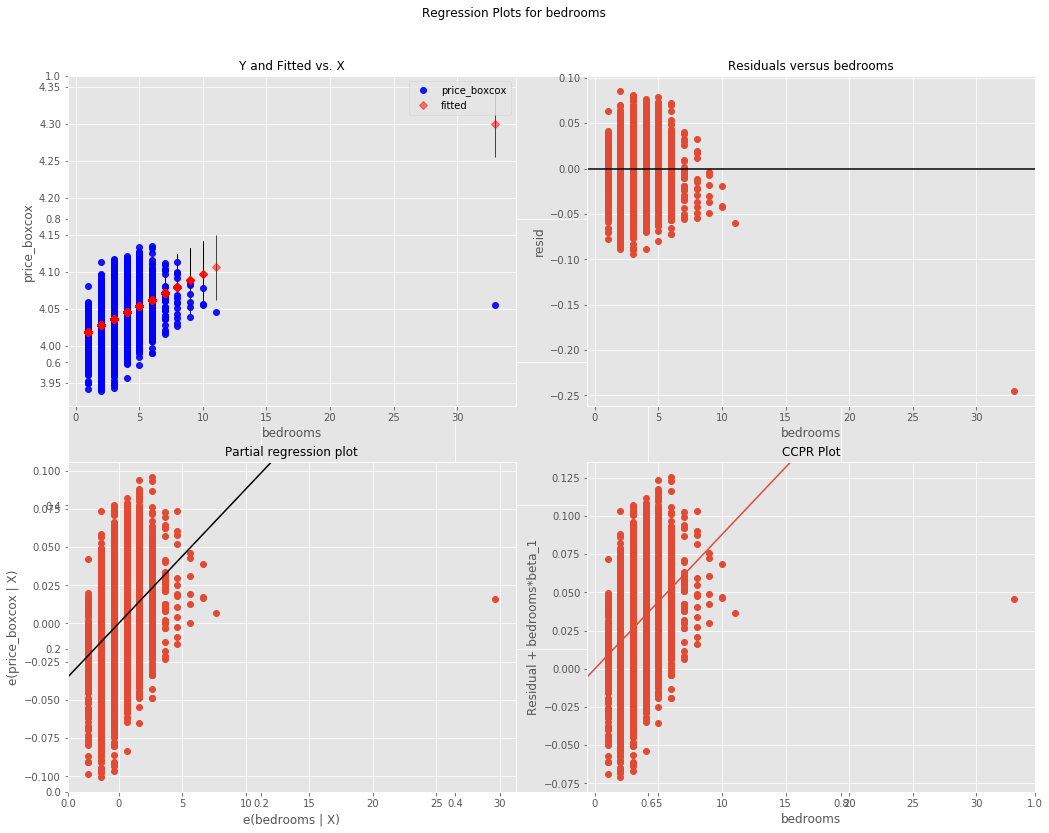

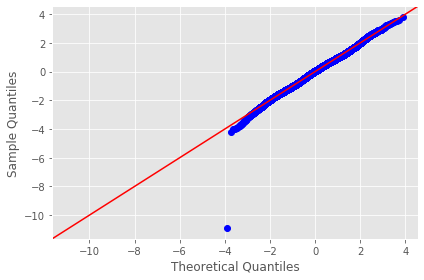

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~sqft_living
-------------------------------------------------------------------------------------


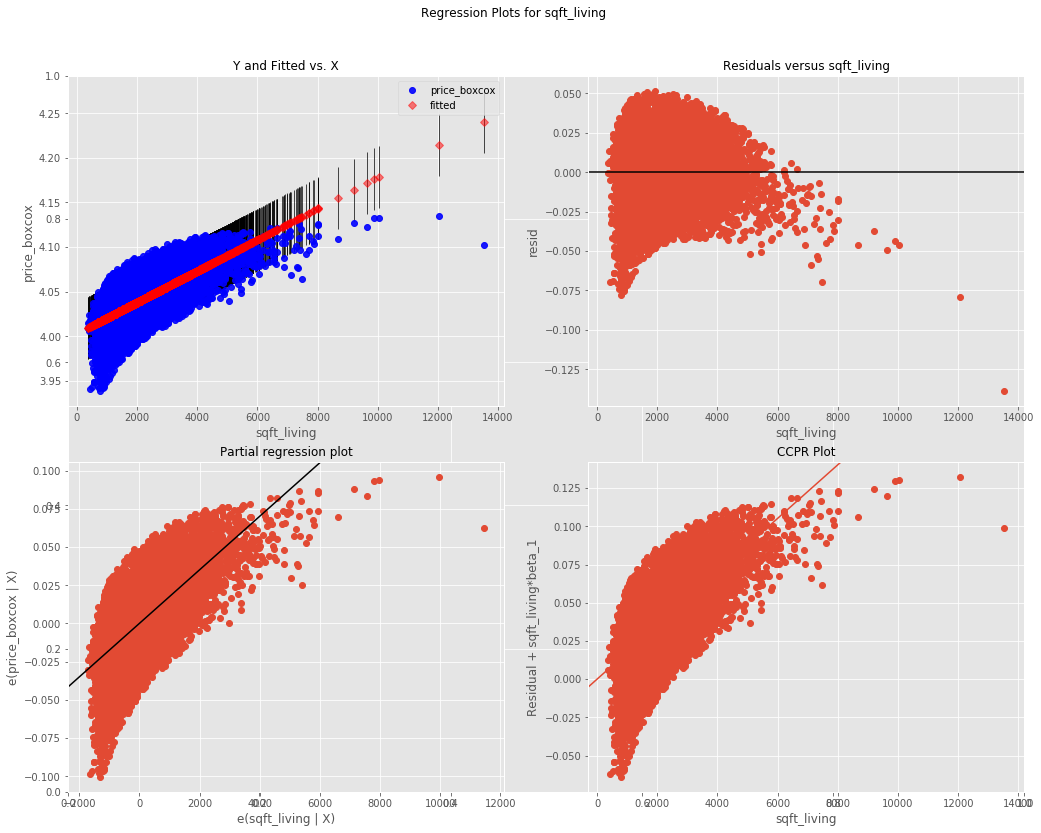

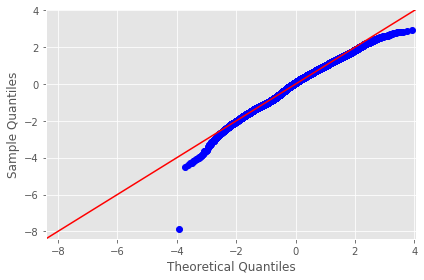

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view
-------------------------------------------------------------------------------------


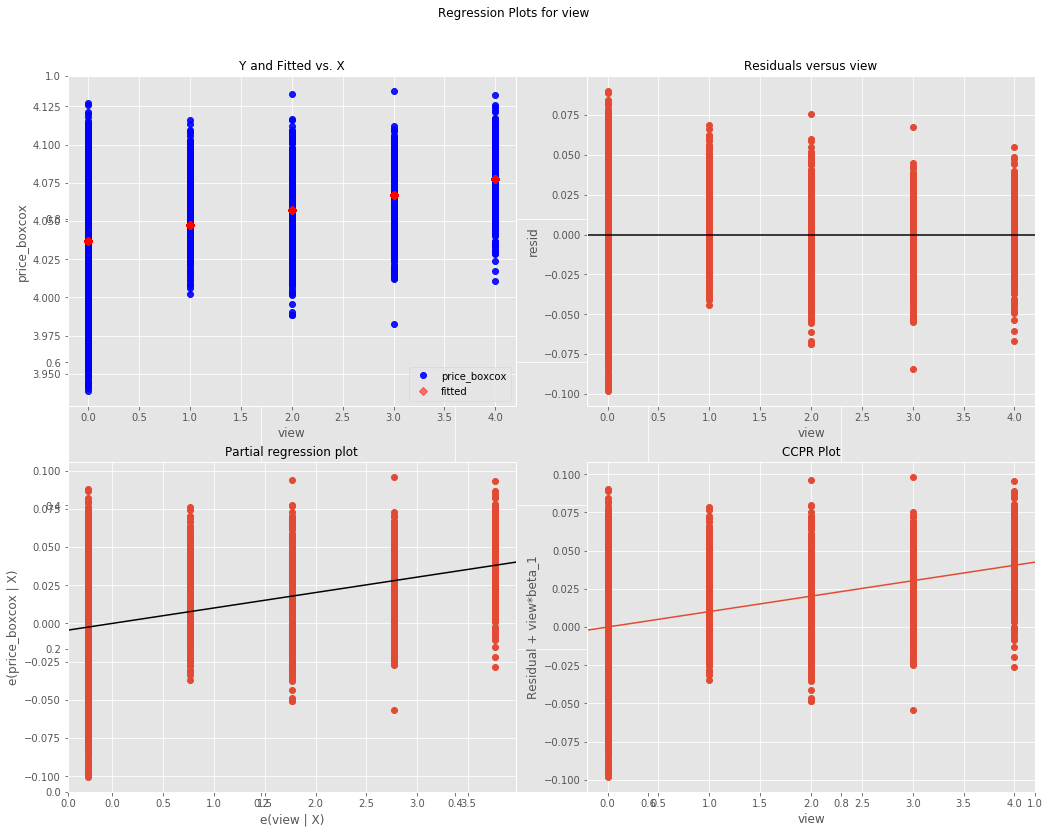

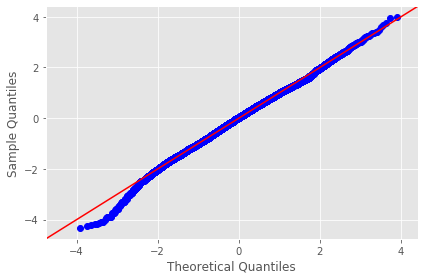

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_15
-------------------------------------------------------------------------------------


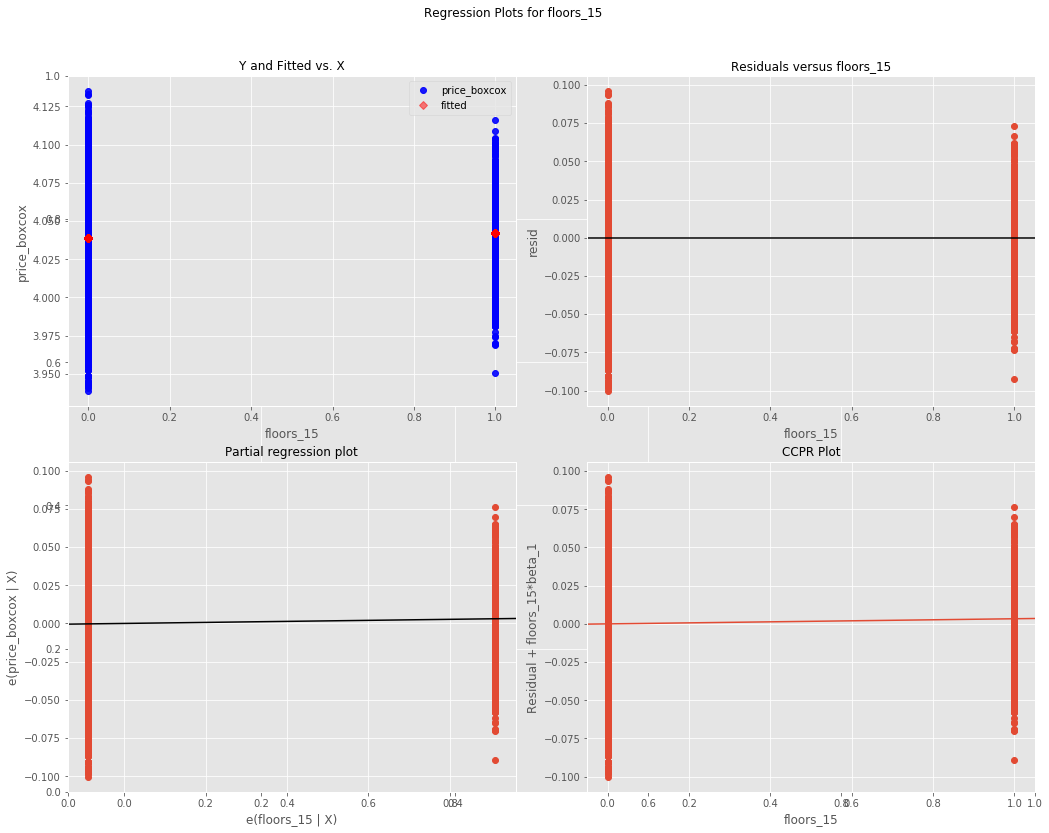

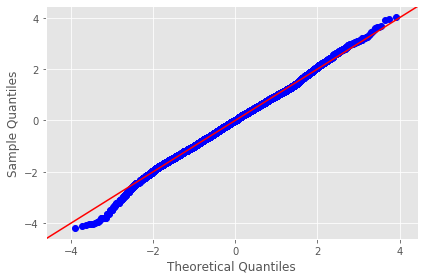

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_30
-------------------------------------------------------------------------------------


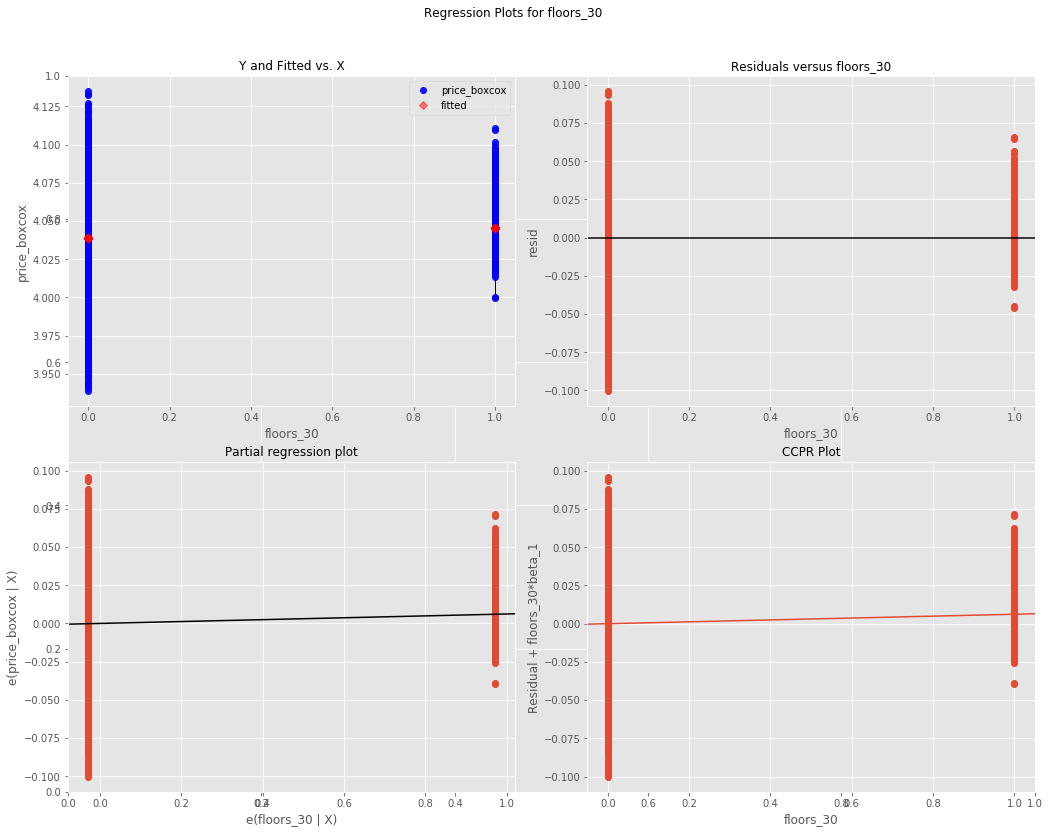

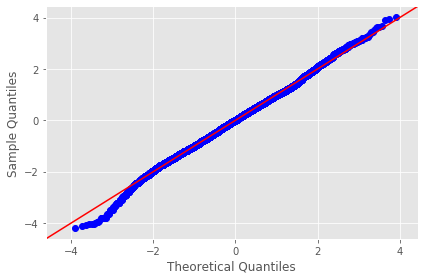

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_5
-------------------------------------------------------------------------------------


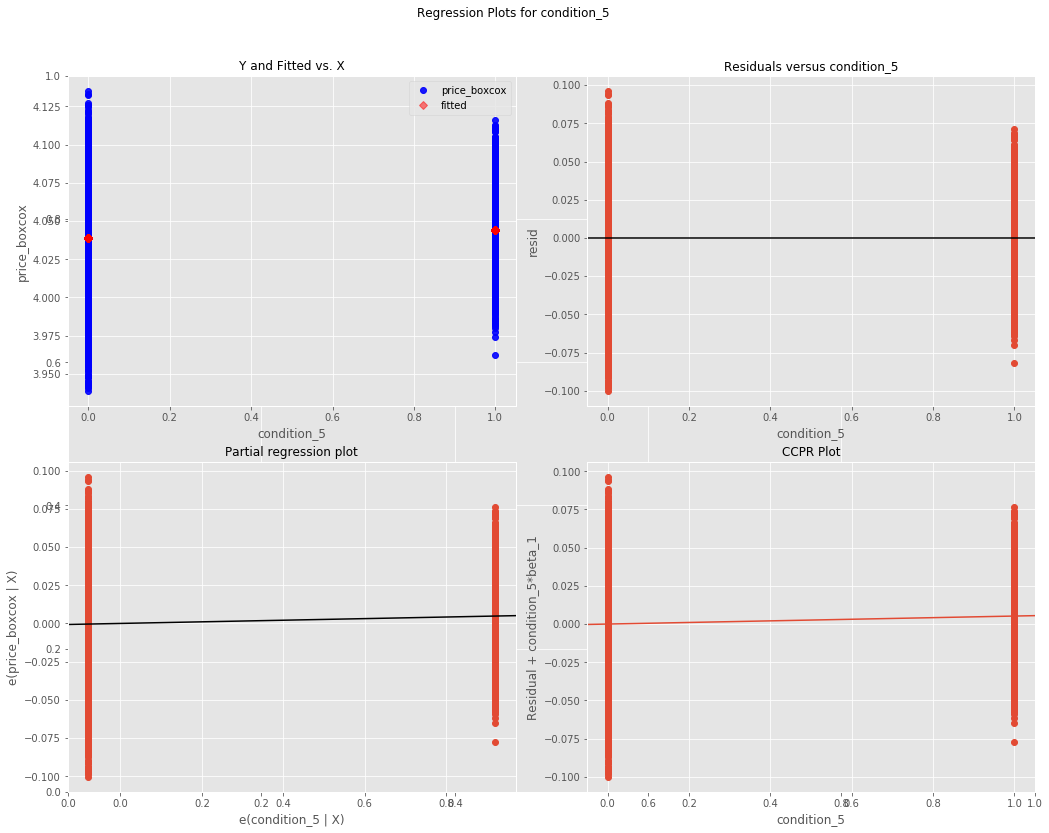

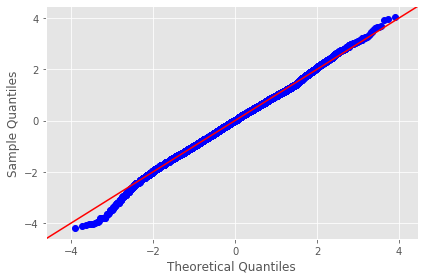

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_20
-------------------------------------------------------------------------------------


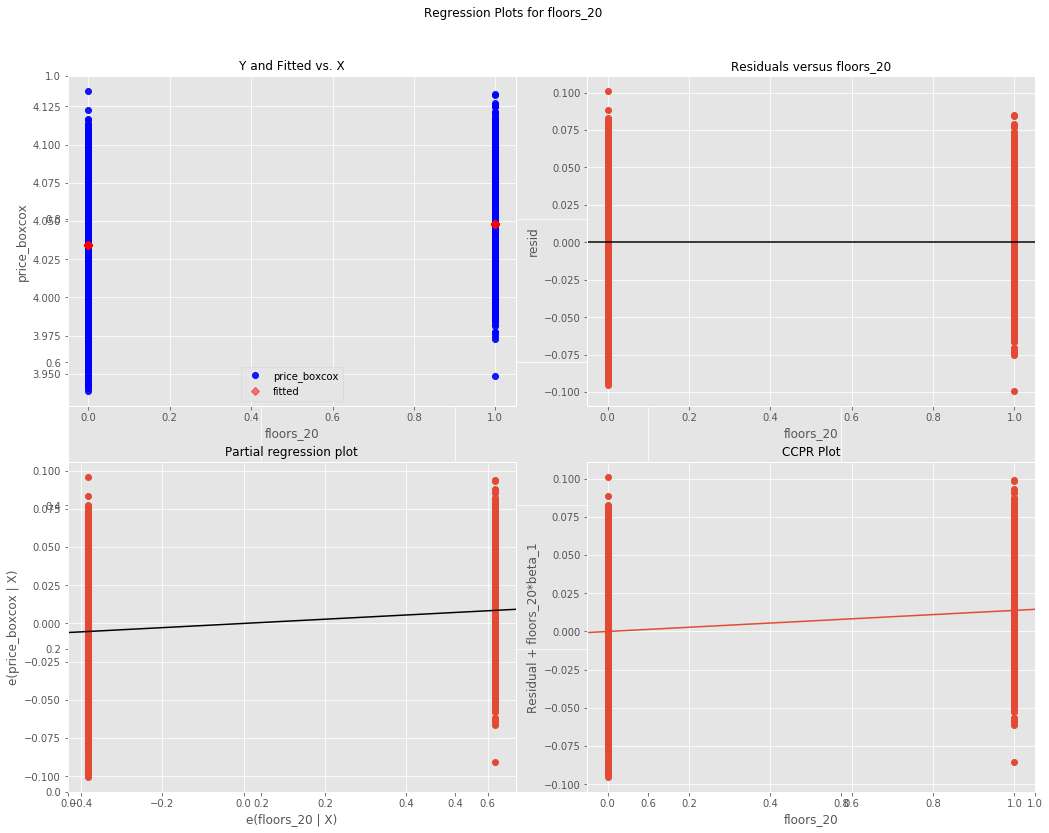

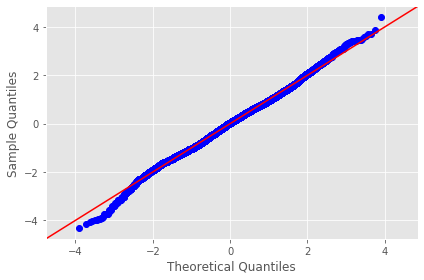

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_4
-------------------------------------------------------------------------------------


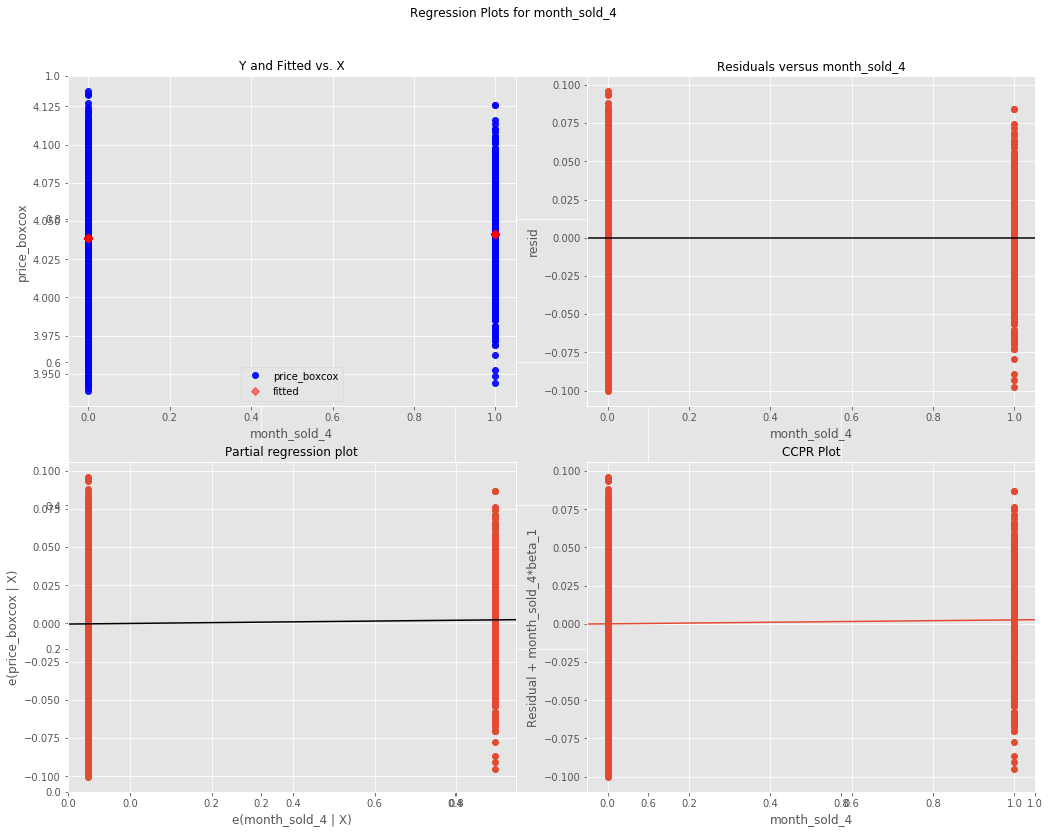

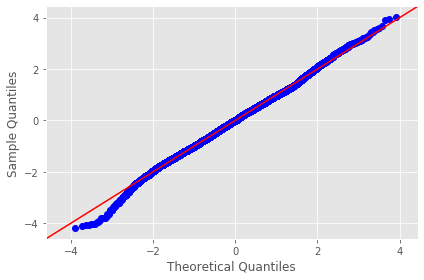

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_4
-------------------------------------------------------------------------------------


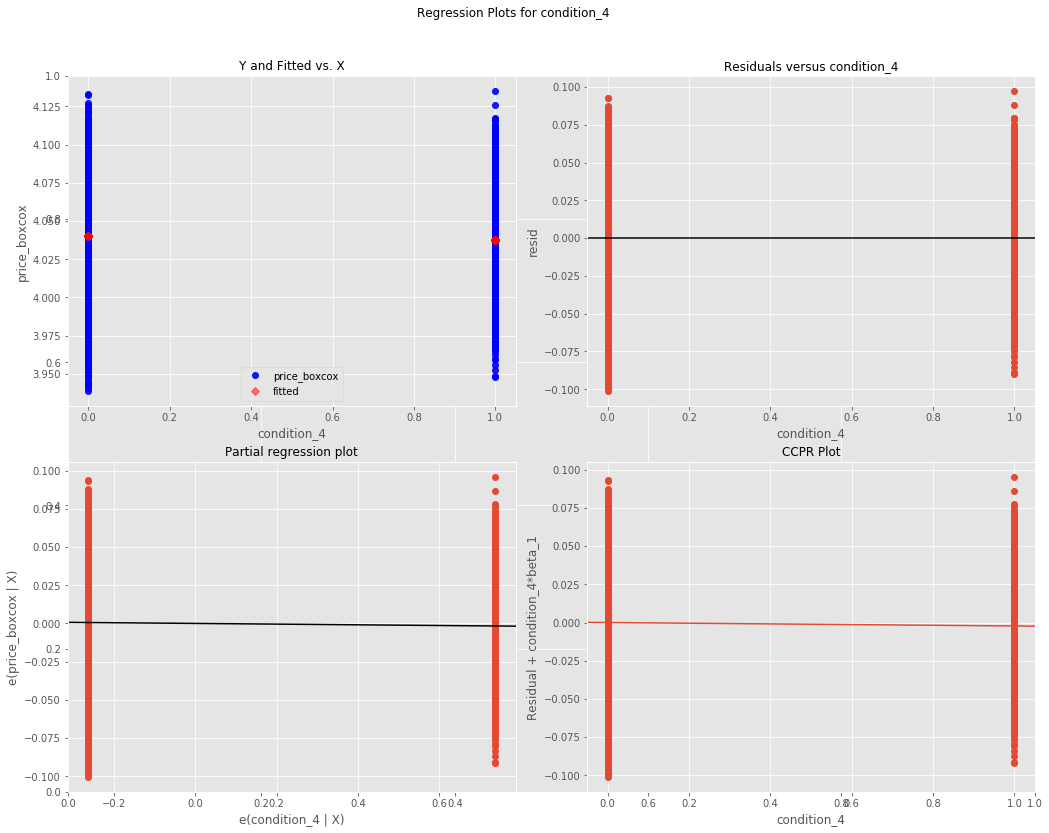

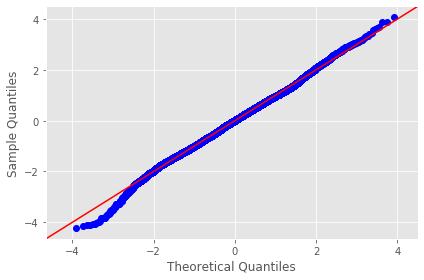

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_25
-------------------------------------------------------------------------------------


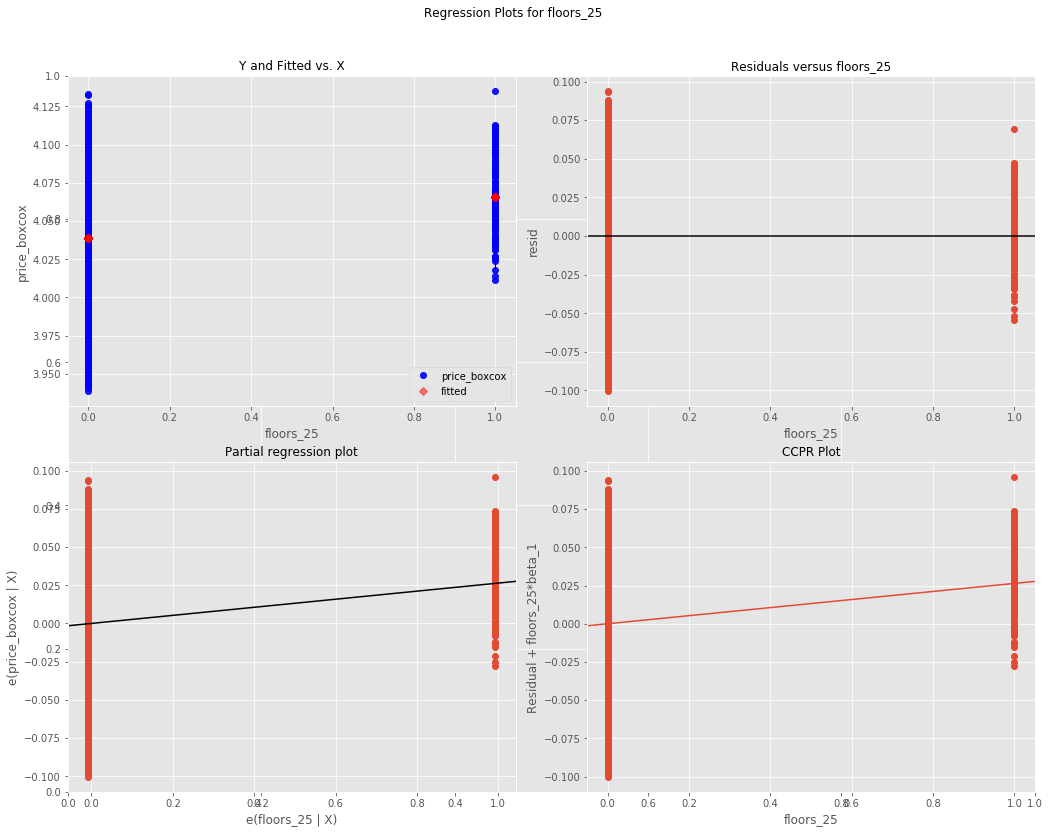

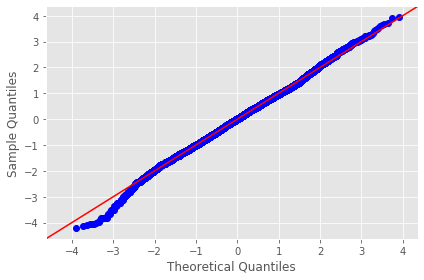

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~waterfront_1
-------------------------------------------------------------------------------------


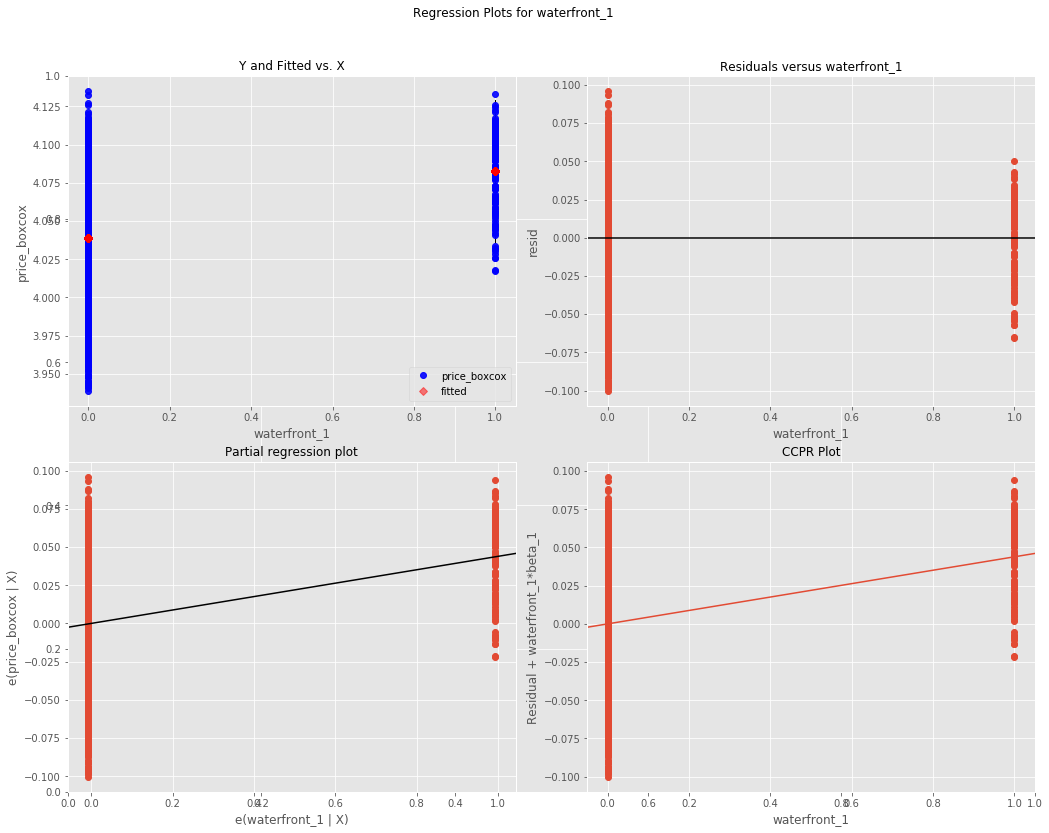

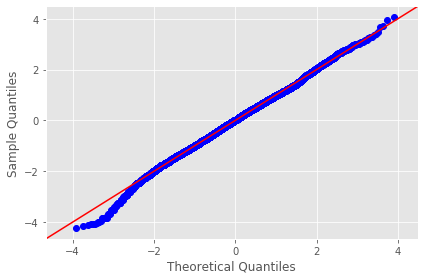

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~sqft_basement
-------------------------------------------------------------------------------------


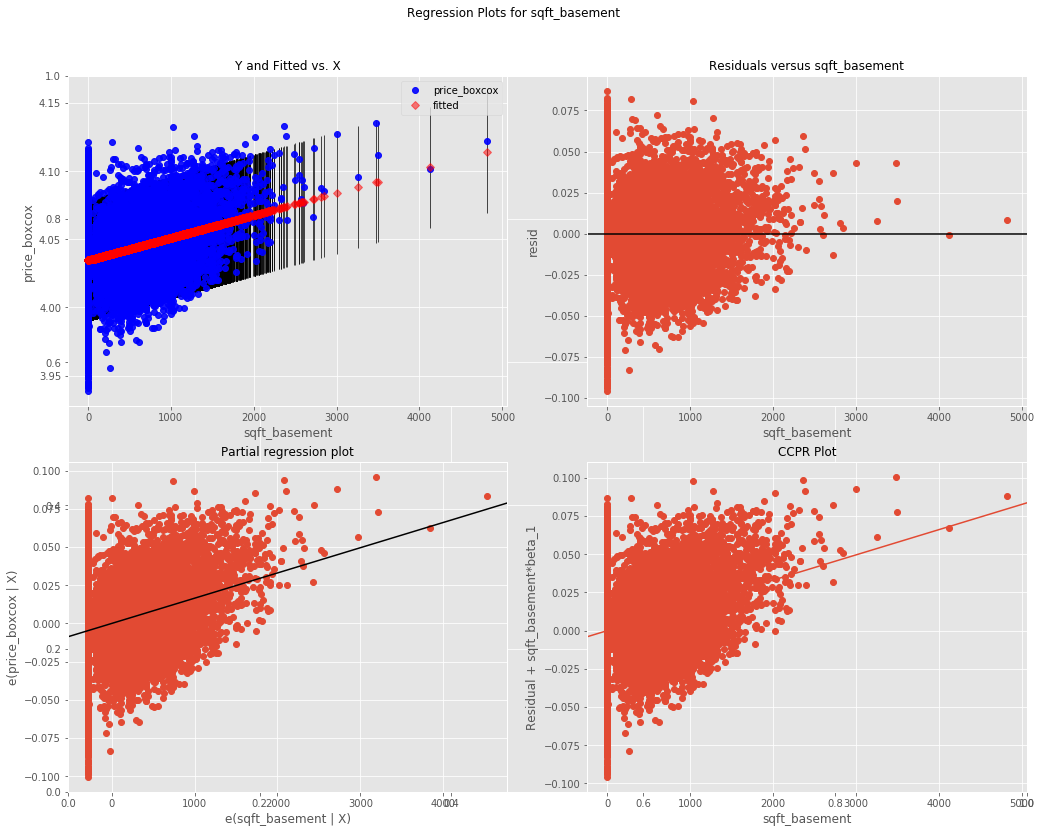

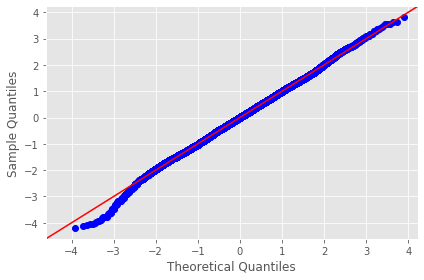

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_3
-------------------------------------------------------------------------------------


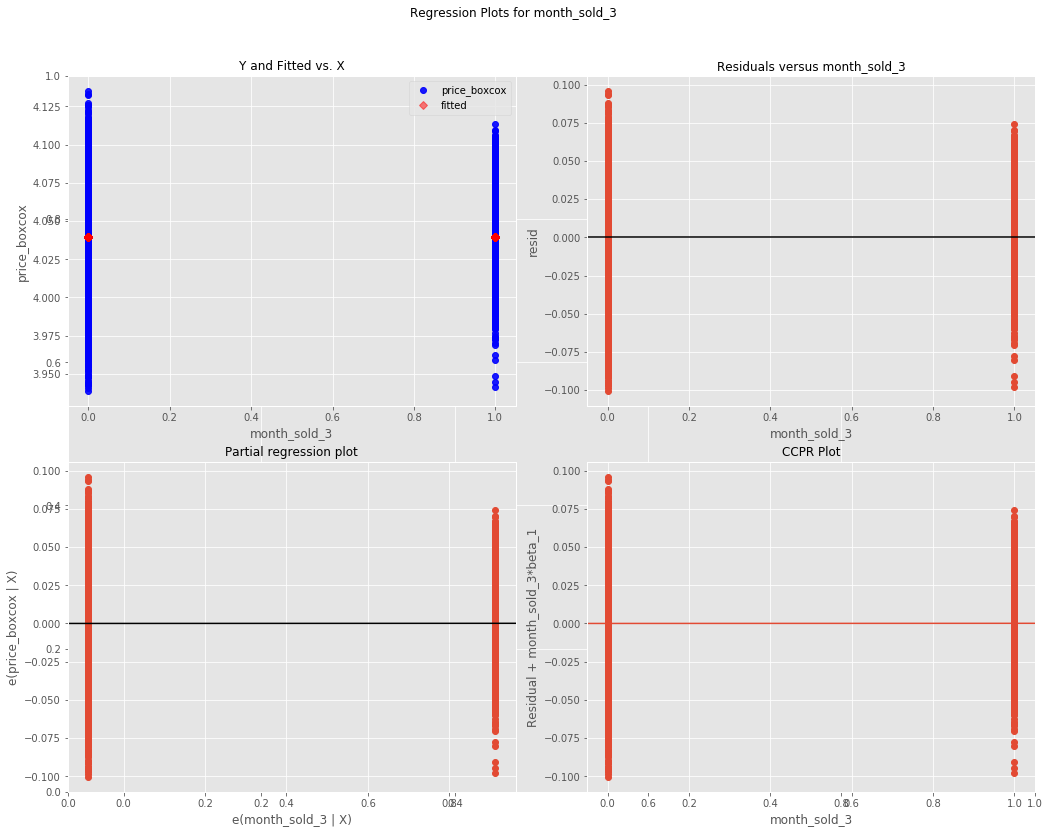

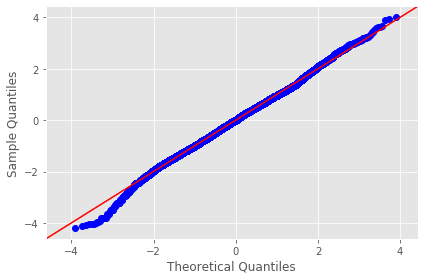

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_3
-------------------------------------------------------------------------------------


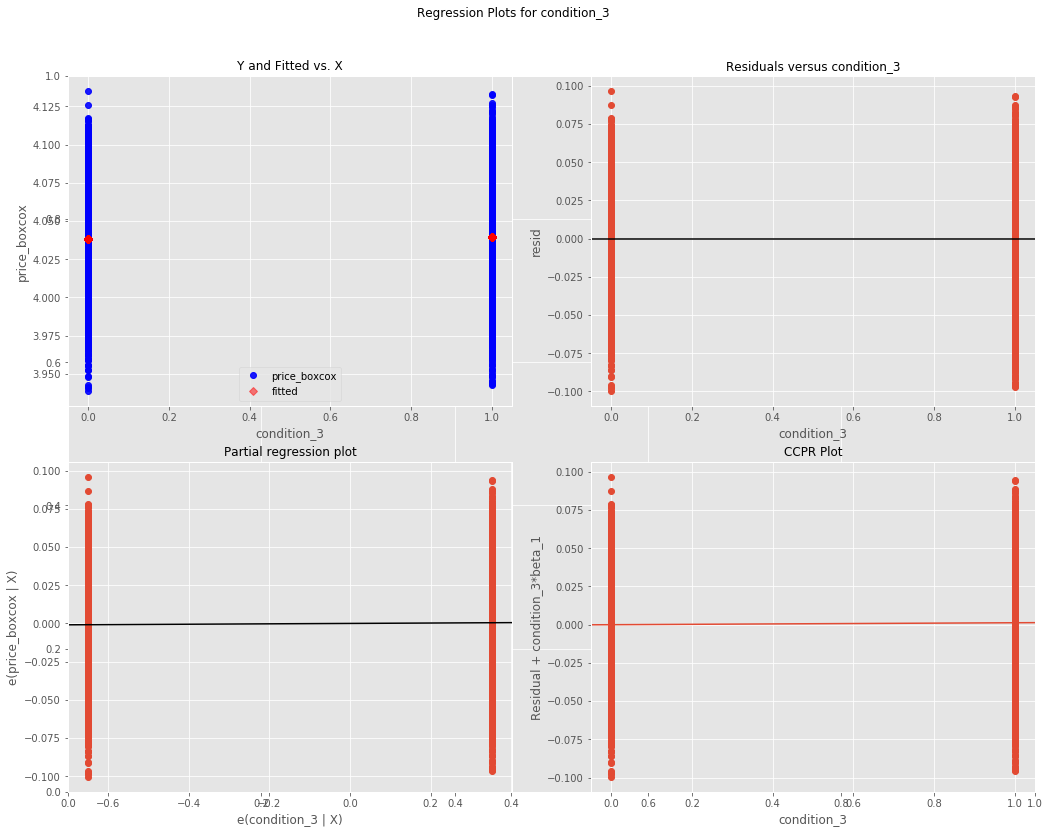

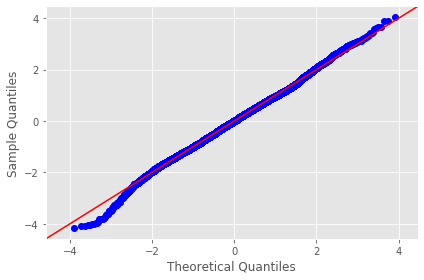

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_26
-------------------------------------------------------------------------------------


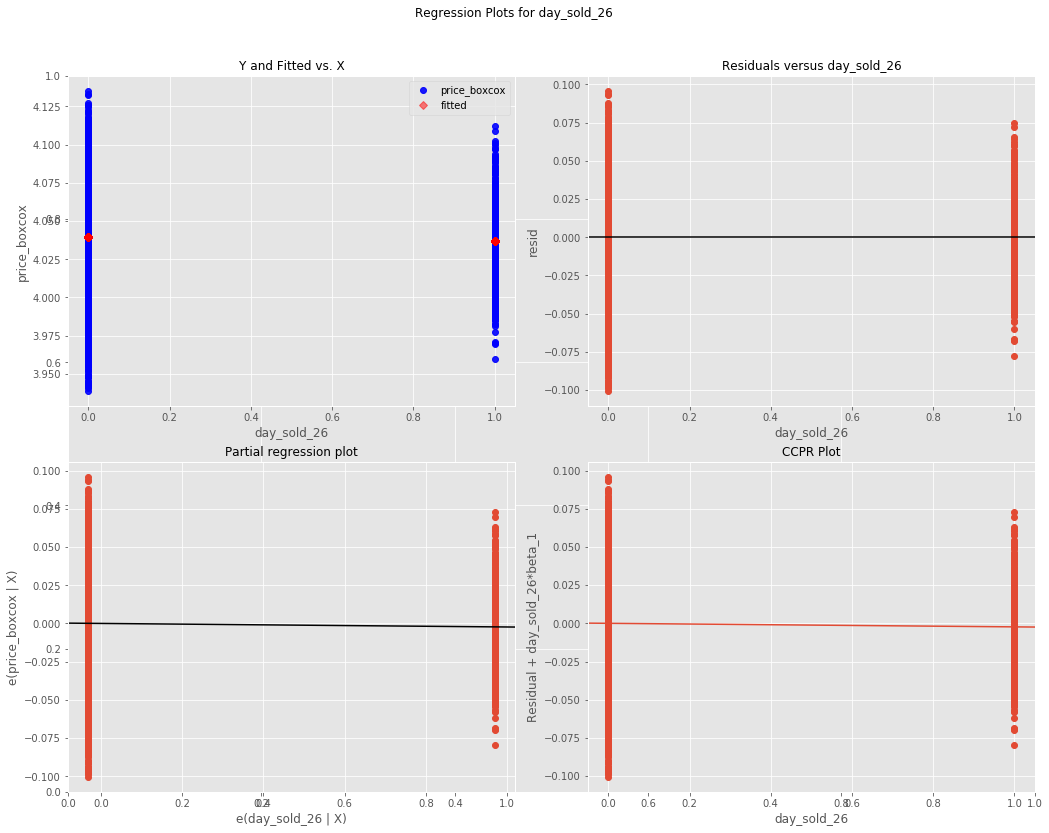

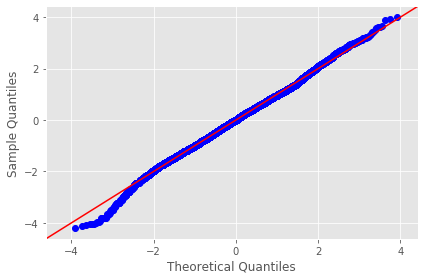

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_5
-------------------------------------------------------------------------------------


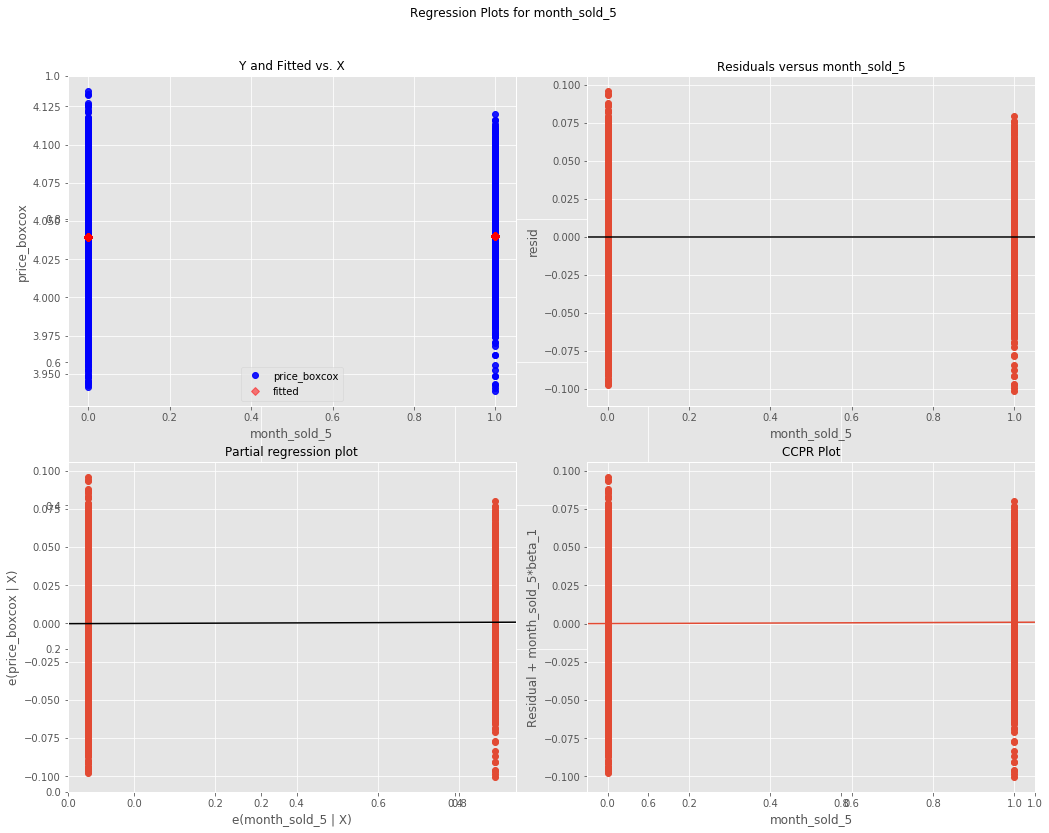

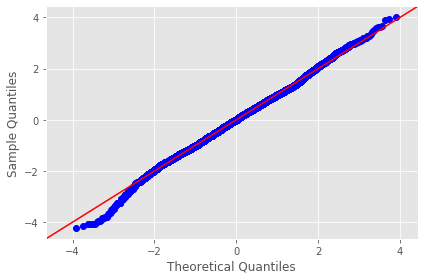

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_6
-------------------------------------------------------------------------------------


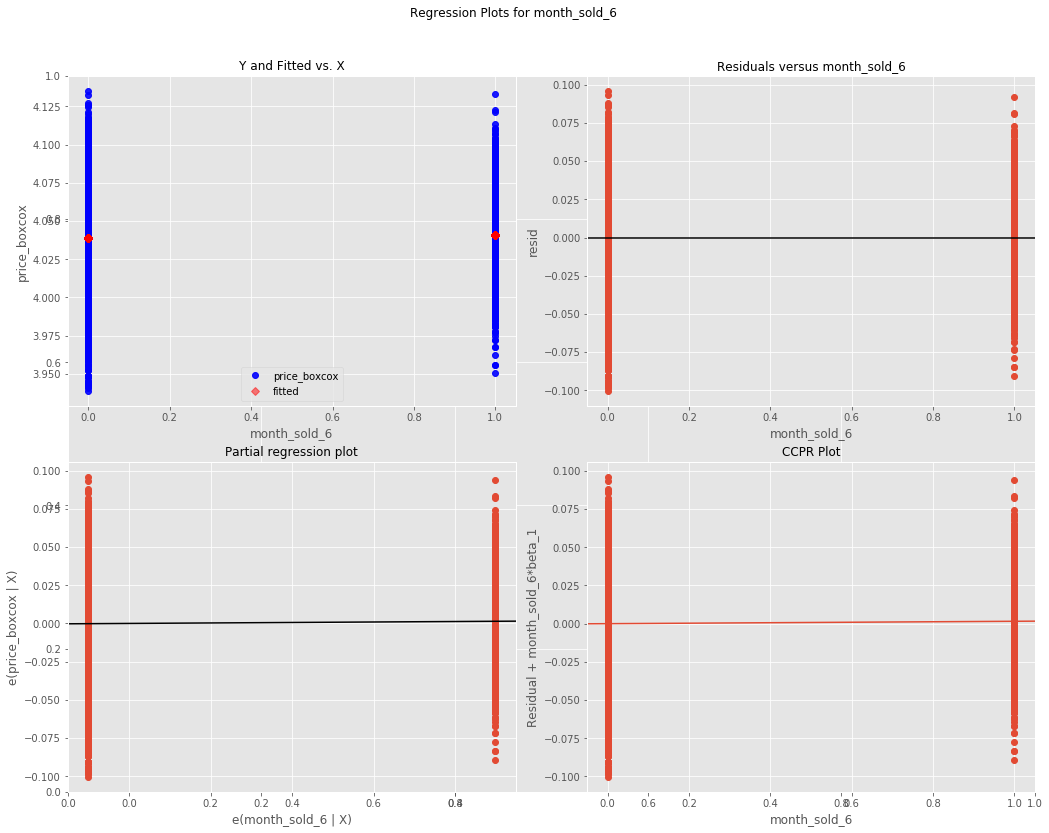

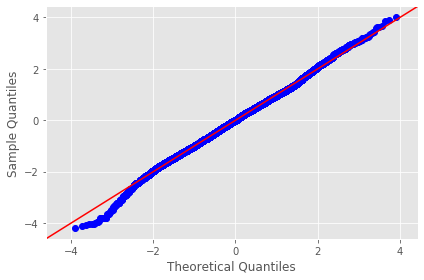

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_31
-------------------------------------------------------------------------------------


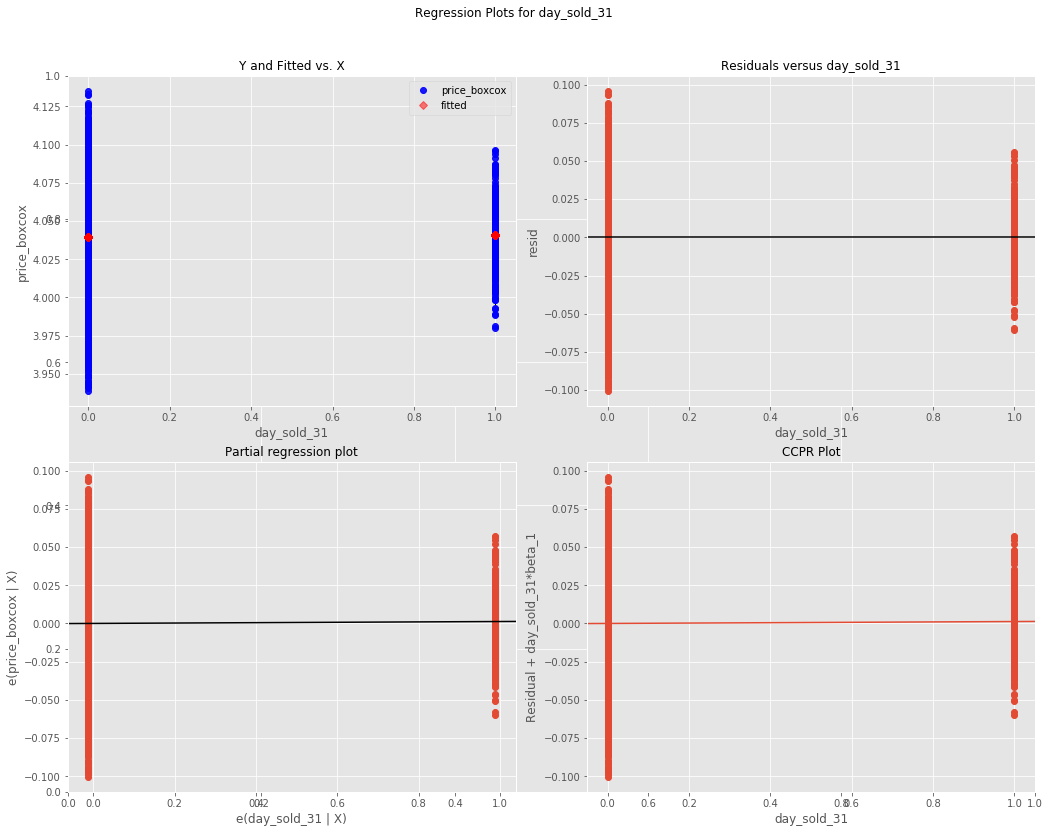

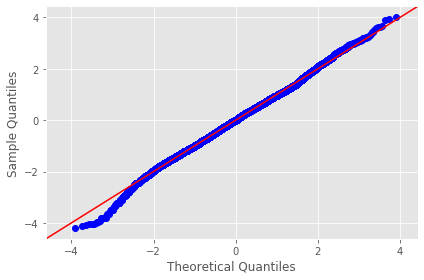

In [114]:
# evaluate residuals to check assumptions
dataset = pd.concat([y, X], axis=1)
results = []
y = 'price_boxcox'
for idx, column in enumerate(dataset.columns):
    print (f"KC Housing DataSet - Regression Analysis and Diagnostics for log_price~{column}")
    print ("-------------------------------------------------------------------------------------")

    f = f'{y}~{column}'
    model = smf.ols(formula=f, data=dataset).fit()
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [115]:
# store results in dataframe
model_3_results = pd.DataFrame(results, columns=['ind_var', 
                                                 'r_squared', 
                                                 'intercept', 
                                                 'slope', 
                                                 'p-value', 
                                                 'normality (JB)'])

In [116]:
model_3_results

ind_var     r_squared     intercept     slope        p-value  \
0    price_boxcox  1.000000e+00  4.085621e-14  1.000000   0.000000e+00   
1        bedrooms  1.164293e-01  4.009657e+00  0.008790   0.000000e+00   
2     sqft_living  4.551755e-01  4.002829e+00  0.000018   0.000000e+00   
3            view  1.048230e-01  4.036952e+00  0.010103   0.000000e+00   
4       floors_15  1.596793e-03  4.039011e+00  0.003358   4.241749e-09   
5       floors_30  1.841506e-03  4.039133e+00  0.006176   2.809038e-10   
6     condition_5  3.502540e-03  4.038895e+00  0.005243   3.189714e-18   
7       floors_20  7.898473e-02  4.034043e+00  0.013807   0.000000e+00   
8    month_sold_4  1.092044e-03  4.039040e+00  0.002592   1.188949e-06   
9     condition_4  1.739786e-03  4.039902e+00 -0.002261   8.673182e-10   
10      floors_25  9.056243e-03  4.039111e+00  0.026399   1.239523e-44   
11   waterfront_1  2.272756e-02  4.039011e+00  0.043901  5.618243e-110   
12  sqft_basement  9.262423e-02  4.034590e+00  0.000017   0.000000e+00   
13   month_sold_3  9.976293e-07  4.039300e+00  0.000085   8.833085e-01   
14    condition_3  6.581344e-04  4.038475e+00  0.001283   1.629128e-04   
15    day_sold_26  2.844059e-04  4.039380e+00 -0.002323   1.319724e-02   
16   month_sold_5  1.295875e-04  4.039211e+00  0.000862   9.434913e-02   
17   month_sold_6  3.922205e-04  4.039149e+00  0.001569   3.607603e-03   
18    day_sold_31  3.173604e-05  4.039293e+00  0.001254   4.077558e-01   

    normality (JB)  
0      8098.875000  
1       547.858159  
2       271.644613  
3       127.984631  
4        94.702047  
5        81.444572  
6        86.675154  
7        57.119724  
8        85.031359  
9        88.691450  
10       79.190062  
11       71.633680  
12       39.571146  
13       84.628653  
14       83.645715  
15       84.826784  
16       85.451862  
17       84.941112  
18       84.660862

In [117]:
model_2_results

ind_var  r_squared     intercept     slope        p-value  \
0       log_price   1.000000 -9.192647e-14  1.000000   0.000000e+00   
1        bedrooms   0.117896  1.238982e+01  0.195183   0.000000e+00   
2     sqft_living   0.483282  1.221878e+01  0.000399   0.000000e+00   
3            view   0.118786  1.299287e+01  0.237328   0.000000e+00   
4       floors_15   0.001405  1.304206e+01  0.069506   3.594981e-08   
5       floors_30   0.001523  1.304471e+01  0.123917   9.681246e-09   
6     condition_5   0.003739  1.303880e+01  0.119530   2.379531e-19   
7    waterfront_1   0.029145  1.304079e+01  1.097012  6.303414e-141   
8       floors_20   0.078047  1.293273e+01  0.302858   0.000000e+00   
9     condition_4   0.001665  1.306104e+01 -0.048816   1.978624e-09   
10      floors_25   0.010356  1.304357e+01  0.622938   8.095220e-51   
11   month_sold_4   0.000985  1.304261e+01  0.054306   3.985925e-06   
12    condition_3   0.000481  1.303250e+01  0.024198   1.267351e-03   
13   month_sold_3   0.000004  1.304790e+01  0.003552   7.801307e-01   
14  sqft_basement   0.098044  1.294110e+01  0.000375   0.000000e+00   
15   month_sold_5   0.000134  1.304605e+01  0.019358   8.868599e-02   
16   month_sold_6   0.000383  1.304476e+01  0.034203   4.043666e-03   
17    day_sold_26   0.000248  1.304969e+01 -0.047876   2.060791e-02   
18    day_sold_31   0.000028  1.304791e+01  0.026216   4.329462e-01   

    normality (JB)  
0       988.302416  
1      1471.526272  
2         3.561514  
3       436.570188  
4      1143.754527  
5      1121.942633  
6      1085.610395  
7       701.596141  
8      1131.225833  
9      1107.786771  
10     1004.285098  
11     1109.271954  
12     1110.299379  
13     1097.666745  
14      691.265153  
15     1098.064846  
16     1099.323755  
17     1100.418032  
18     1098.656370

In [118]:
# using boxcox transformation is looking better from a q-q plot view
# move forward with price_boxcox as our y variable
# continue with additional preprocessing to get to better results

In [119]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

In [120]:
# drop log_price and price
preprocessed = clean_data.drop(['price', 'log_price'], axis=1)

In [121]:
# plot price_boxcox against all continuous variables
# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [122]:
# remove clear non-linear columns
preprocessed = preprocessed.drop(['sqft_lot',
                                  'yr_built',
                                  'yr_renovated',
                                  'zipcode',
                                  'lat',
                                  'long',
                                  'sqft_lot15'], axis=1)

In [123]:
# plot remaining against price_boxcox
# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15'])

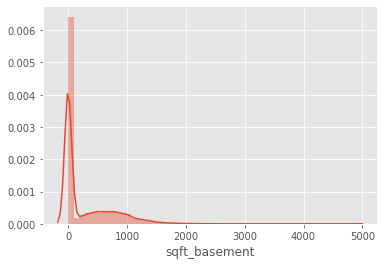

In [124]:
# not super linear relationships, try transforming to improve
# start with sqft_basement
sns.distplot(preprocessed['sqft_basement']);

In [125]:
# bimodal, remove for heteroscedasicity issues for now
preprocessed = preprocessed.drop('sqft_basement', axis=1)

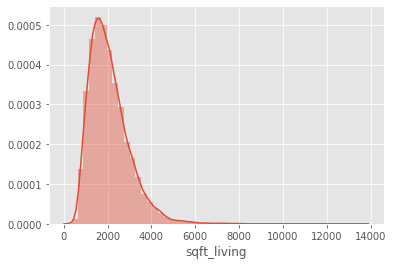

In [126]:
# sqft_living
sns.distplot(preprocessed['sqft_living']);

In [127]:
# looks slightly log normally distributed

In [128]:
# transform sqft_living
preprocessed['t_sqft_living'], l_sqft_living = stats.boxcox(x=preprocessed['sqft_living'])
l_sqft_living

0.02217548114933232

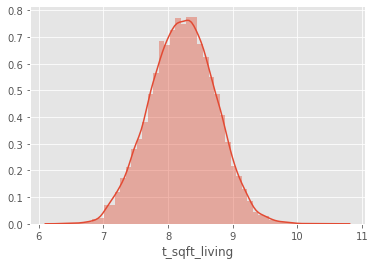

In [129]:
# look at distribution again
sns.distplot(preprocessed['t_sqft_living']);

In [130]:
# looking much more normal

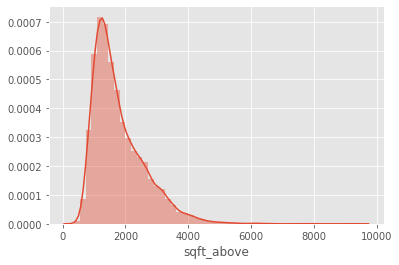

In [131]:
# sqft_above
sns.distplot(preprocessed['sqft_above']);

In [132]:
# similar to sqft_living, transform -- looking slightly log normal
preprocessed['t_sqft_above'], l_sqft_above = stats.boxcox(x=preprocessed['sqft_above'])
l_sqft_above

-0.24056564512230597

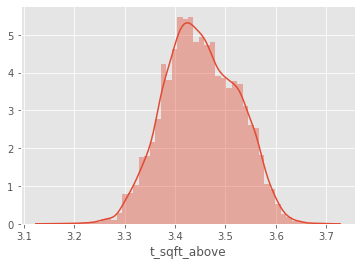

In [133]:
# replot
sns.distplot(preprocessed['t_sqft_above'])

In [134]:
# looking better

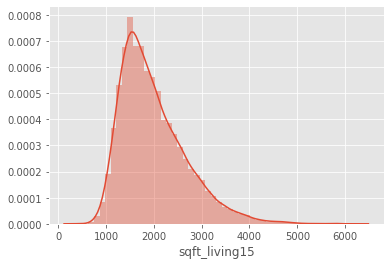

In [135]:
# sqft_living15
sns.distplot(preprocessed['sqft_living15'])

In [136]:
# transform for similar reasons
preprocessed['t_sqft_living15'], l_sqft_living15 = stats.boxcox(x=preprocessed['sqft_living15'])

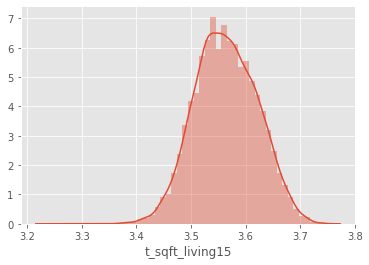

In [137]:
sns.distplot(preprocessed['t_sqft_living15'])

In [138]:
# looking better

In [139]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         21597 non-null  int64  
 1   bathrooms        21597 non-null  float64
 2   sqft_living      21597 non-null  int64  
 3   floors           21597 non-null  float64
 4   waterfront       21597 non-null  float64
 5   view             21597 non-null  float64
 6   condition        21597 non-null  int64  
 7   grade            21597 non-null  int64  
 8   sqft_above       21597 non-null  int64  
 9   sqft_living15    21597 non-null  int64  
 10  year_sold        21597 non-null  int64  
 11  month_sold       21597 non-null  int64  
 12  day_sold         21597 non-null  int64  
 13  price_boxcox     21597 non-null  float64
 14  t_sqft_living    21597 non-null  float64
 15  t_sqft_above     21597 non-null  float64
 16  t_sqft_living15  21597 non-null  float64
dtypes: float64(8

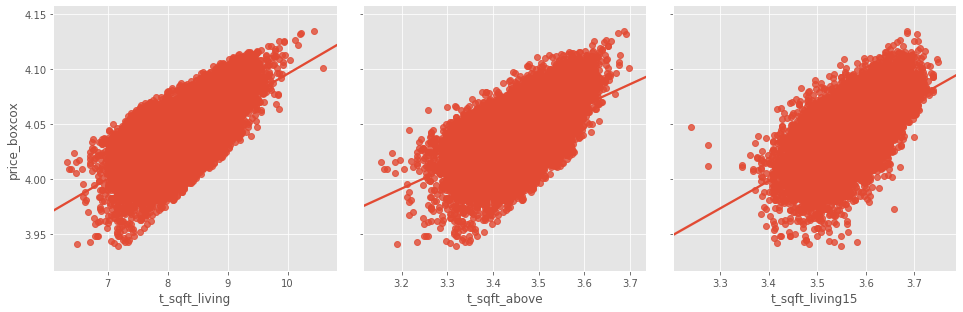

In [140]:
# replot against price
plot_relationship(data=preprocessed, 
                  y_vars=['price_boxcox'], 
                  x_vars=['t_sqft_living', 't_sqft_above', 't_sqft_living15'])

In [141]:
# looking slightly more linear now

In [142]:
# drop columns
preprocessed = preprocessed.drop(['sqft_living', 
                                  'sqft_above', 
                                  'sqft_living15'], axis=1)

In [143]:
data_pred = preprocessed.drop(['price_boxcox'], axis=1)

In [144]:
# identify and remove multi-collinearity
correlated = multi_collinearity(data_pred=data_pred)

In [145]:
correlated

cc
pairs                                  
(t_sqft_living, t_sqft_above)  0.864326
(year_sold, month_sold)        0.782325
(t_sqft_living, bathrooms)     0.762663

In [146]:
# remove t_sqft_above and bathrooms as they are correlated with sqft_living
# remove year_sold
preprocessed = preprocessed.drop(['t_sqft_above',
                                  'bathrooms',
                                  'year_sold'], axis=1)

In [147]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         21597 non-null  int64  
 1   floors           21597 non-null  float64
 2   waterfront       21597 non-null  float64
 3   view             21597 non-null  float64
 4   condition        21597 non-null  int64  
 5   grade            21597 non-null  int64  
 6   month_sold       21597 non-null  int64  
 7   day_sold         21597 non-null  int64  
 8   price_boxcox     21597 non-null  float64
 9   t_sqft_living    21597 non-null  float64
 10  t_sqft_living15  21597 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 1.8 MB


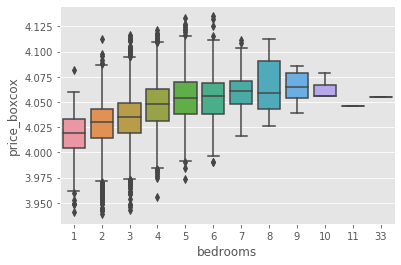

In [148]:
# handle categorical columns

# bedrooms
sns.boxplot(x='bedrooms', y='price_boxcox', data=preprocessed)

In [149]:
# ordinal relationship - - seem to be a number of outliers
preprocessed['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

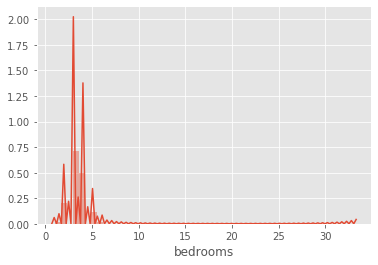

In [150]:
sns.distplot(preprocessed['bedrooms'])

In [151]:
# significant drop off after 5
low, high = find_outliers('bedrooms', preprocessed)
print(low, high)

1.5 5.5


In [152]:
# drop bedrooms greater than high mark
# how many houses with only 1 bedroom?
preprocessed.loc[preprocessed['bedrooms'] == 1]['price_boxcox'].count()

196

In [153]:
# only 196
# drop outliers based on low and high mark identifed above
preprocessed = preprocessed.loc[(preprocessed['bedrooms'] > low)
                               & (preprocessed['bedrooms'] < high)]

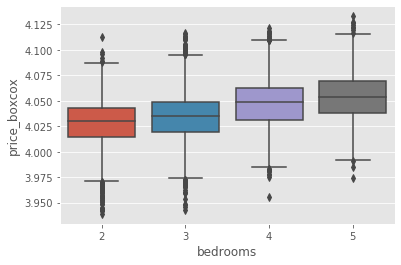

In [154]:
# replot against price
sns.boxplot(x='bedrooms', y='price_boxcox', data=preprocessed)

In [155]:
# very ordinal looking relationshipo, leave as single column

In [156]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         21067 non-null  int64  
 1   floors           21067 non-null  float64
 2   waterfront       21067 non-null  float64
 3   view             21067 non-null  float64
 4   condition        21067 non-null  int64  
 5   grade            21067 non-null  int64  
 6   month_sold       21067 non-null  int64  
 7   day_sold         21067 non-null  int64  
 8   price_boxcox     21067 non-null  float64
 9   t_sqft_living    21067 non-null  float64
 10  t_sqft_living15  21067 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 2.6 MB


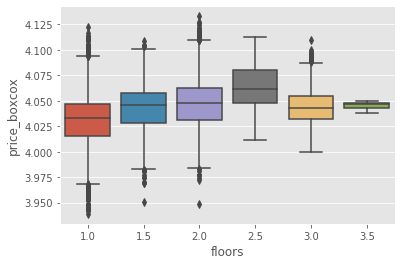

In [157]:
# floors
sns.boxplot(x='floors', 
            y='price_boxcox', 
            data=preprocessed)

In [158]:
preprocessed['floors'].describe()

count    21067.000000
mean         1.495063
std          0.539720
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

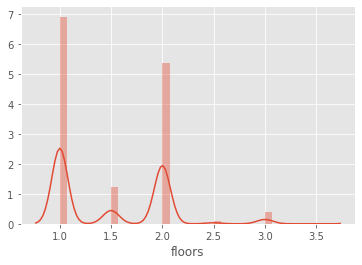

In [159]:
sns.distplot(preprocessed['floors'])

In [160]:
# significant drop off after 2 floors
# scale by 10 to avoid syntax issues
preprocessed['floors_scaled'] = preprocessed['floors'] * 10
preprocessed['floors_scaled'] = preprocessed['floors_scaled'].astype('int64')

# not ordinal, OHE
ohe_list = []
ohe_list.append('floors_scaled')

In [161]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         21067 non-null  int64  
 1   floors           21067 non-null  float64
 2   waterfront       21067 non-null  float64
 3   view             21067 non-null  float64
 4   condition        21067 non-null  int64  
 5   grade            21067 non-null  int64  
 6   month_sold       21067 non-null  int64  
 7   day_sold         21067 non-null  int64  
 8   price_boxcox     21067 non-null  float64
 9   t_sqft_living    21067 non-null  float64
 10  t_sqft_living15  21067 non-null  float64
 11  floors_scaled    21067 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 2.7 MB


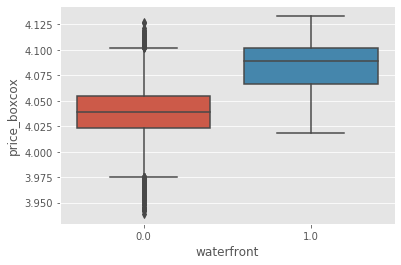

In [162]:
# waterfront
sns.boxplot(x='waterfront', y='price_boxcox', data=preprocessed)

In [163]:
# ohe encode
preprocessed['waterfront_clean'] = preprocessed['waterfront'].astype('int64')

In [164]:
ohe_list.append('waterfront_clean')

In [165]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          21067 non-null  int64  
 1   floors            21067 non-null  float64
 2   waterfront        21067 non-null  float64
 3   view              21067 non-null  float64
 4   condition         21067 non-null  int64  
 5   grade             21067 non-null  int64  
 6   month_sold        21067 non-null  int64  
 7   day_sold          21067 non-null  int64  
 8   price_boxcox      21067 non-null  float64
 9   t_sqft_living     21067 non-null  float64
 10  t_sqft_living15   21067 non-null  float64
 11  floors_scaled     21067 non-null  int64  
 12  waterfront_clean  21067 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 2.9 MB


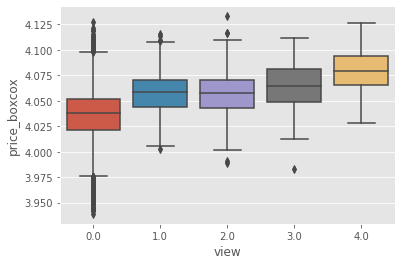

In [166]:
# view
sns.boxplot(x='view', y='price_boxcox', data=preprocessed)

In [167]:
# looking ordinal
# leave as a single column for now

In [168]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          21067 non-null  int64  
 1   floors            21067 non-null  float64
 2   waterfront        21067 non-null  float64
 3   view              21067 non-null  float64
 4   condition         21067 non-null  int64  
 5   grade             21067 non-null  int64  
 6   month_sold        21067 non-null  int64  
 7   day_sold          21067 non-null  int64  
 8   price_boxcox      21067 non-null  float64
 9   t_sqft_living     21067 non-null  float64
 10  t_sqft_living15   21067 non-null  float64
 11  floors_scaled     21067 non-null  int64  
 12  waterfront_clean  21067 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 2.9 MB


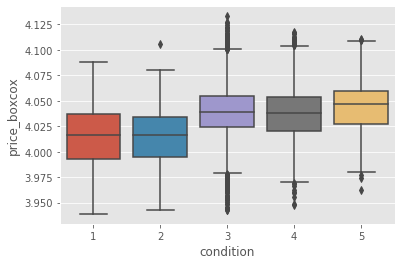

In [169]:
# condition
sns.boxplot(x='condition', y='price_boxcox', data=preprocessed)

In [170]:
# no clear ordinal - - ohe
ohe_list.append('condition')

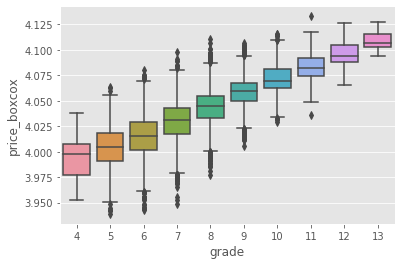

In [171]:
# grade
sns.boxplot(x='grade', y='price_boxcox', data=preprocessed)

In [172]:
# looking ordinal, leave as a single column

In [173]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          21067 non-null  int64  
 1   floors            21067 non-null  float64
 2   waterfront        21067 non-null  float64
 3   view              21067 non-null  float64
 4   condition         21067 non-null  int64  
 5   grade             21067 non-null  int64  
 6   month_sold        21067 non-null  int64  
 7   day_sold          21067 non-null  int64  
 8   price_boxcox      21067 non-null  float64
 9   t_sqft_living     21067 non-null  float64
 10  t_sqft_living15   21067 non-null  float64
 11  floors_scaled     21067 non-null  int64  
 12  waterfront_clean  21067 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 2.9 MB


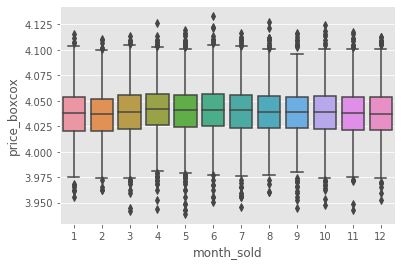

In [174]:
# month_sold
sns.boxplot(x='month_sold', y='price_boxcox', data=preprocessed);

In [175]:
# ohe
ohe_list.append('month_sold')

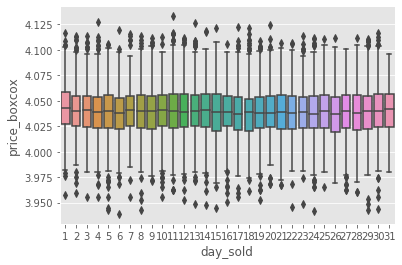

In [176]:
# day_sold
sns.boxplot(x='day_sold', y='price_boxcox', data=preprocessed);

In [177]:
# ohe
ohe_list.append('day_sold')

In [178]:
ohe_list

['floors_scaled', 'waterfront_clean', 'condition', 'month_sold', 'day_sold']

In [179]:
# create dummies
floors_dummies = pd.get_dummies(preprocessed['floors_scaled'],
                                prefix='floors',
                                drop_first=True)

waterfront_dummies = pd.get_dummies(preprocessed['waterfront_clean'],
                                    prefix='waterfront',
                                    drop_first=True)

condition_dummies = pd.get_dummies(preprocessed['condition'],
                                   prefix='condition',
                                   drop_first=True)

month_sold_dummies = pd.get_dummies(preprocessed['month_sold'],
                                    prefix='month_sold',
                                    drop_first=True)

day_sold_dummies = pd.get_dummies(preprocessed['day_sold'],
                                  prefix='day_sold',
                                  drop_first=True)

In [180]:
# drop columns
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          21067 non-null  int64  
 1   floors            21067 non-null  float64
 2   waterfront        21067 non-null  float64
 3   view              21067 non-null  float64
 4   condition         21067 non-null  int64  
 5   grade             21067 non-null  int64  
 6   month_sold        21067 non-null  int64  
 7   day_sold          21067 non-null  int64  
 8   price_boxcox      21067 non-null  float64
 9   t_sqft_living     21067 non-null  float64
 10  t_sqft_living15   21067 non-null  float64
 11  floors_scaled     21067 non-null  int64  
 12  waterfront_clean  21067 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 2.9 MB


In [181]:
data_fin = preprocessed.drop(['day_sold',
                              'month_sold',
                              'condition',
                              'waterfront_clean',
                              'waterfront',
                              'floors',
                              'floors_scaled'], axis=1)

In [182]:
# concat with dummy variables
data_fin = pd.concat([data_fin, floors_dummies,
                      waterfront_dummies, condition_dummies,
                      month_sold_dummies, day_sold_dummies], axis=1)

In [183]:
# run stepwise selection to select features
y = data_fin['price_boxcox']
X = data_fin.drop('price_boxcox', axis=1)

result = stepwise_selection(X, y, verbose = True)

Add  t_sqft_living15                with p-value 0.0


/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  grade                          with p-value 0.0
Add  t_sqft_living                  with p-value 3.45079e-269
Add  view                           with p-value 3.54876e-172
Add  floors_15                      with p-value 4.49223e-129
Add  condition_5                    with p-value 4.94805e-86
Add  condition_4                    with p-value 8.38425e-32
Add  floors_30                      with p-value 2.52249e-33
Add  bedrooms                       with p-value 2.01254e-29
Add  month_sold_4                   with p-value 1.151e-18
Add  waterfront_1                   with p-value 1.07191e-17
Add  floors_25                      with p-value 1.9645e-09
Add  condition_3                    with p-value 2.42592e-09
Add  month_sold_3                   with p-value 6.39954e-08
Add  floors_20                      with p-value 0.000106071
Add  month_sold_5                   with p-value 0.000168635
Add  day_sold_26                    with p-value 0.000659848


In [184]:
result

['t_sqft_living15',
 'grade',
 't_sqft_living',
 'view',
 'floors_15',
 'condition_5',
 'condition_4',
 'floors_30',
 'bedrooms',
 'month_sold_4',
 'waterfront_1',
 'floors_25',
 'condition_3',
 'month_sold_3',
 'floors_20',
 'month_sold_5',
 'day_sold_26']

In [185]:
# run regression with these features
X = data_fin[result]
y = data_fin['price_boxcox']
predictors = sm.add_constant(X)

model = sm.OLS(y, predictors).fit()

In [186]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_boxcox   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     1727.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:40:25   Log-Likelihood:                 58193.
No. Observations:               21067   AIC:                        -1.163e+05
Df Residuals:                   21049   BIC:                        -1.162e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.6678      0.009    397.960      0.000       3.650       3.686
t_sqft_living15     0.0509      0.003     17.092      0.000       0.045       0.057
grade               0.0083      0.000     54.059      0.000       0.008       0.009
t_sqft_living       0.0149      0.000     33.774      0.000       0.014       0.016
view                0.0031      0.000     19.347      0.000       0.003       0.003
floors_15           0.0086      0.000     22.082      0.000       0.008       0.009
condition_5         0.0162      0.001     13.502      0.000       0.014       0.019
condition_4         0.0101      0.001      8.758      0.000       0.008       0.012
floors_30           0.0073      0.001     10.877      0.000       0.006       0.009
bedrooms           -0.0019      0.000    -11.227      0.000      -0.002      -0.002
month_sold_4        0.0033      0.000      9.481      0.000       0.003       0.004
waterfront_1        0.0124      0.001      8.783      0.000       0.010       0.015
floors_25           0.0073      0.001      5.585      0.000       0.005       0.010
condition_3         0.0072      0.001      6.216      0.000       0.005       0.009
month_sold_3        0.0022      0.000      5.901      0.000       0.001       0.003
floors_20          -0.0011      0.000     -3.834      0.000      -0.002      -0.001
month_sold_5        0.0012      0.000      3.556      0.000       0.001       0.002
day_sold_26        -0.0021      0.001     -3.406      0.001      -0.003      -0.001
==============================================================================
Omnibus:                      137.274   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.815
Skew:                          -0.199   Prob(JB):                     4.36e-31
Kurtosis:                       3.037   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~price_boxcox
-------------------------------------------------------------------------------------


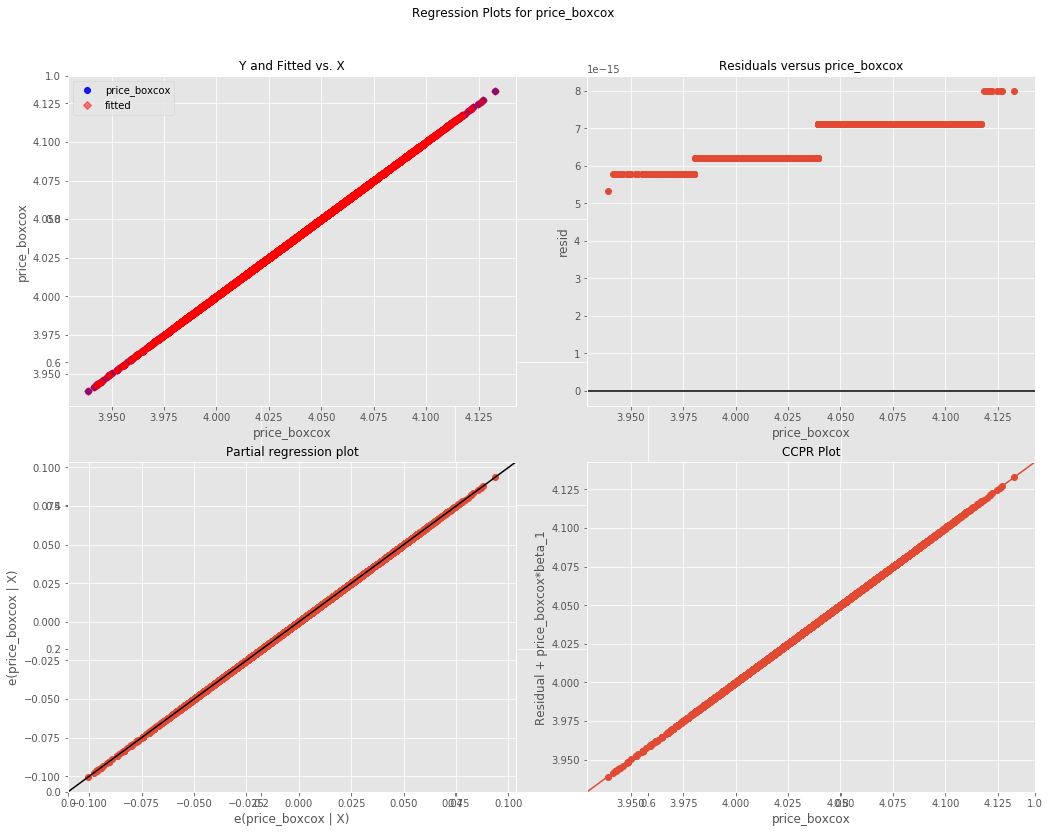

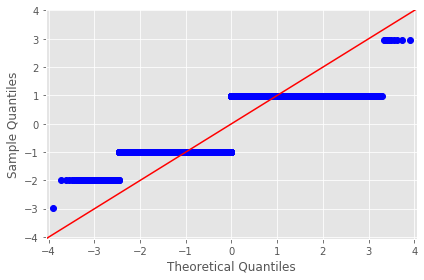

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~t_sqft_living15
-------------------------------------------------------------------------------------


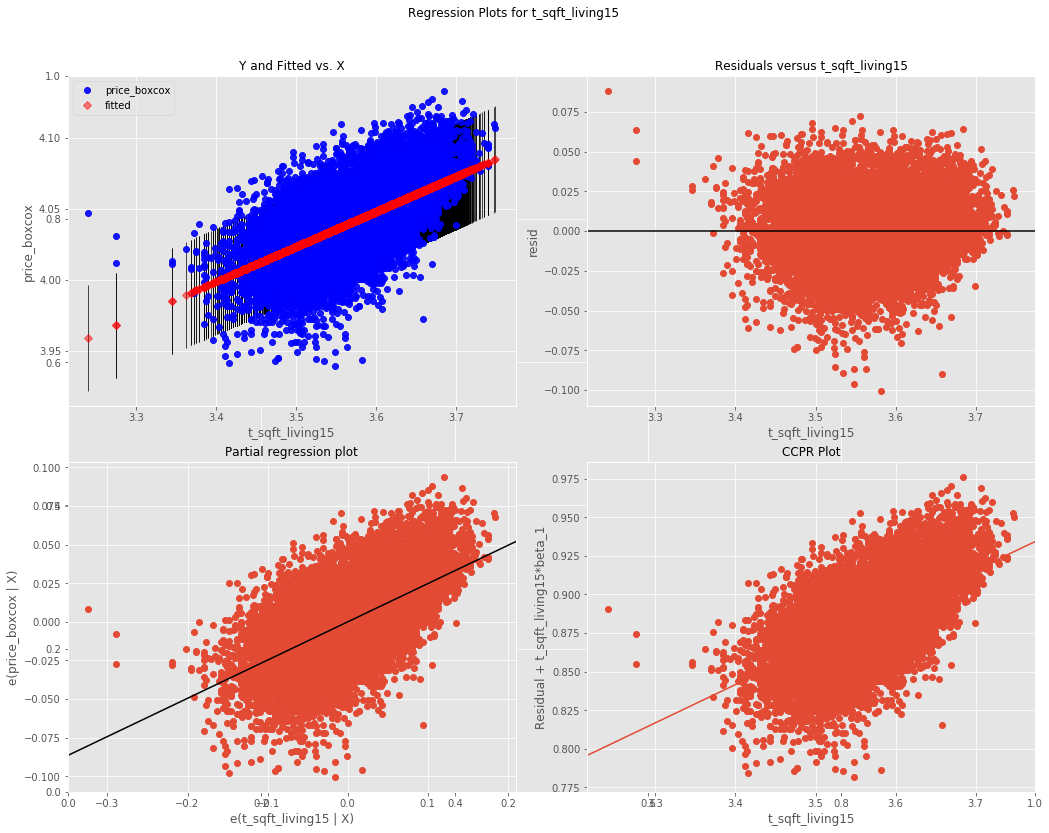

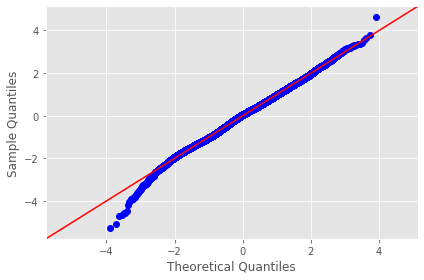

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~grade
-------------------------------------------------------------------------------------


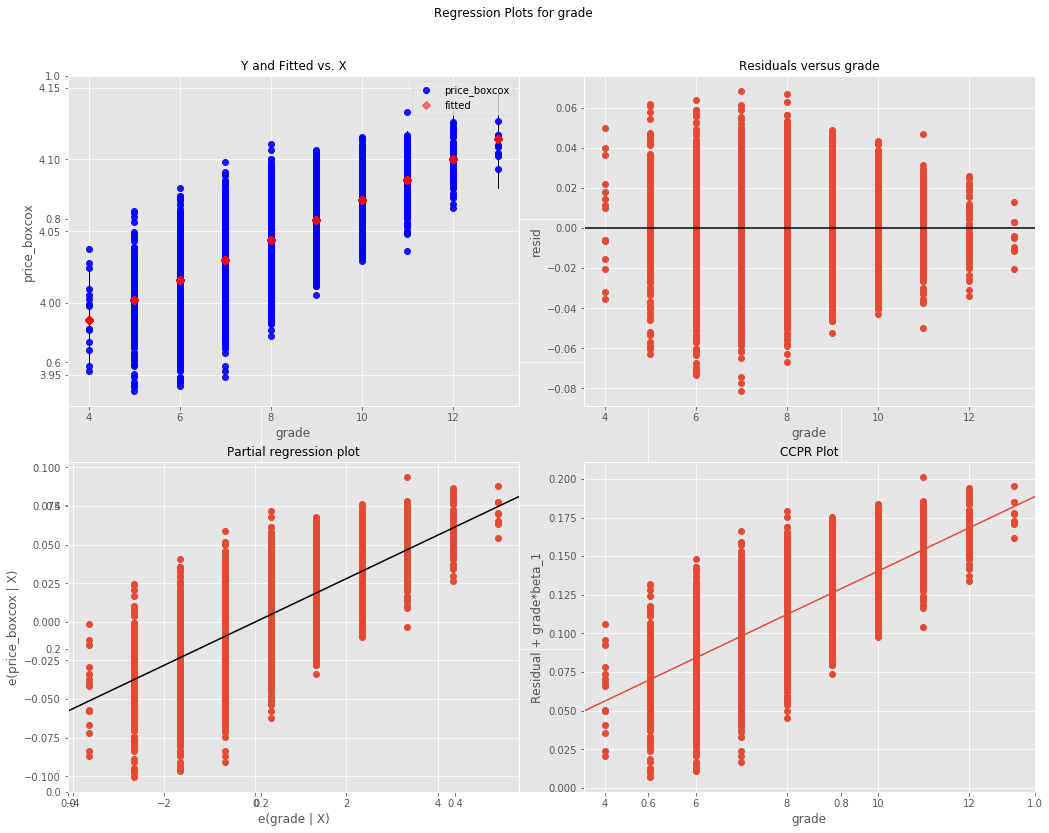

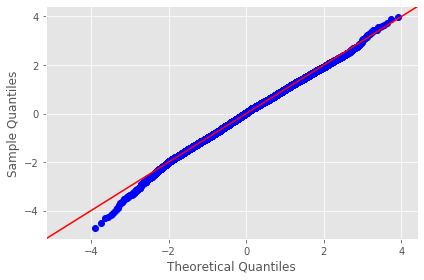

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~t_sqft_living
-------------------------------------------------------------------------------------


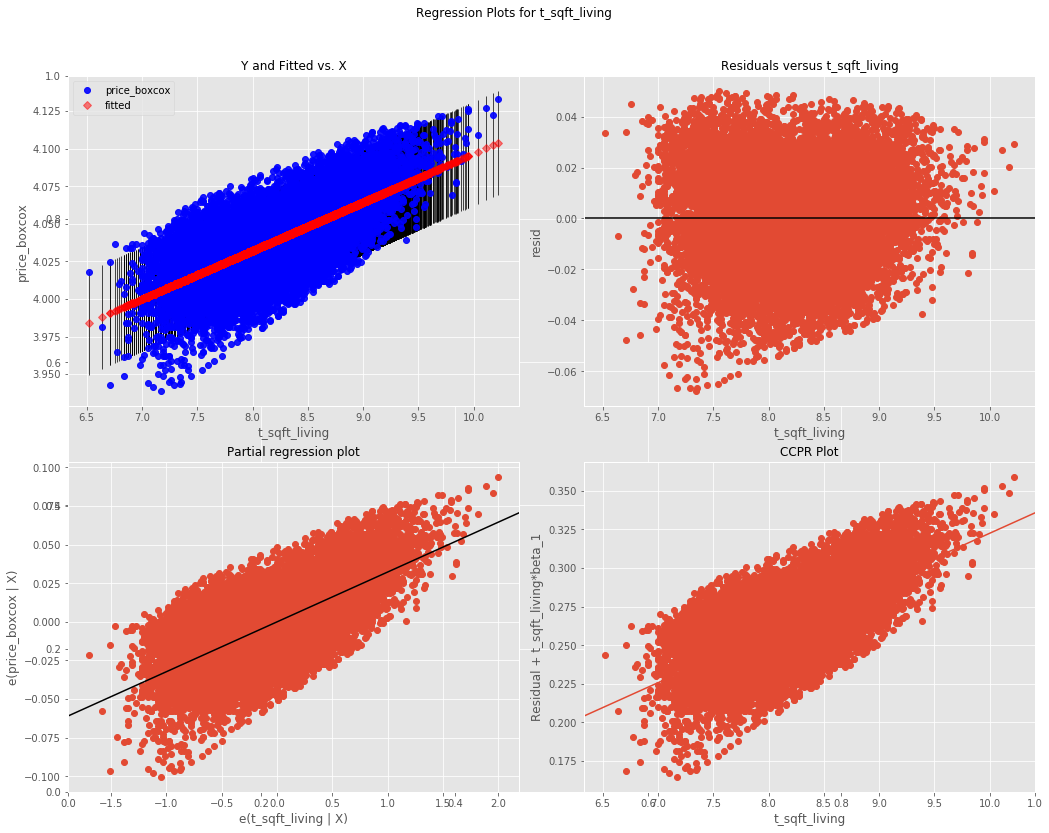

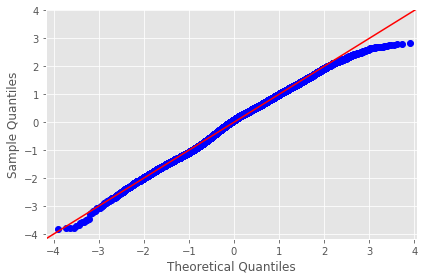

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view
-------------------------------------------------------------------------------------


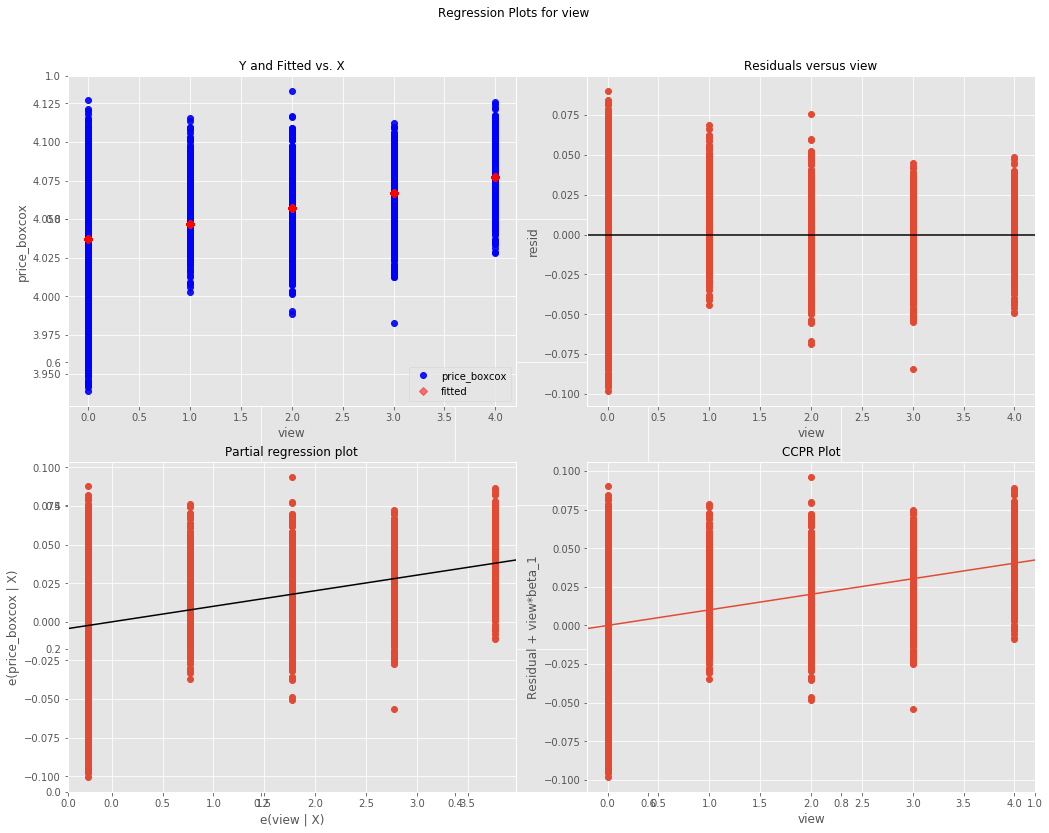

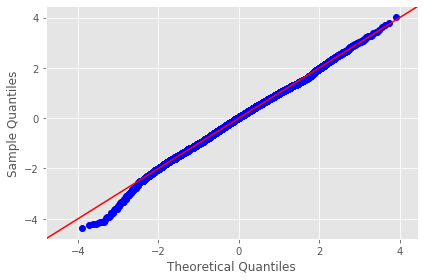

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_15
-------------------------------------------------------------------------------------


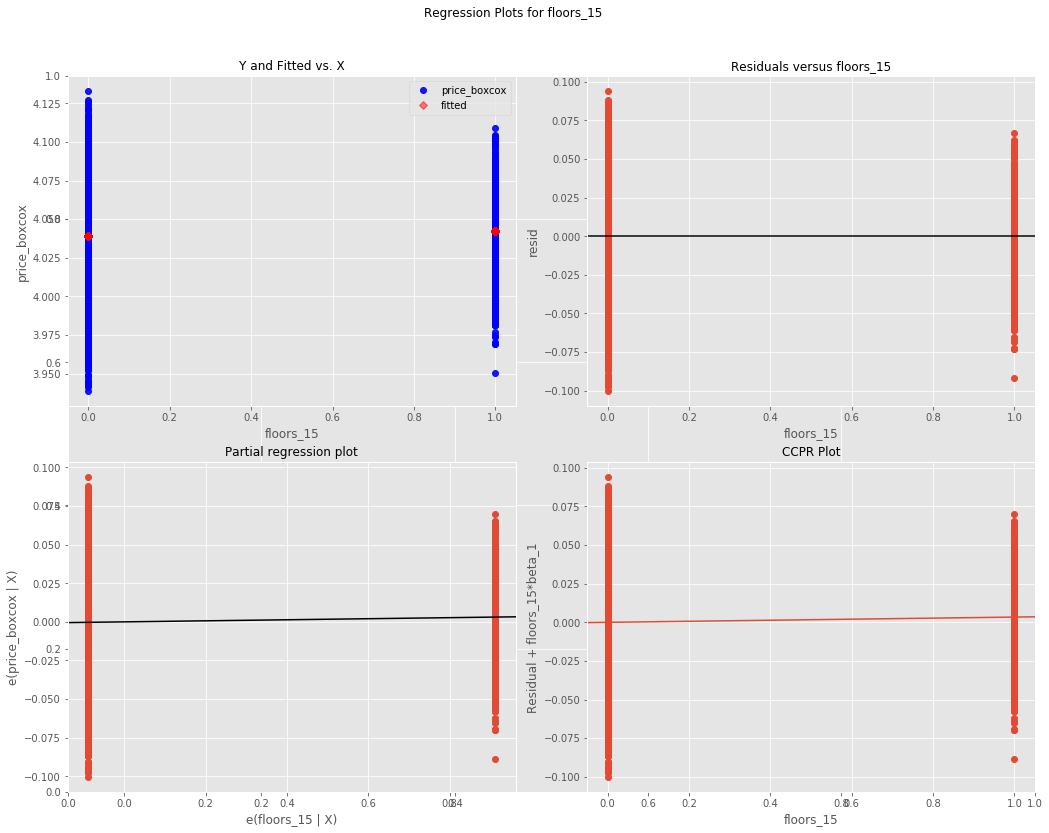

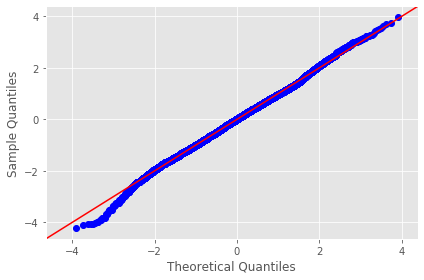

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_5
-------------------------------------------------------------------------------------


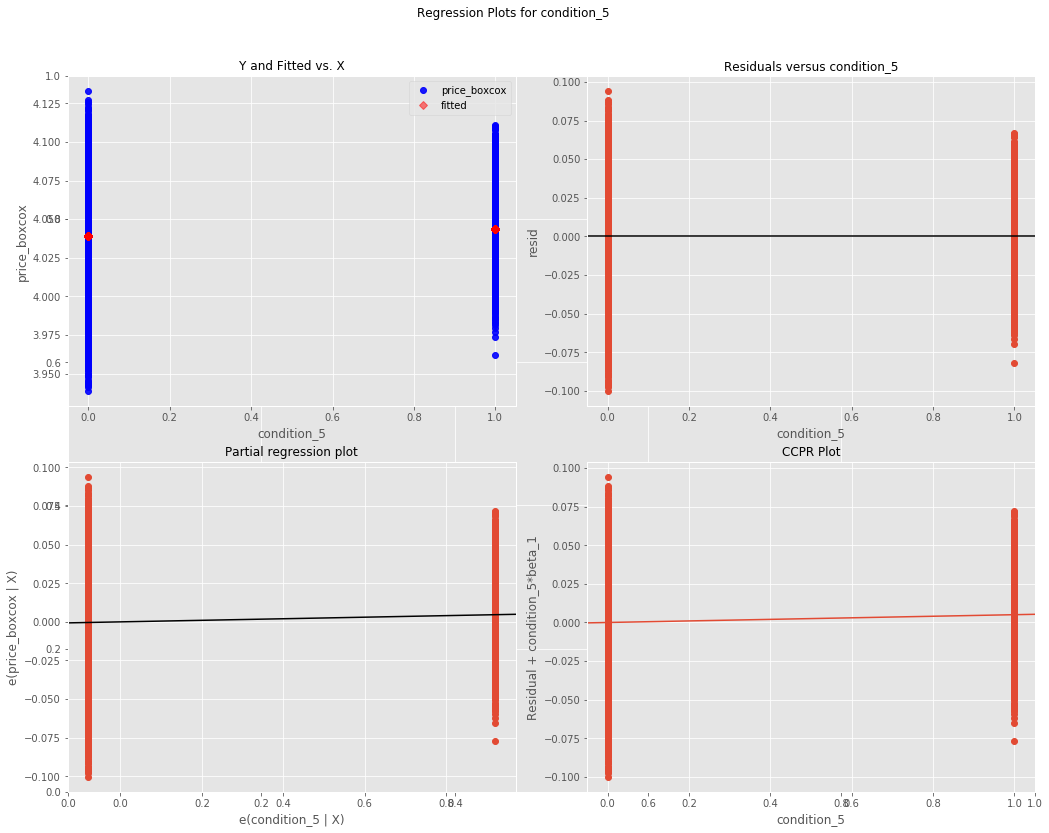

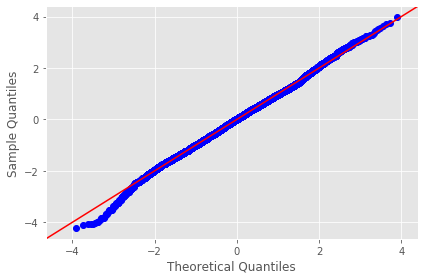

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_4
-------------------------------------------------------------------------------------


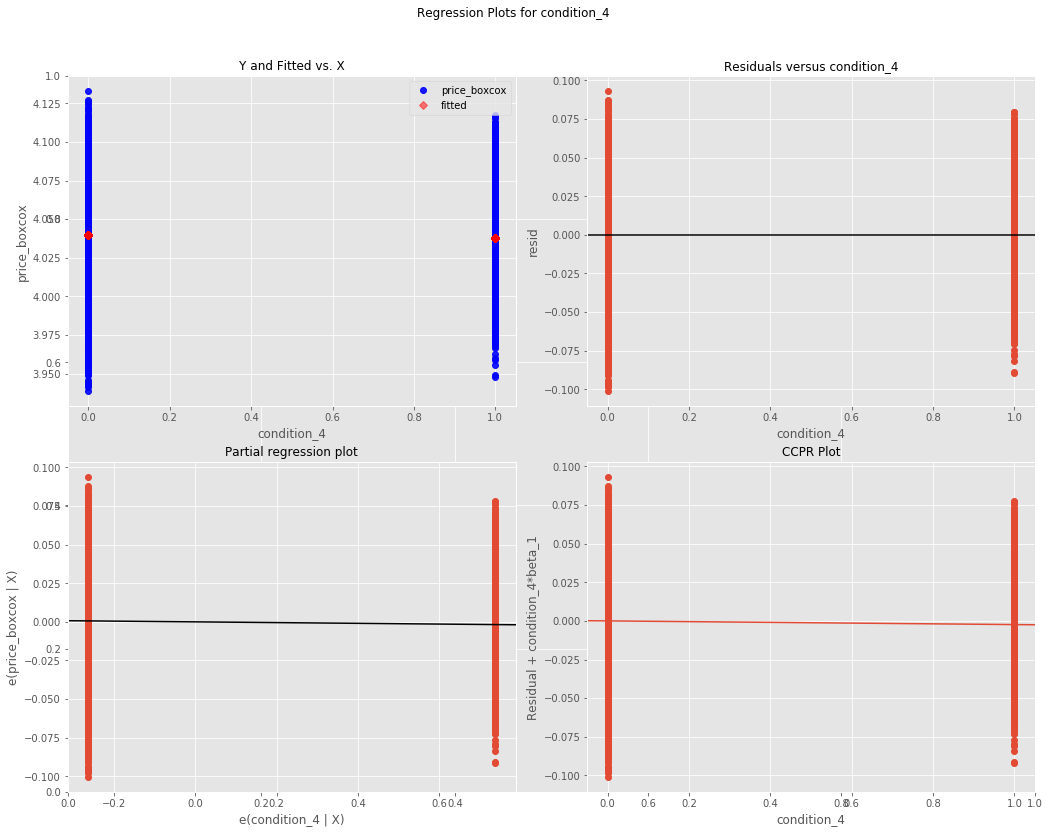

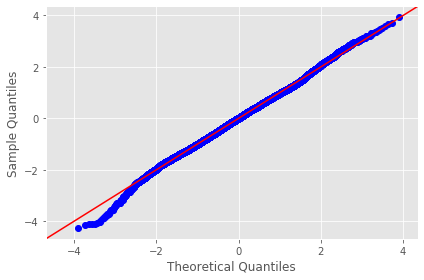

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_30
-------------------------------------------------------------------------------------


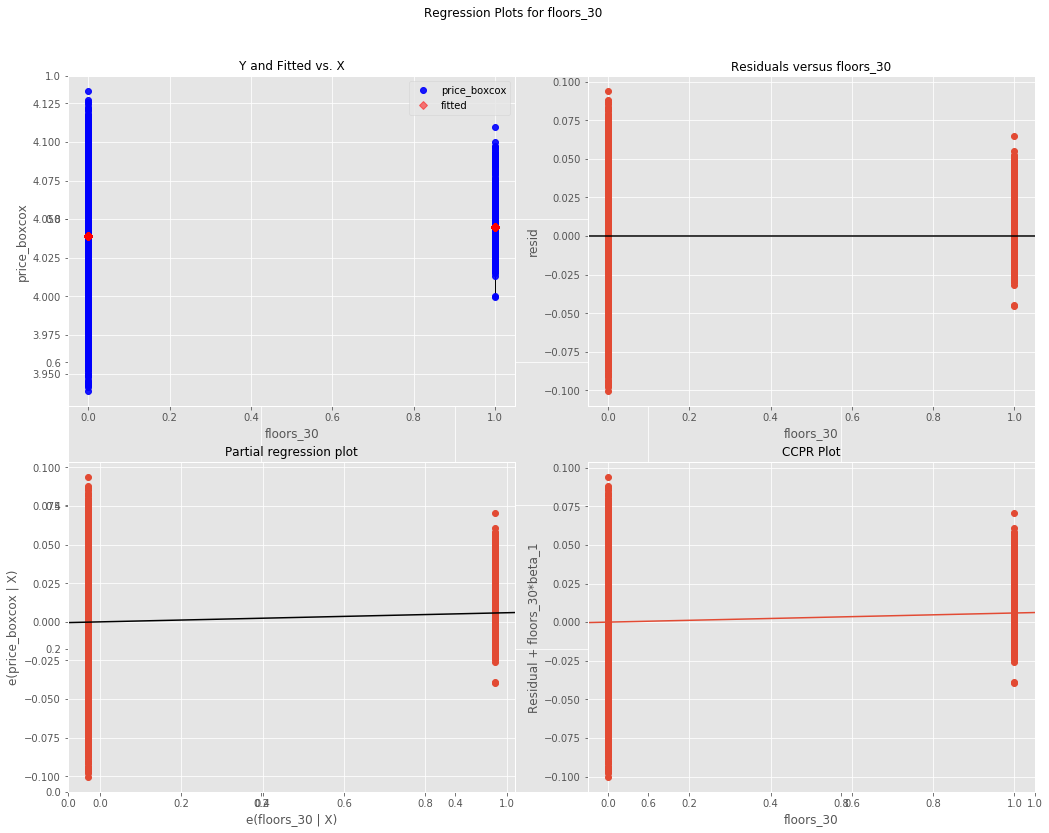

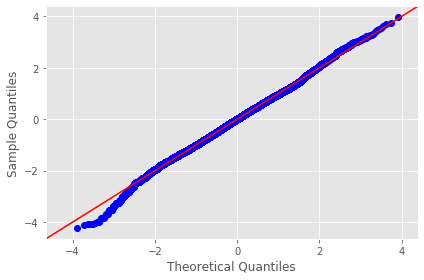

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~bedrooms
-------------------------------------------------------------------------------------


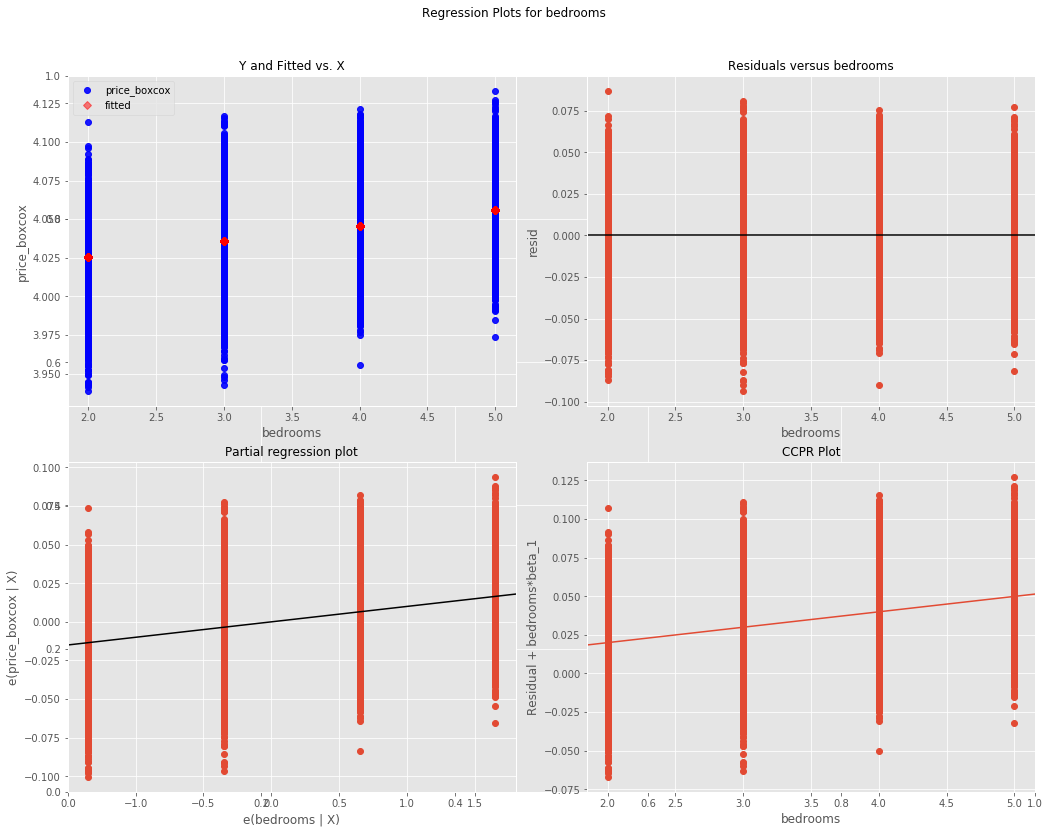

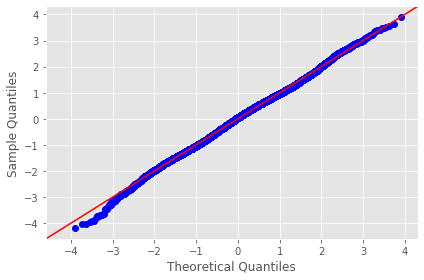

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_4
-------------------------------------------------------------------------------------


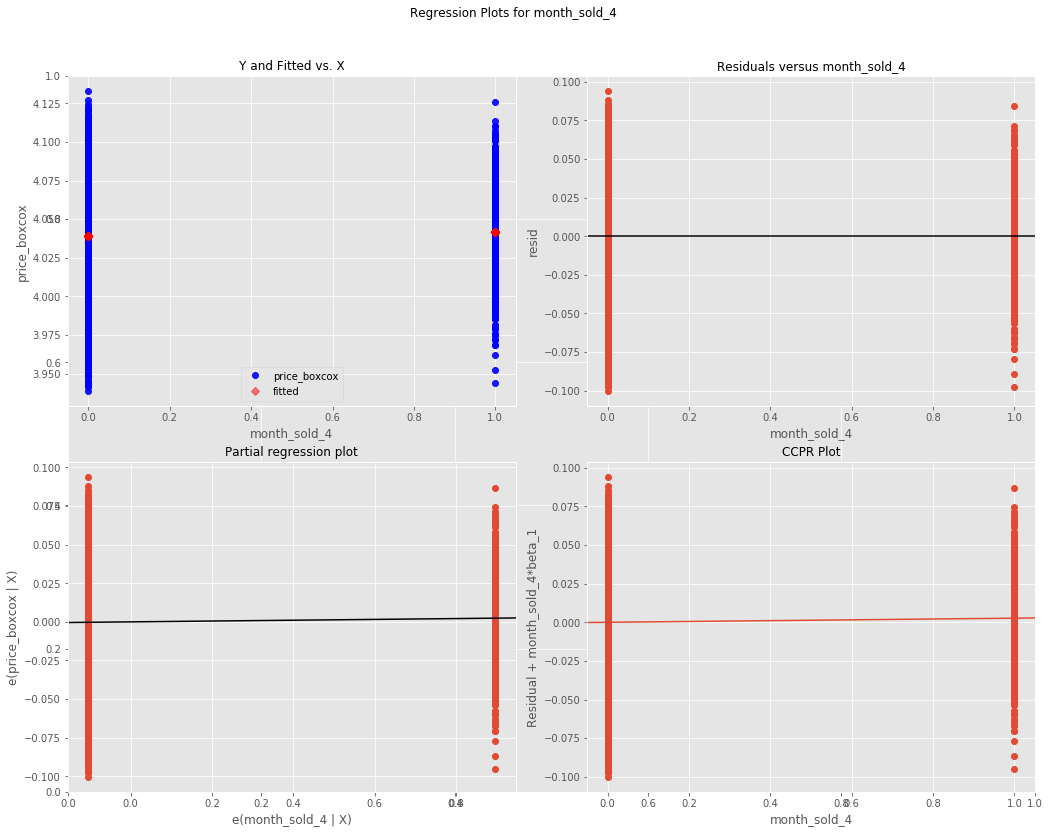

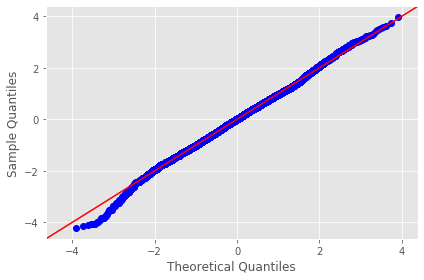

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~waterfront_1
-------------------------------------------------------------------------------------


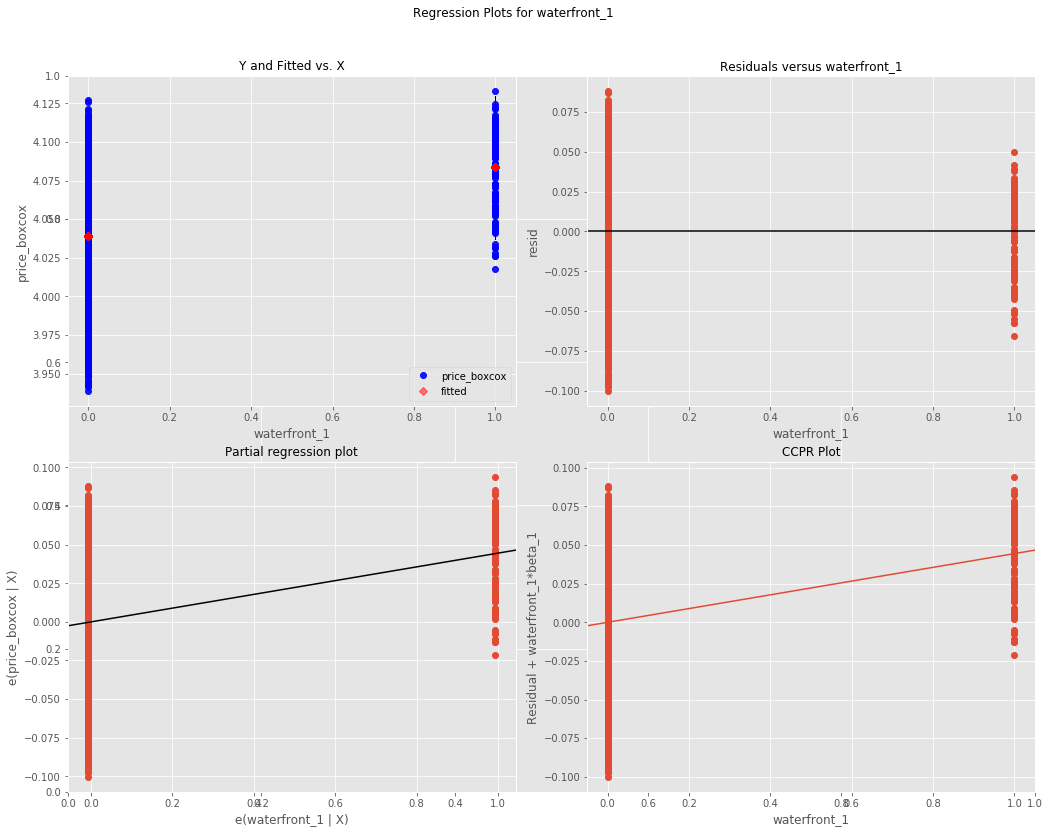

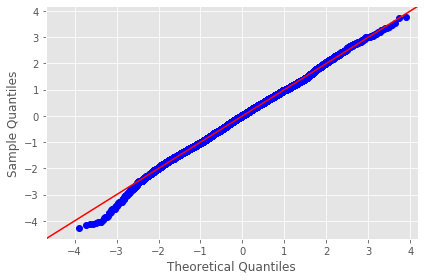

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_25
-------------------------------------------------------------------------------------


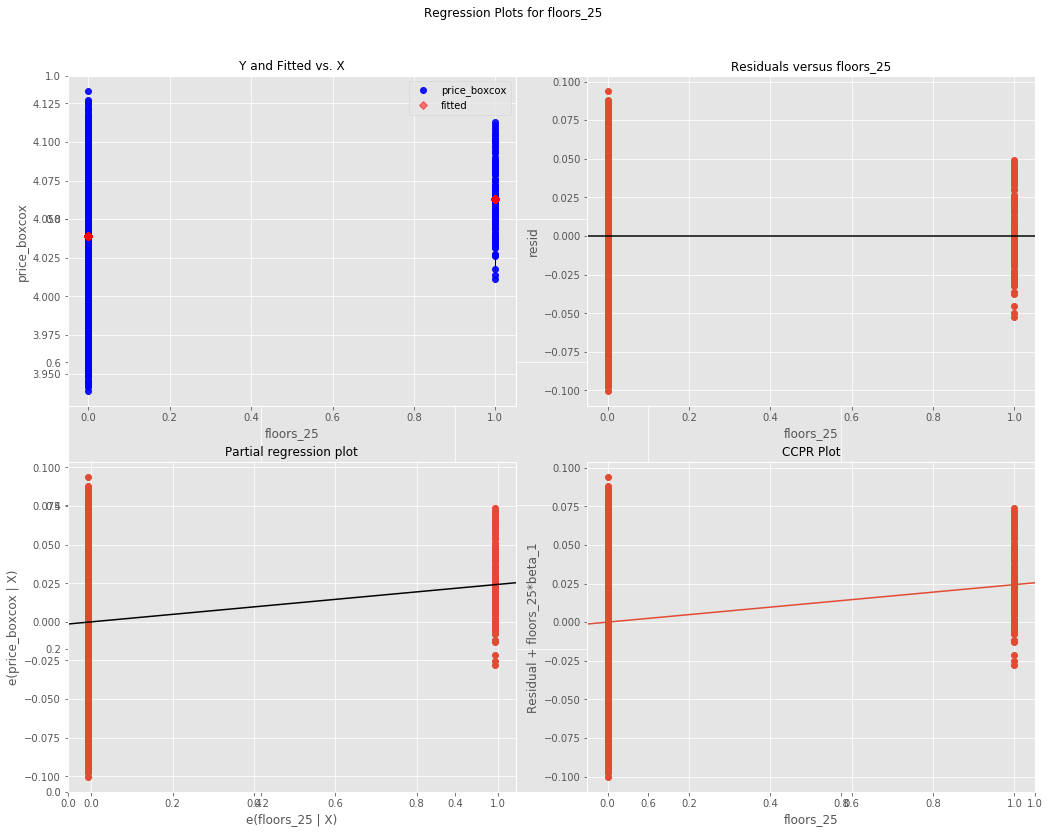

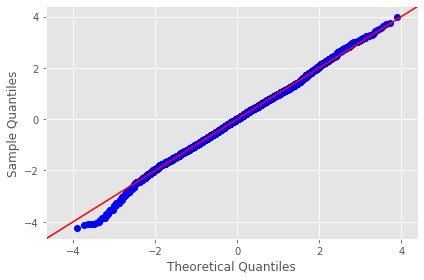

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_3
-------------------------------------------------------------------------------------


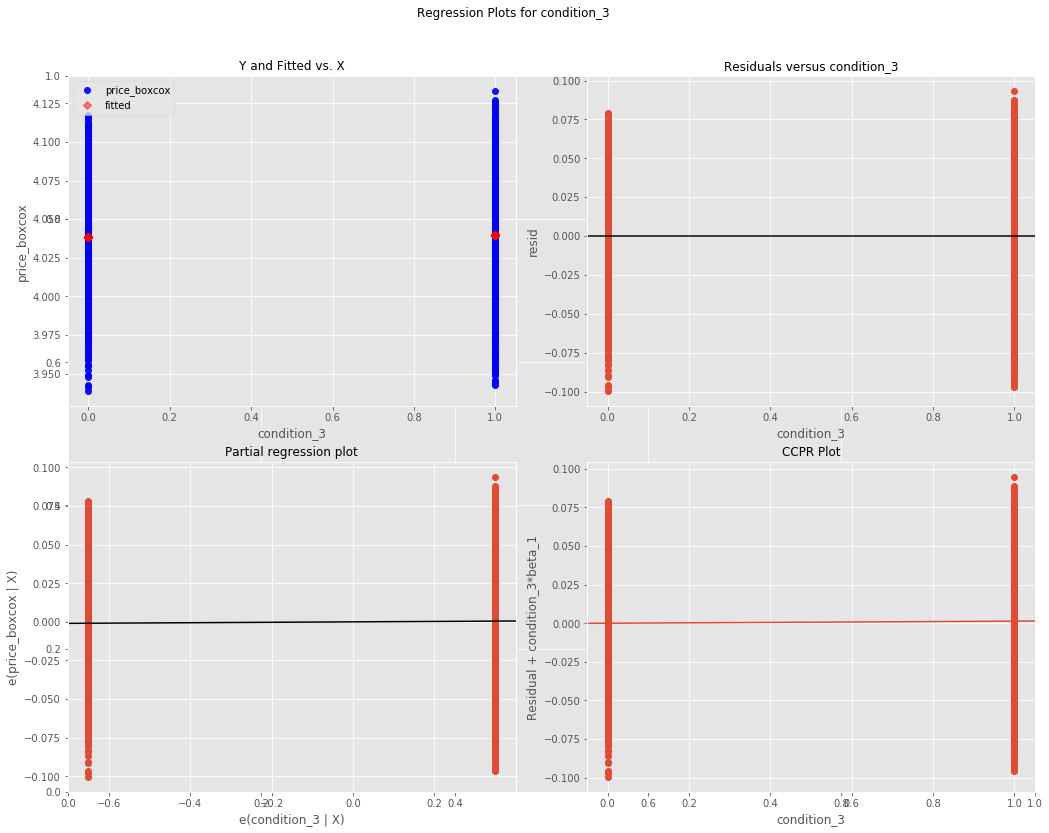

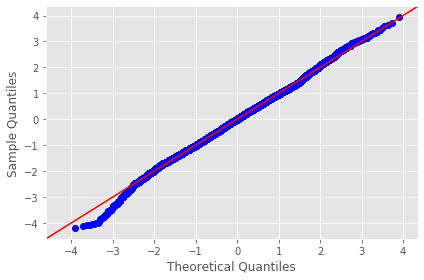

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_3
-------------------------------------------------------------------------------------


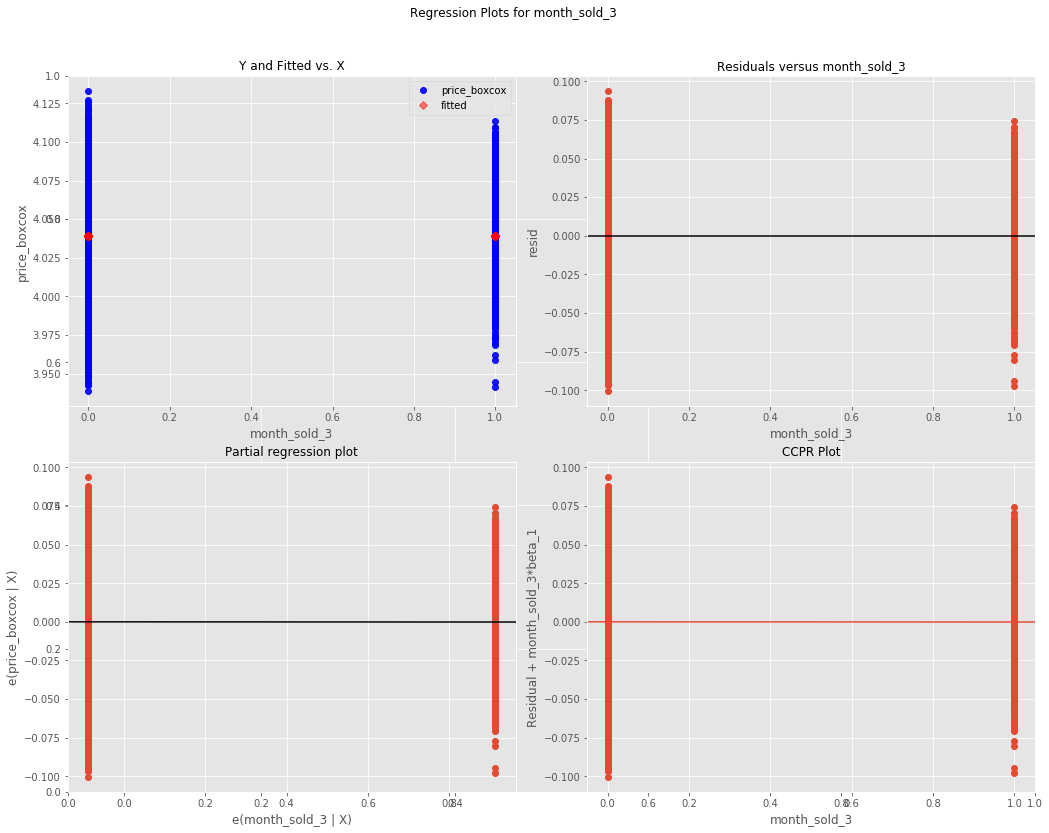

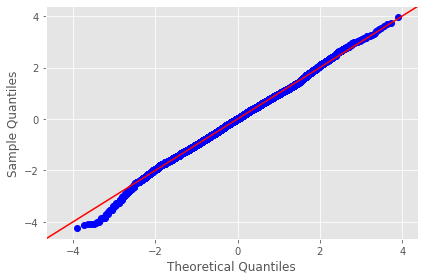

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_20
-------------------------------------------------------------------------------------


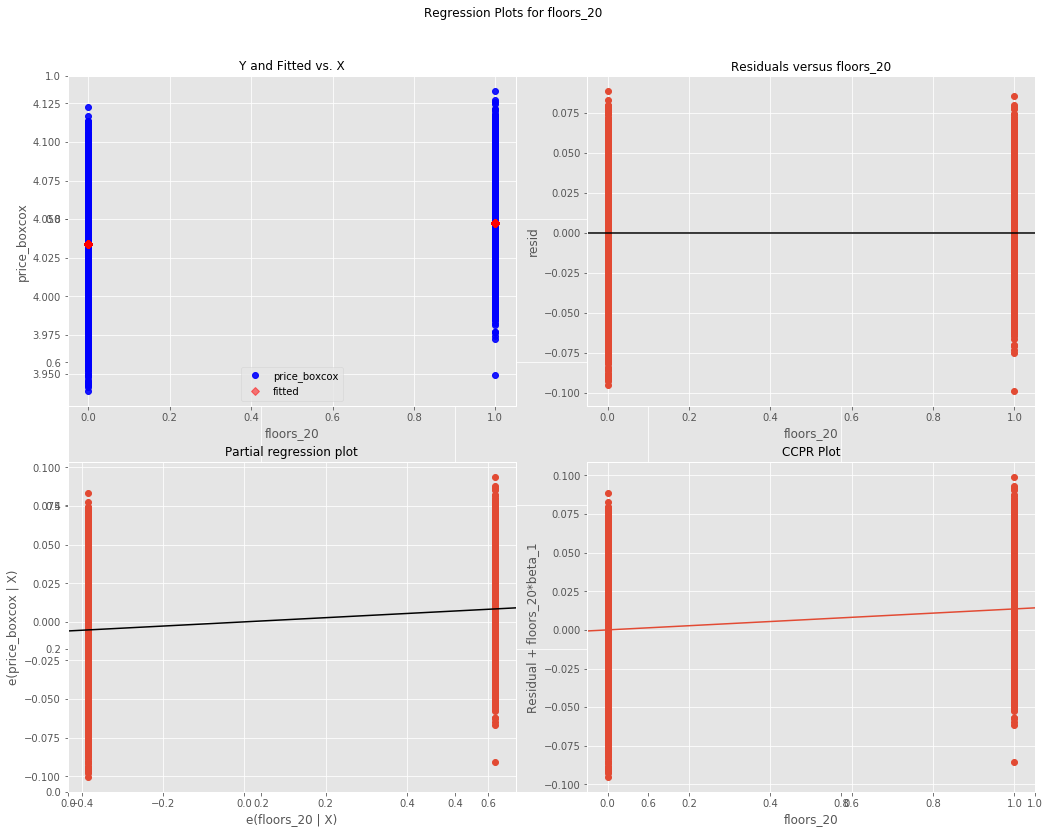

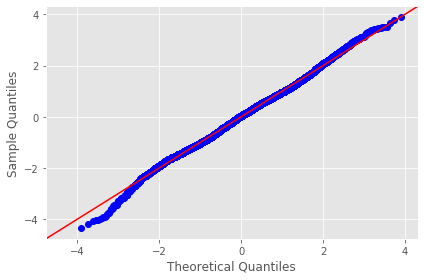

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~month_sold_5
-------------------------------------------------------------------------------------


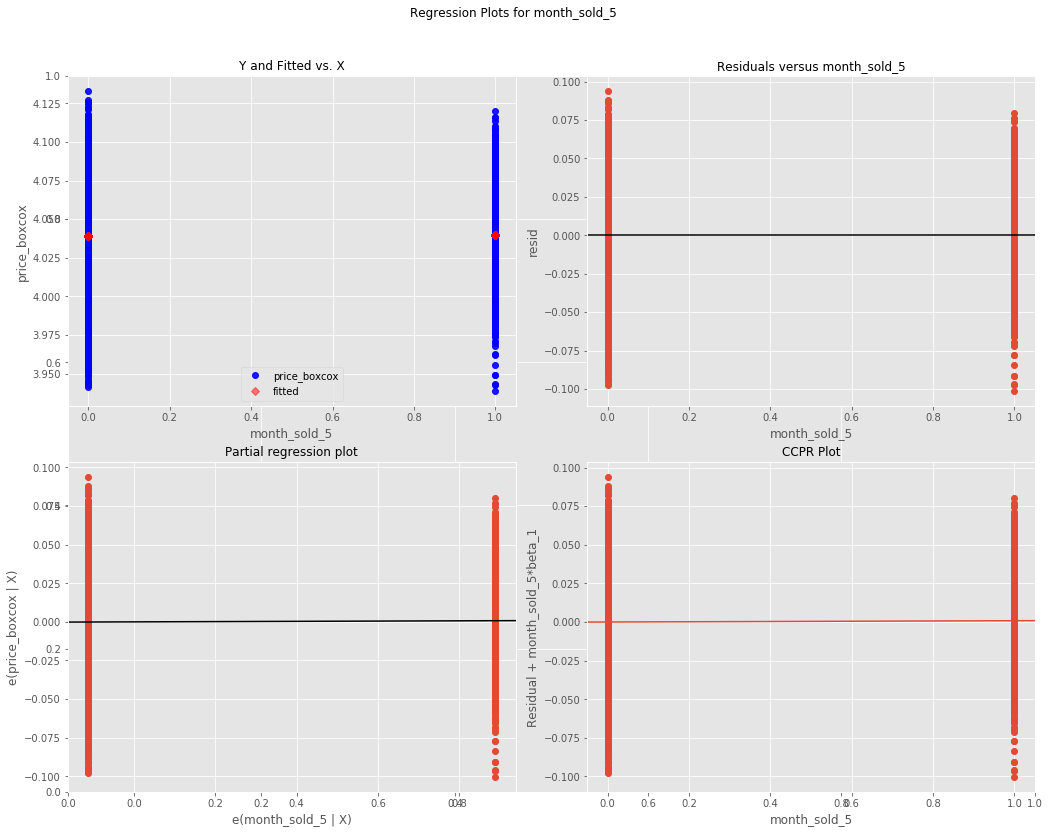

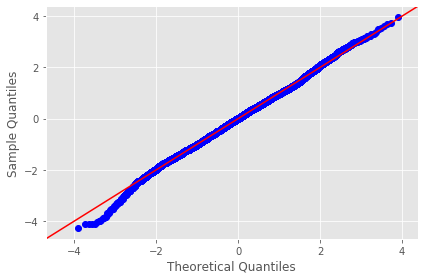

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_26
-------------------------------------------------------------------------------------


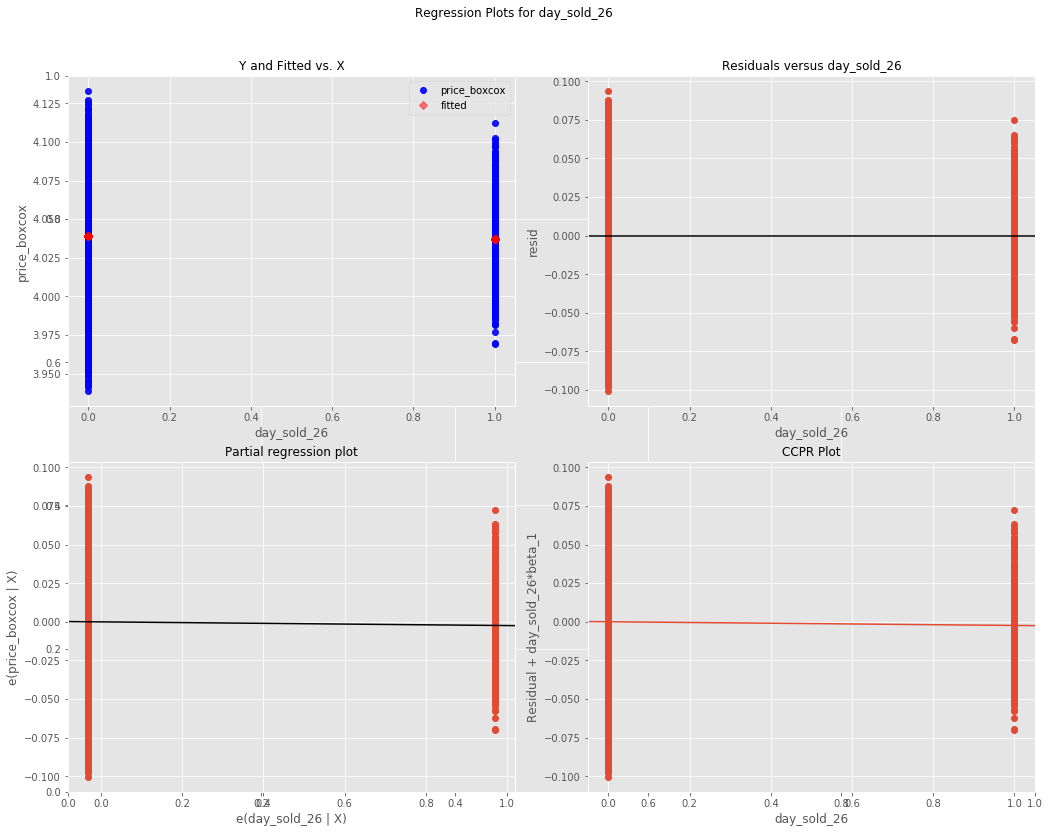

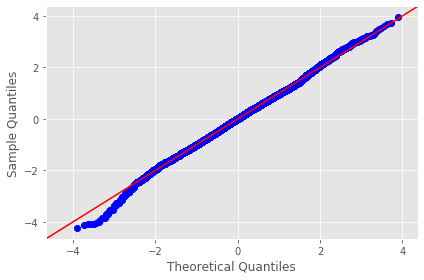

In [187]:
# evaluate residuals to check assumptions
dataset = pd.concat([y, X], axis=1)
results = []
y = 'price_boxcox'
for idx, column in enumerate(dataset.columns):
    print (f"KC Housing DataSet - Regression Analysis and Diagnostics for log_price~{column}")
    print ("-------------------------------------------------------------------------------------")

    f = f'{y}~{column}'
    model = smf.ols(formula=f, data=dataset).fit()
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [188]:
# store results in dataframe
model_4_results = pd.DataFrame(results, columns=['ind_var', 
                                                 'r_squared', 
                                                 'intercept', 
                                                 'slope', 
                                                 'p-value', 
                                                 'normality (JB)'])

In [189]:
model_4_results

ind_var  r_squared     intercept     slope        p-value  \
0      price_boxcox   1.000000  3.907985e-14  1.000000   0.000000e+00   
1   t_sqft_living15   0.353043  3.157039e+00  0.247530   0.000000e+00   
2             grade   0.472322  3.931820e+00  0.014017   0.000000e+00   
3     t_sqft_living   0.443720  3.774144e+00  0.032247   0.000000e+00   
4              view   0.103928  4.036953e+00  0.010080   0.000000e+00   
5         floors_15   0.001659  4.038960e+00  0.003402   3.344667e-09   
6       condition_5   0.003298  4.038862e+00  0.005042   7.308413e-17   
7       condition_4   0.001964  4.039884e+00 -0.002382   1.227108e-10   
8         floors_30   0.001736  4.039090e+00  0.005914   1.445195e-09   
9          bedrooms   0.114176  4.005844e+00  0.009981   0.000000e+00   
10     month_sold_4   0.001183  4.038982e+00  0.002669   5.960818e-07   
11     waterfront_1   0.023037  4.038967e+00  0.044491  8.895722e-109   
12        floors_25   0.007051  4.039095e+00  0.024267   2.795996e-34   
13      condition_3   0.000759  4.038371e+00  0.001366   6.372283e-05   
14     month_sold_3   0.000002  4.039269e+00 -0.000116   8.416459e-01   
15        floors_20   0.078040  4.034052e+00  0.013588   0.000000e+00   
16     month_sold_5   0.000128  4.039164e+00  0.000848   1.012280e-01   
17      day_sold_26   0.000307  4.039333e+00 -0.002385   1.104031e-02   

    normality (JB)  
0      3216.999733  
1        80.507112  
2        73.282341  
3       132.106177  
4        92.526042  
5        66.667865  
6        60.133173  
7        60.705313  
8        56.006227  
9        17.457139  
10       58.320393  
11       47.077454  
12       57.566619  
13       56.870017  
14       57.897185  
15       32.896180  
16       58.576684  
17       58.368056

In [224]:
# Model 5 #
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

In [225]:
# drop price and log_price
preprocessed = clean_data.drop(['price', 'log_price'], axis=1)

In [226]:
# plot price_boxcox against all continuous variables
# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])

# plot_relationship(data=preprocessed, 
#                   y_vars=['price_boxcox'], 
#                   x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [227]:
# remove clear non-linear
preprocessed = preprocessed.drop(['sqft_lot',
                                  'yr_built',
                                  'yr_renovated',
                                  'zipcode',
                                  'lat',
                                  'long',
                                  'sqft_lot15'], axis=1)

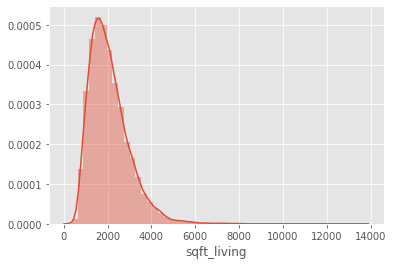

In [228]:
# transform sqft_living, sqft_above, and sqft_living15
# sqft_living
sns.distplot(preprocessed['sqft_living'])

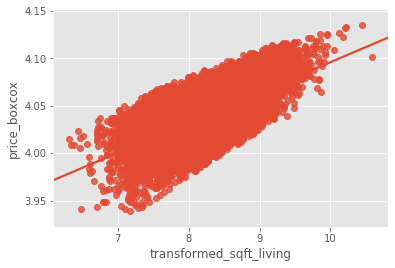

In [229]:
# looking log normally distributed
preprocessed['transformed_sqft_living'], sqft_living_lambda = stats.boxcox(preprocessed['sqft_living'])
sns.regplot(x='transformed_sqft_living', y='price_boxcox', data=preprocessed)

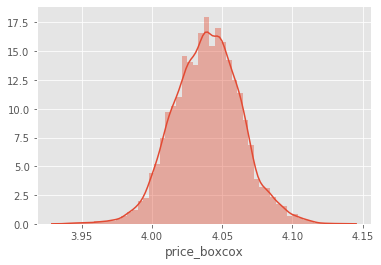

In [230]:
# try removing outliers on price
sns.distplot(preprocessed['price_boxcox'])

In [231]:
low, high = find_outliers('price_boxcox', preprocessed)

In [232]:
no_outliers = preprocessed.loc[(preprocessed['price_boxcox'] > low)
                              & (preprocessed['price_boxcox'] < high)]

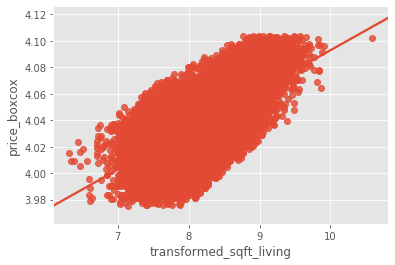

In [233]:
# replot against variables
sns.regplot(x='transformed_sqft_living', 
            y='price_boxcox', 
            data=no_outliers);

In [234]:
# by removing price outliers, things are looking much more linear

In [235]:
# continue with preprocessing
preprocessed = preprocessed.loc[(preprocessed['price_boxcox'] > low)
                              & (preprocessed['price_boxcox'] < high)]

In [219]:
# plot against other continuous variables to see if linearity has improved

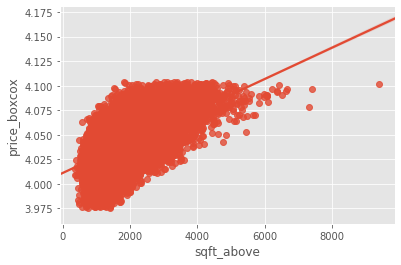

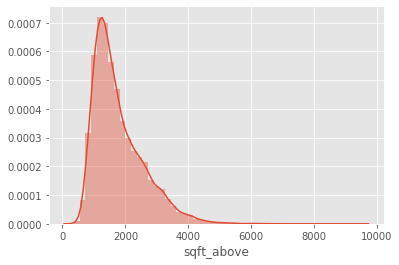

In [236]:
# sqft_above

# regression plot
sns.regplot(x='sqft_above', y='price_boxcox', data=preprocessed);
plt.show()

# distribution
sns.distplot(preprocessed['sqft_above']);
plt.show()

In [237]:
# transform sqft_above
preprocessed['transformed_sqft_above'], sqft_above_lambda = stats.boxcox(preprocessed['sqft_above'])

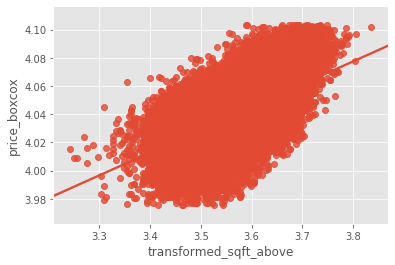

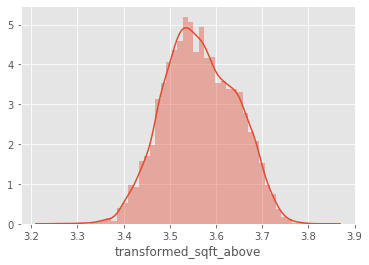

In [238]:
# regression plot
sns.regplot(x='transformed_sqft_above', y='price_boxcox', data=preprocessed);
plt.show()

# distribution
sns.distplot(preprocessed['transformed_sqft_above']);
plt.show()

In [240]:
# looking more linear now

In [241]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21362 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bedrooms                 21362 non-null  int64  
 1   bathrooms                21362 non-null  float64
 2   sqft_living              21362 non-null  int64  
 3   floors                   21362 non-null  float64
 4   waterfront               21362 non-null  float64
 5   view                     21362 non-null  float64
 6   condition                21362 non-null  int64  
 7   grade                    21362 non-null  int64  
 8   sqft_above               21362 non-null  int64  
 9   sqft_basement            21362 non-null  float64
 10  sqft_living15            21362 non-null  int64  
 11  year_sold                21362 non-null  int64  
 12  month_sold               21362 non-null  int64  
 13  day_sold                 21362 non-null  int64  
 14  price_boxcox          

In [243]:
# drop sqft_living and sqft_above
preprocessed = preprocessed.drop(['sqft_living', 'sqft_above'], axis=1)

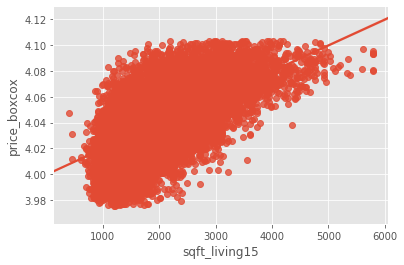

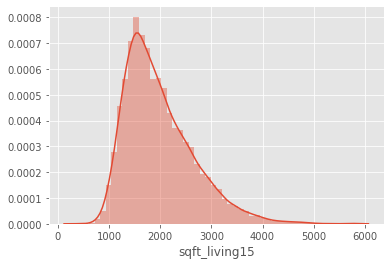

In [244]:
# sqft_living15
# regression plot
sns.regplot(x='sqft_living15', y='price_boxcox', data=preprocessed);
plt.show()

# distribution
sns.distplot(preprocessed['sqft_living15']);
plt.show()

In [245]:
# transform
preprocessed['transformed_sqft_living15'], lambda_sqft_liv_15 = stats.boxcox(preprocessed['sqft_living15'])

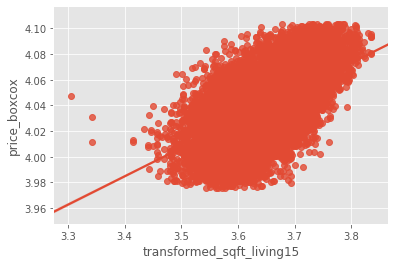

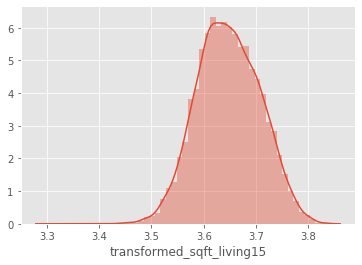

In [246]:
# regression plot
sns.regplot(x='transformed_sqft_living15', y='price_boxcox', data=preprocessed);
plt.show()

# distribution
sns.distplot(preprocessed['transformed_sqft_living15']);
plt.show()

In [247]:
# looking much more linear now